<a href="https://colab.research.google.com/github/fronzofronzo/progettoDataIntensive/blob/main/progetto_data_intensive_classificazione.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto data intensive - Gabriele Fronzoni, Kevin Shimaj, Orazio Spina


---


Il seguente progetto ha come scopo quello di confrontare diversi modelli di Machine Learning per operazioni di classificazione. Per farlo, vengono presi e pre-elaborati alcuni dataset. Successivamente, si definiscono i modelli che vengono utilizzati. Infine si analizzano i risultati ottenuti.

Sono stati scelti dataset dalle caratteristiche differenti tra loro, al fine di poter effettuare un confronto incrociato dataset-modelli e vedere le prestazioni per le diverse combinazioni.

# Librerie

---


In [1]:
!pip install imbalanced-learn xgboost
import kagglehub
import pandas as pd
from kagglehub import KaggleDatasetAdapter
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import xgboost
from xgboost import XGBClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 10.6 MB/s eta 0:00:00


# Funzioni di utilità

## Kappa Statistic
Consiste nel confrontare il modello con un classificatore casuale e vedere qual è il guadagno. Un valore di 1 significa un accuratezza perfetta un valore di 0 significa che non fa meglio di un classificatore casuale.

$ k = \frac{(accuracy - P_e)}{1 - P_e} $

Dove $P_e$ è il prodotto dei totali positivi sommato a quelli negativi, diviso il quadrato del numero totale delle predizioni.

$ P_e = \frac{(reali\_positivi * predetti\_positivi) + (reali\_negativi * predetti\_negativi)}{N^2} $

In [2]:
def kappa_statistic(model, X, y):
  print("\nCalcolo del valore del kappa statistic")
  y_pred = model.predict(X)
  tn,fp,fn,tp = confusion_matrix(y, y_pred).ravel().tolist()
  reali_positivi = tp + fn
  predetti_positivi = tp + fp
  reali_negativi = tn + fp
  predetti_negativi = tn + fn
  accuracy = (tp + tn)/(tn+fp+fn+tp)
  N = tp+fp+tn+fn

  pe = ((reali_positivi * predetti_positivi) + (reali_negativi * predetti_negativi)) / N**2

  kappa_statistic = (accuracy - pe) / (1 - pe)
  print(f"Kappa statistic value: {kappa_statistic}")

## Intervallo di accuratezza

Impostiamo un livello di confidenza del 95% (ossia che al 95% il nostro modello quando vede dati nuovi avrà un accuratezza all'interno di questo intervallo che andremo a calcolare).

Con un livello di confidenza del 95% scegliamo un valore di $ Z = 1.96 $.

In [3]:
def intervallo_di_accuratezza(model, X, y, Z=1.96):
  #  Il valore critico della distribuzione Normale standard per il livello di confidenza desiderato. Per un intervallo di confidenza al 95%, il valore di Z è 1.96, impostato come a default della funzione nel caso non venga specificato.
  print(f"\nCalcolo dell'intervallo di accuratezza per un valore di Z uguale a {Z}")
  y_pred = model.predict(X)
  tn,fp,fn,tp = confusion_matrix(y, y_pred).ravel()
  accuracy = (tp + tn)/(tn+fp+fn+tp)
  N = tp+fp+tn+fn

  p_min = (2*N*accuracy+Z**2-(Z*np.sqrt(Z**2 + 4 * N * accuracy - 4 * N * accuracy**2))) / (2*(N + Z**2))
  p_max = (2*N*accuracy+Z**2+(Z*np.sqrt(Z**2 + 4 * N * accuracy - 4 * N * accuracy**2))) / (2*(N + Z**2))
  print(f"Valore di N: {N}")
  print(f"P minimo: {p_min}")
  print(f"P massimo: {p_max}")

## Analizzare i risultati di una grid search

In [4]:
def analyze_grid_search_results(grid_search_result):
    print("Migliori parametri trovati:", grid_search_result.best_params_)
    print("Miglior punteggio medio CV:", grid_search_result.best_score_)

    results = pd.DataFrame(grid_search_result.cv_results_)

    results_sorted = results.sort_values(by='rank_test_score')

    param_cols = [col for col in results_sorted.columns if col.startswith('param_')]
    relevant_cols = param_cols + ['mean_test_score', 'std_test_score', 'rank_test_score']

    print("\nDettagli dei risultati della Grid Search (prime 10 combinazioni):")

    print(results_sorted[relevant_cols].head(10).to_string())


## Valutazione modello con matrice di confusione

In [5]:
def evaluation_confusion_matrix(model, X, y, param_name):
  y_pred = model.predict(X)
  tn,fp,fn,tp = confusion_matrix(y, y_pred).ravel()
  accuracy = (tp + tn)/(tn+fp+fn+tp)
  precision_pos = tp / (tp+fp)
  precision_neg = tn / (tn+fn)
  precision = (precision_pos + precision_neg) / 2
  recall_pos = tp / (tp + fn)
  recall_neg = tn / (tn+fp)
  recall = (recall_pos + recall_neg) / 2
  F1_measure_pos = (2 * recall_pos * precision_pos)/(precision_pos + recall_pos)
  F1_measure_neg = (2 * recall_neg * precision_neg) / (precision_neg + recall_neg)
  F1_measure = (F1_measure_pos + F1_measure_neg)/2

  print(f"True Positives (TP): {tp}")
  print(f"False Positives (FP): {fp}")
  print(f"False Negatives (FN): {fn}")
  print(f"True Negatives (TN): {tn}")
  print(f"\nAccuratezza: {accuracy:.2f}")
  print(f"Precisione ({param_name}=1): {precision_pos:.2f}")
  print(f"Precisione ({param_name}=0): {precision_neg:.2f}")
  print(f"Precisione media: {precision:.2f}")
  print(f"Richiamo ({param_name}=1): {recall_pos:.2f}")
  print(f"Richiamo ({param_name}=0): {recall_neg:.2f}")
  print(f"Richiamo medio: {recall:.2f}")
  print(f"F1-Score ({param_name}=1): {F1_measure_pos:.2f}")
  print(f"F1-Score ({param_name}=0): {F1_measure_neg:.2f}")
  print(f"F1-Score medio: {F1_measure:.2f}")

  cm = confusion_matrix(y, y_pred)
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Not {param_name}', f'{param_name}'], yticklabels=[f'Not {param_name}', f'{param_name}'])
  plt.title('Matrice di Confusione')
  plt.ylabel('Valori Reali')
  plt.xlabel('Valori Predetti')
  plt.show()

## Confronto tra due modelli
Dati due modelli è possibile stimare quale dei due è migliore, questo lo si fa valutando la differenza di accuratezza tra i due modelli è statisticamente significativa.

Calcoliamo quindi la differenza in valore assoluto degli errori dei due modelli:

$d = |e2 - e1|$

Si calcola la varianza:

$\sigma^2_t=\frac{e1(1-e1)}{n1}+\frac{e2(1-e2)}{n2}$

Usiamo di defaul una confidenza $1-\alpha=0.95$ che corrisponde a $Z_{\alpha/2}=1.96$

E calcoliamo l'intervallo $d_t$ come:

$d_t = d \pm Z_{\alpha/2}\sigma_t$

Se lo zero è compreso in questo intervallo la differenza tra i due modelli non è statisticamente significativa. La differenza è solo un frutto del caso, ripetendo più volte gli esperimenti potremmo ottenere risultati opposti.

In [6]:
def confronta_modelli(model1, model2, X1, X2, y1, y2, Z=1.96):
  N1 = len(y1)
  N2 = len(y2)

  y1_pred = model1.predict(X1)
  y2_pred = model2.predict(X2)

  accuracy1 = accuracy_score(y1, y1_pred)
  accuracy2 = accuracy_score(y2, y2_pred)

  E1 = 1 - accuracy1
  E2 = 1 - accuracy2

  d = np.abs(E2 - E1)
  varianza = (E1*(1-E1)/N1) + (E2*(1-E2)/N2)
  d_t_min = d - Z * np.sqrt(varianza)
  d_t_max = d + Z * np.sqrt(varianza)

  print(f"D minimo: {d_t_min}")
  print(f"D massimo: {d_t_max}")

  if min(d_t_min, d_t_max) <= 0 <= max(d_t_min, d_t_max):
    print("Lo zero è contenuto nell'intervallo. Quindi la differenza tra i due modelli non è significativa")
  else:
    print("Lo zero non è contenuto nell'intervallo. Quindi la differenza di score è significativa.")


# Shimaj Kevin

## Analisi del Churn dei Clienti nel Settore Telecomunicazioni

### Cos’è il customer churn?

Secondo la definizione di Wikipedia, il customer churn, noto anche come abbandono del cliente, defezione o turnover, è la perdita di clienti o utenti. Il tasso di churn è una metrica chiave in qualsiasi settore e azienda che fornisce servizi ai clienti finali, perché il costo per mantenere un cliente esistente è molto inferiore rispetto a quello per acquisirne uno nuovo.

### Perché il churn è importante nel settore delle telecomunicazioni?

In un mercato altamente competitivo come quello delle telecomunicazioni, l’aumento del tasso di abbandono rappresenta una sfida significativa per i fornitori di servizi. Acquisire nuovi clienti richiede investimenti e sforzi considerevoli, mentre il rischio di perdere clienti attuali a favore della concorrenza è sempre presente. Per questo motivo, analizzare e comprendere i fattori che portano al churn è fondamentale.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/telco-customer-churn


In [ ]:
# Il file CSV si trova dentro 'path'
file_path = path + "/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [ ]:
df.tail()

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male              1     Yes         No       4   
7042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
7038          Yes               Yes             DSL            Yes  ...   
7039          Yes               Yes     Fiber optic             No  ...   
7040           No  No phone service             DSL            Yes  ...   
7041          Yes               Yes     Fiber optic             No  ...   
7042          Yes                No     Fiber optic            Yes  ...   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
7038              Yes         Yes         Yes             Yes        One year   
7039              Yes          No         Yes             Yes        One year   
7040               No          No          No              No  Month-to-month   
7041               No          No          No              No  Month-to-month   
7042              Yes         Yes         Yes             Yes        Two year   

     PaperlessBilling              PaymentMethod MonthlyCharges  TotalCharges  \
7038              Yes               Mailed check          84.80        1990.5   
7039              Yes    Credit card (automatic)         103.20        7362.9   
7040              Yes           Electronic check          29.60        346.45   
7041              Yes               Mailed check          74.40         306.6   
7042              Yes  Bank transfer (automatic)         105.65        6844.5   

     Churn  
7038    No  
7039    No  
7040    No  
7041   Yes  
7042    No  

[5 rows x 21 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
df.describe(include='all') # Senza include='all' otterrei solo le colonne numeriche

customerID gender  SeniorCitizen Partner Dependents       tenure  \
count         7043   7043    7043.000000    7043       7043  7043.000000   
unique        7043      2            NaN       2          2          NaN   
top     3186-AJIEK   Male            NaN      No         No          NaN   
freq             1   3555            NaN    3641       4933          NaN   
mean           NaN    NaN       0.162147     NaN        NaN    32.371149   
std            NaN    NaN       0.368612     NaN        NaN    24.559481   
min            NaN    NaN       0.000000     NaN        NaN     0.000000   
25%            NaN    NaN       0.000000     NaN        NaN     9.000000   
50%            NaN    NaN       0.000000     NaN        NaN    29.000000   
75%            NaN    NaN       0.000000     NaN        NaN    55.000000   
max            NaN    NaN       1.000000     NaN        NaN    72.000000   

       PhoneService MultipleLines InternetService OnlineSecurity  ...  \
count          7043          7043            7043           7043  ...   
unique            2             3               3              3  ...   
top             Yes            No     Fiber optic             No  ...   
freq           6361          3390            3096           3498  ...   
mean            NaN           NaN             NaN            NaN  ...   
std             NaN           NaN             NaN            NaN  ...   
min             NaN           NaN             NaN            NaN  ...   
25%             NaN           NaN             NaN            NaN  ...   
50%             NaN           NaN             NaN            NaN  ...   
75%             NaN           NaN             NaN            NaN  ...   
max             NaN           NaN             NaN            NaN  ...   

       DeviceProtection TechSupport StreamingTV StreamingMovies  \
count              7043        7043        7043            7043   
unique                3           3           3               3   
top                  No          No          No              No   
freq               3095        3473        2810            2785   
mean                NaN         NaN         NaN             NaN   
std                 NaN         NaN         NaN             NaN   
min                 NaN         NaN         NaN             NaN   
25%                 NaN         NaN         NaN             NaN   
50%                 NaN         NaN         NaN             NaN   
75%                 NaN         NaN         NaN             NaN   
max                 NaN         NaN         NaN             NaN   

              Contract PaperlessBilling     PaymentMethod MonthlyCharges  \
count             7043             7043              7043    7043.000000   
unique               3                2                 4            NaN   
top     Month-to-month              Yes  Electronic check            NaN   
freq              3875             4171              2365            NaN   
mean               NaN              NaN               NaN      64.761692   
std                NaN              NaN               NaN      30.090047   
min                NaN              NaN               NaN      18.250000   
25%                NaN              NaN               NaN      35.500000   
50%                NaN              NaN               NaN      70.350000   
75%                NaN              NaN               NaN      89.850000   
max                NaN              NaN               NaN     118.750000   

        TotalCharges Churn  
count           7043  7043  
unique          6531     2  
top                     No  
freq              11  5174  
mean             NaN   NaN  
std              NaN   NaN  
min              NaN   NaN  
25%              NaN   NaN  
50%              NaN   NaN  
75%              NaN   NaN  
max              NaN   NaN  

[11 rows x 21 columns]

In [ ]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Come si può notare dalla cella precedente, sono numerose le feature categoriche. Sarà quindi necessario effettuare un buon pre-processing.

In [ ]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## Descrizione delle Feature del Dataset Telco Customer Churn

- **customerID**  
  Identificativo univoco del cliente.

- **gender**  
  Genere del cliente (Male/Female).

- **SeniorCitizen**  
  Indica se il cliente è anziano (1) o meno (0).

- **Partner**  
  Se il cliente ha un partner (Yes/No).

- **Dependents**  
  Se il cliente ha persone a carico (Yes/No).

- **tenure**  
  Numero di mesi da quando il cliente è con l’azienda.

- **PhoneService**  
  Se il cliente ha un servizio telefonico (Yes/No).

- **MultipleLines**  
  Se il cliente ha più linee telefoniche (Yes/No/No phone service).

- **InternetService**  
  Tipo di servizio internet (DSL/Fiber optic/No).

- **OnlineSecurity**  
  Se il cliente ha un servizio di sicurezza online (Yes/No/No internet service).

- **OnlineBackup**  
  Se il cliente ha un servizio di backup online (Yes/No/No internet service).

- **DeviceProtection**  
  Se il cliente ha protezione del dispositivo (Yes/No/No internet service).

- **TechSupport**  
  Se il cliente ha supporto tecnico (Yes/No/No internet service).

- **StreamingTV**  
  Se il cliente usa servizi di streaming TV (Yes/No/No internet service).

- **StreamingMovies**  
  Se il cliente usa servizi di streaming film (Yes/No/No internet service).

- **Contract**  
  Tipo di contratto (Month-to-month/One year/Two year).

- **PaperlessBilling**  
  Se il cliente usa la fatturazione senza carta (Yes/No).

- **PaymentMethod**  
  Metodo di pagamento (Electronic check/Mailed check/Bank transfer/Credit card).

- **MonthlyCharges**  
  Importo mensile addebitato al cliente.

- **TotalCharges**  
  Totale addebitato al cliente.

- **Churn**  
  Target: indica se il cliente ha abbandonato il servizio (Yes/No).


In [ ]:
# Elimino la colonna "customerID", data la sua non rilevanza
df.drop('customerID',axis=1,inplace=True)
df.head(2)

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   

  PaperlessBilling     PaymentMethod  MonthlyCharges TotalCharges Churn  
0              Yes  Electronic check           29.85        29.85    No  
1               No      Mailed check           56.95       1889.5    No

In [ ]:
# Conto i valori nulli (NaN)
print(df['TotalCharges'].isnull().sum())

# Conto i valori vuoti o stringhe vuote
print((df['TotalCharges'] == '').sum())

0
0


In [ ]:
df['TotalCharges'].describe()

count     7043
unique    6531
top           
freq        11
Name: TotalCharges, dtype: object

In [ ]:
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce') # errors='coerce' trasforma i valori non numerici in NaN invece di dare errore

In [ ]:
df = df.dropna(subset=['TotalCharges']) # Elimino i valori Nan solo della colonna TotalCharges

In [ ]:
print(df['TotalCharges'].dtype)
print(df['TotalCharges'].describe())

float64
count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64


Conto i valori della variabile target (Churn)

In [ ]:
df['Churn'].value_counts()

Churn
No     5163
Yes    1869
Name: count, dtype: int64

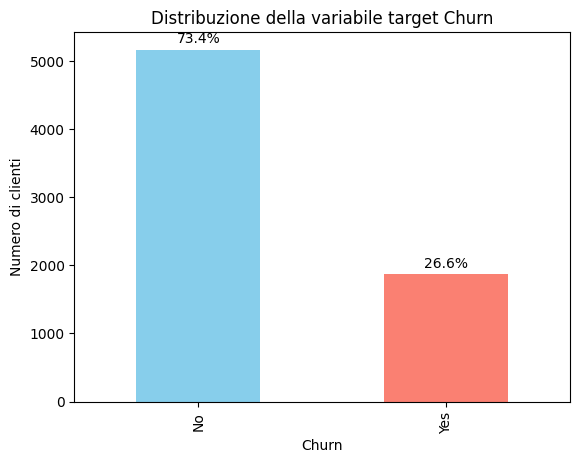

In [ ]:
import matplotlib.pyplot as plt

# Conta le occorrenze di ciascuna classe
churn_counts = df['Churn'].value_counts()
total = churn_counts.sum()

# Creo il grafico a barre
ax = churn_counts.plot(kind='bar', color=['skyblue', 'salmon'])

plt.title('Distribuzione della variabile target Churn')
plt.xlabel('Churn')
plt.ylabel('Numero di clienti')

# Aggiungo le percentuali sopra ogni barra
for i, count in enumerate(churn_counts):
    percent = count / total * 100
    ax.annotate(f'{percent:.1f}%', (i, count), textcoords="offset points", xytext=(0,5), ha='center')

plt.show()

In [ ]:
print(df['Churn'].unique())

['No' 'Yes']


In [ ]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [ ]:
# Traformo "SeniorCitizen" in una feature categorica, per coerenza
df.loc[:, 'SeniorCitizen'] = df['SeniorCitizen'].astype('category')

In [ ]:
# Troviamo tutte le colonne di tipo object
object_cols = df.select_dtypes(include='object').columns

# Converto tutte le colonne object in category
object_cols = df.select_dtypes(include='object').columns.drop('Churn', errors='ignore')
df[object_cols] = df[object_cols].apply(lambda col: col.astype('category'))

categorical = list(df.select_dtypes(include='category').columns)
numerical = list(df.select_dtypes(include=['int64', 'float64']).columns)

print("Feature categoriche:", categorical)
print("Feature numeriche:", numerical)

Feature categoriche: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Feature numeriche: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [ ]:
# Feature categoriche
categorical

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [ ]:
# Feature numeriche
numerical

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']

In [ ]:
# Seleziono solo le feature numeriche
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Calcolo la correlazione con Churn
correlations = df[numerical_features].corr()['Churn'].sort_values()

print(correlations)

tenure           -0.354049
TotalCharges     -0.199484
SeniorCitizen     0.150541
MonthlyCharges    0.192858
Churn             1.000000
Name: Churn, dtype: float64


<Axes: >

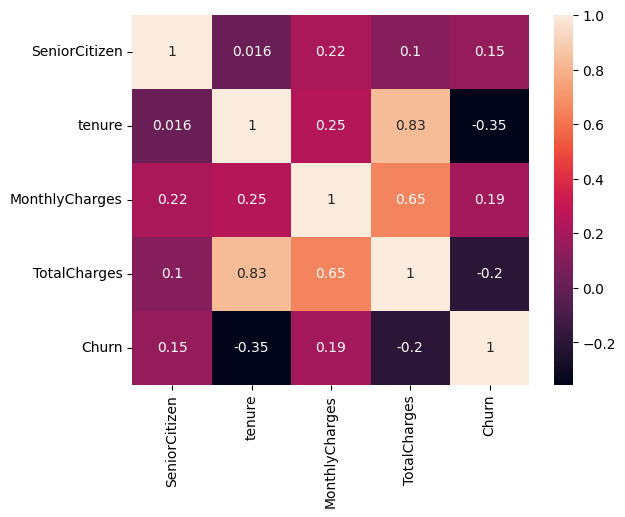

In [ ]:
import seaborn as sns
corr_num=df[numerical].corr()
sns.heatmap(corr_num,annot=True)

## Commento sulla correlazione delle feature numeriche con il churn

L'analisi della correlazione mostra che tutte le feature numeriche hanno un legame significativo con la variabile target `Churn`. In particolare, la durata del rapporto con l'azienda (`tenure`) presenta una correlazione negativa moderata (-0.35), indicando che clienti più longevi tendono a non abbandonare il servizio. Anche il totale degli addebiti (`TotalCharges`) e l'importo mensile (`MonthlyCharges`) mostrano correlazioni deboli ma rilevanti, rispettivamente negative (-0.20) e positive (0.19). Questi risultati suggeriscono di mantenere tutte le feature numeriche per la modellazione, poiché contribuiscono a spiegare il comportamento di abbandono.


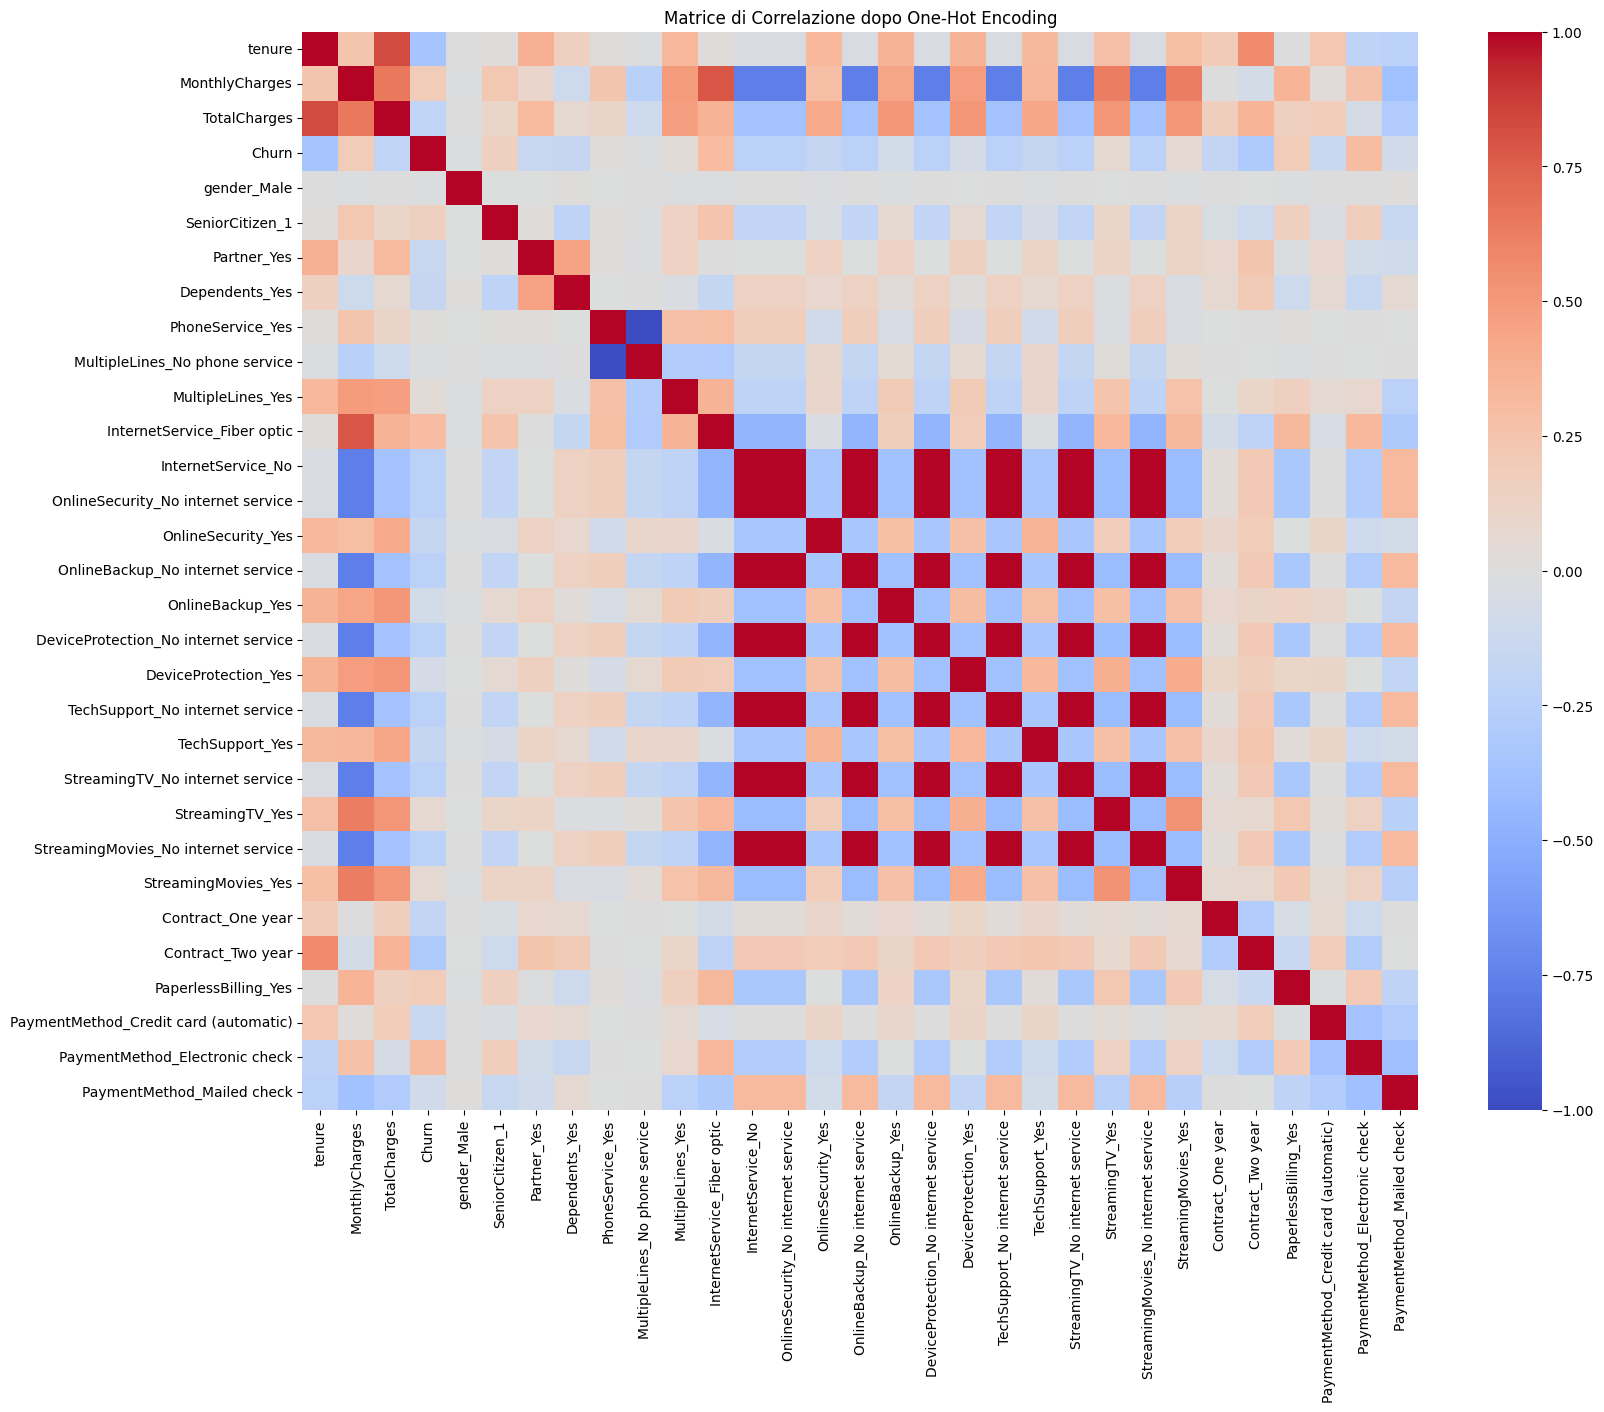

Top correlate (positive):
Churn                             1.000000
InternetService_Fiber optic       0.307463
PaymentMethod_Electronic check    0.301455
MonthlyCharges                    0.192858
PaperlessBilling_Yes              0.191454
SeniorCitizen_1                   0.150541
StreamingTV_Yes                   0.063254
StreamingMovies_Yes               0.060860
MultipleLines_Yes                 0.040033
PhoneService_Yes                  0.011691
Name: Churn, dtype: float64

Top correlate (negative):
TotalCharges                           -0.199484
InternetService_No                     -0.227578
StreamingTV_No internet service        -0.227578
OnlineSecurity_No internet service     -0.227578
OnlineBackup_No internet service       -0.227578
DeviceProtection_No internet service   -0.227578
StreamingMovies_No internet service    -0.227578
TechSupport_No internet service        -0.227578
Contract_Two year                      -0.301552
tenure                                 -0.354049

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

categorical = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

# One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical, drop_first=True)

# Conversione del target
df_encoded['Churn'] = pd.to_numeric(df_encoded['Churn'], errors='coerce')

# Matrice di correlazione
corr_matrix = df_encoded.corr()

# Heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Matrice di Correlazione dopo One-Hot Encoding')
plt.show()

# Correlazioni con 'Churn'
corr_with_churn = corr_matrix['Churn'].sort_values(ascending=False)
print("Top correlate (positive):")
print(corr_with_churn.head(10))
print("\nTop correlate (negative):")
print(corr_with_churn.tail(10))


## Analisi della Correlazione tra Feature e Churn

Dall'analisi della matrice di correlazione dopo l'One-Hot Encoding emergono alcune relazioni interessanti tra le variabili e la probabilità di abbandono del servizio (churn). Di seguito le considerazioni principali:

---

#### Feature **positivamente** correlate con il churn (cioè aumentano la probabilità di abbandono):

- **InternetService_Fiber optic** (+0.31): i clienti con fibra ottica tendono ad abbandonare più spesso, forse per aspettative elevate o problemi di prezzo/stabilità.
- **PaymentMethod_Electronic check** (+0.30): chi paga tramite assegno elettronico mostra un rischio di churn più alto, potenzialmente legato a clienti meno fidelizzati.
- **MonthlyCharges** (+0.19): bollette mensili più alte sono associate a maggiore probabilità di churn.
- **PaperlessBilling_Yes** (+0.19): chi riceve fatture digitali potrebbe essere più giovane o meno coinvolto nel rapporto con l’azienda.
- **SeniorCitizen_1** (+0.15): i clienti anziani risultano leggermente più inclini al churn.

---

#### Feature **negativamente** correlate con il churn (cioè riducono la probabilità di abbandono):

- **tenure** (−0.35): più a lungo un cliente rimane, meno è probabile che abbandoni.
- **Contract_Two year** (−0.30): contratti a lungo termine sono un forte deterrente al churn.
- **TotalCharges** (−0.20): una spesa complessiva più alta (associata alla fedeltà nel tempo) riduce il rischio.
- **InternetService_No** e altri servizi "No internet service" (−0.23): chi non usa servizi internet è spesso stabile o non coinvolto, e quindi meno soggetto a churn.

---

### Conclusione

Questi risultati possono guidare l’azienda nel:
- Individuare profili a rischio (es. alta spesa mensile, fibra, clienti nuovi)
- Personalizzare offerte o comunicazioni
- Fidelizzare clienti con contratti più lunghi o riduzione dei costi

La correlazione non implica causalità, ma fornisce una base solida per strategie di **retention mirata**.


## **Feature** **Engineering**

### `no_support_no_security`

Ho deciso di creare la nuova feature binaria `no_support_no_security` combinando due variabili categoriche esistenti:
- `TechSupport` = "No"
- `OnlineSecurity` = "No"

#### Obiettivo
L'intuizione è che un cliente che **non ha né supporto tecnico né sicurezza online** potrebbe:
- essere meno coinvolto nei servizi digitali offerti,
- percepire **minor valore** dall'abbonamento,
- e quindi avere una **maggiore probabilità di churn**.

Questa nuova feature permette di catturare un **effetto congiunto** che i modelli potrebbero non cogliere bene separatamente.

---


In [ ]:
df['no_support_no_security'] = ((df['TechSupport'] == 'No') & (df['OnlineSecurity'] == 'No')).astype(int)

### `charges_ratio`

Abbiamo creato una nuova feature numerica chiamata `charges_ratio`, calcolata come:

\[
\text{charges\_ratio} = \frac{\text{MonthlyCharges}}{\text{TotalCharges} + \varepsilon}
\]

dove \( \varepsilon = 10^{-5} \) serve a evitare divisioni per zero.

#### Obiettivo
Questa feature rappresenta il **rapporto tra il costo mensile attuale e il totale speso finora**. Un valore alto può indicare:
- un **cliente recente** (bassa `TotalCharges`) ma con un abbonamento costoso,
- oppure un **cliente a rischio churn**, che sta pagando molto ma ha poca "storia" con l'azienda.



In [ ]:
df['charges_ratio'] = df['MonthlyCharges'] / (df['TotalCharges'] + 1e-5)

###`FiberHighCost`

Ho deciso di creare la feature binaria `FiberHighCost` per identificare i clienti che:

- utilizzano il servizio **Internet in fibra ottica** (`InternetService = 'Fiber optic'`)
- e pagano **più della mediana** dei costi mensili (`MonthlyCharges`).

#### Obiettivo
Questa combinazione segnala i clienti con un abbonamento **più oneroso** e una tecnologia ad alte prestazioni. Sono spesso utenti più esigenti, con aspettative elevate e **potenzialmente più sensibili** al rapporto qualità/prezzo.


In [ ]:
df['FiberHighCost'] = ((df['InternetService'] == 'Fiber optic') & (df['MonthlyCharges'] > df['MonthlyCharges'].median())).astype(int)

### `StreamingUsersHighCost`

La feature `StreamingUsersHighCost` è una variabile binaria che segnala i clienti che:

- hanno attivo il servizio di **Streaming TV** (`StreamingTV = 'Yes'`)
- e sostengono **spese mensili superiori alla mediana** (`MonthlyCharges`).

#### Obiettivo
Individua i clienti che, oltre ai servizi base, utilizzano funzionalità aggiuntive (es. intrattenimento), con un profilo di spesa più elevato. Potrebbero essere soggetti a **churn se percepiscono il servizio come troppo costoso** o se non soddisfa le loro esigenze.

In [ ]:
df['StreamingUsersHighCost'] = ((df['StreamingTV'] == 'Yes') & (df['MonthlyCharges'] > df['MonthlyCharges'].median())).astype(int)

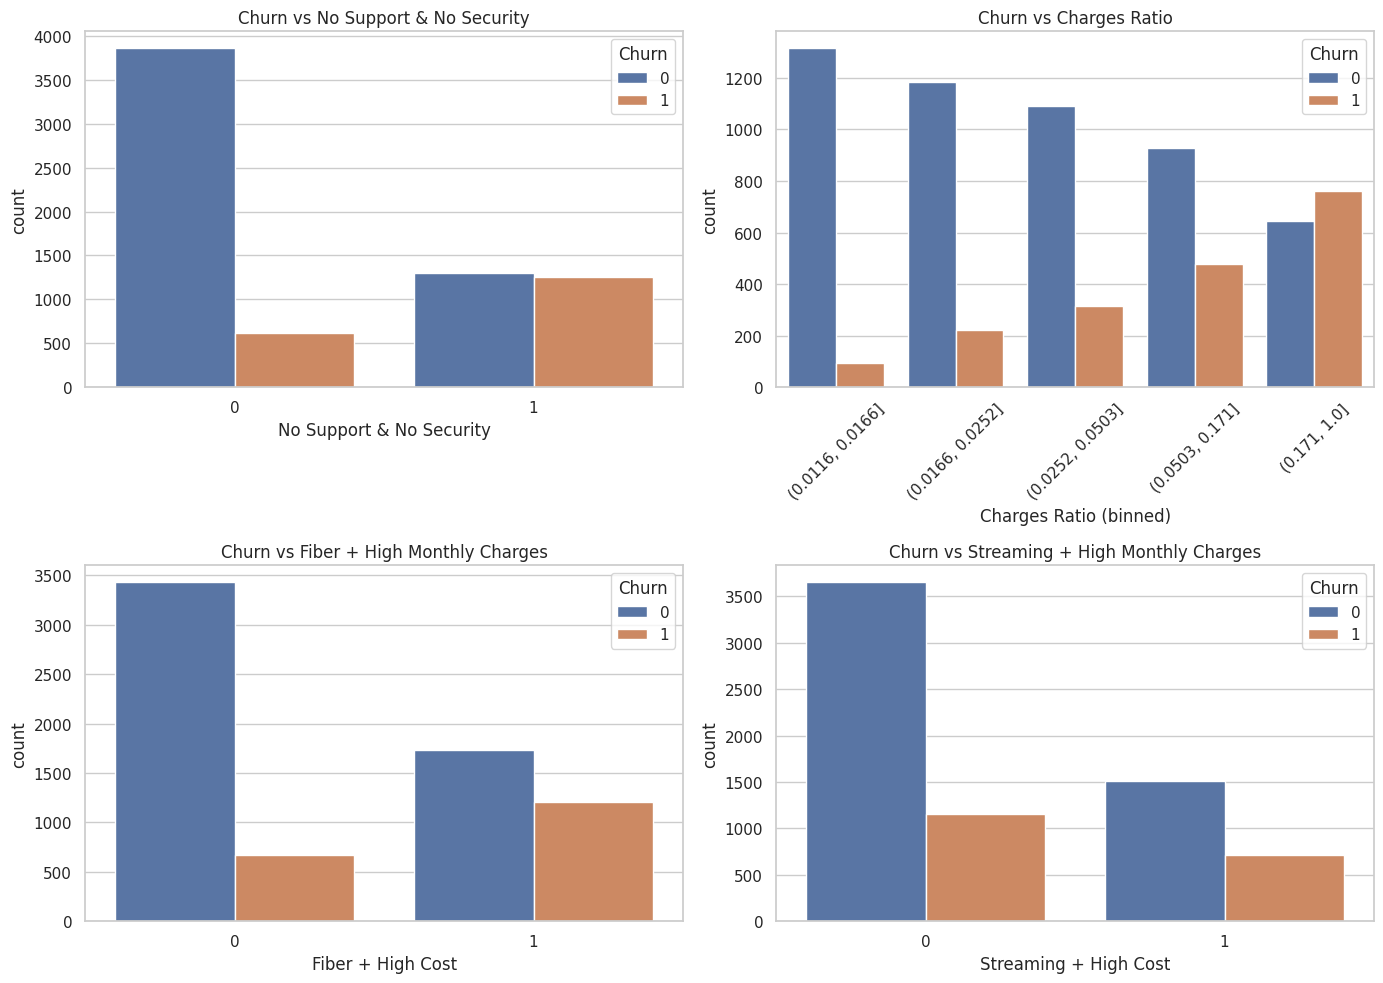

In [ ]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Istogramma: no_support_no_security vs Churn
sns.countplot(x='no_support_no_security', hue='Churn', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Churn vs No Support & No Security')
axes[0, 0].set_xlabel('No Support & No Security')

# Istogramma: charges_ratio vs Churn
df['charges_ratio_bin'] = pd.qcut(df['charges_ratio'], q=5)
sns.countplot(x='charges_ratio_bin', hue='Churn', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Churn vs Charges Ratio')
axes[0, 1].set_xlabel('Charges Ratio (binned)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Istogramma: FiberHighCost vs Churn
sns.countplot(x='FiberHighCost', hue='Churn', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Churn vs Fiber + High Monthly Charges')
axes[1, 0].set_xlabel('Fiber + High Cost')

# Istogramma: StreamingUsersHighCost vs Churn
sns.countplot(x='StreamingUsersHighCost', hue='Churn', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Churn vs Streaming + High Monthly Charges')
axes[1, 1].set_xlabel('Streaming + High Cost')

plt.tight_layout()
plt.show()

df.drop(columns='charges_ratio_bin', inplace=True)

### Analisi delle Nuove Feature rispetto al Churn

#### 1. `no_support_no_security`
Il grafico evidenzia che i clienti **senza supporto tecnico né sicurezza online** (valore 1) hanno una **percentuale di churn molto più alta** rispetto a chi dispone di almeno uno dei due servizi. Questo suggerisce che la mancanza di assistenza e protezione rappresenti un fattore di rischio importante.

#### 2. `charges_ratio` (binned)
All’aumentare del rapporto tra addebito mensile e spesa totale (`charges_ratio`), cresce anche la **proporzione di clienti churner**. I clienti con valori elevati sono spesso nuovi e con abbonamenti costosi: un **segmento ad alto rischio**.

#### 3. `FiberHighCost`
I clienti che utilizzano **fibra ottica con costi mensili superiori alla media** mostrano un churn visibilmente più elevato rispetto a chi non rientra in questa categoria. Questo conferma che **clienti ad alta spesa e alta velocità** sono anche più **esigenti e instabili**.

#### 4. `StreamingUsersHighCost`
I clienti che usano il **servizio di Streaming TV** e pagano più della media hanno una maggiore incidenza di churn. È probabile che siano utenti che cercano un alto valore aggiunto e siano **più propensi a cambiare servizio** se insoddisfatti.

---

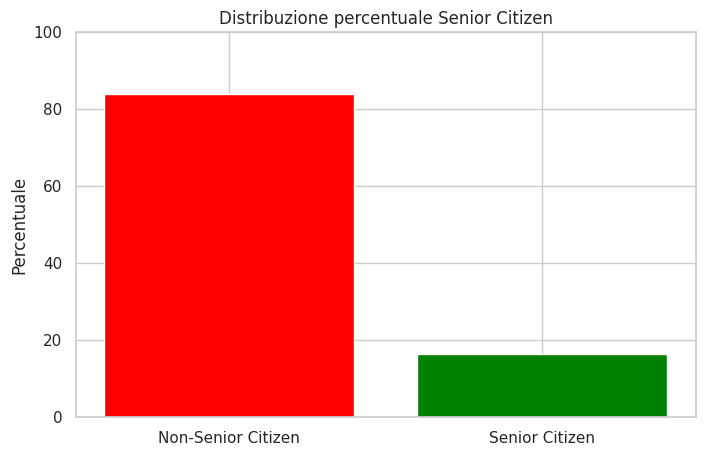

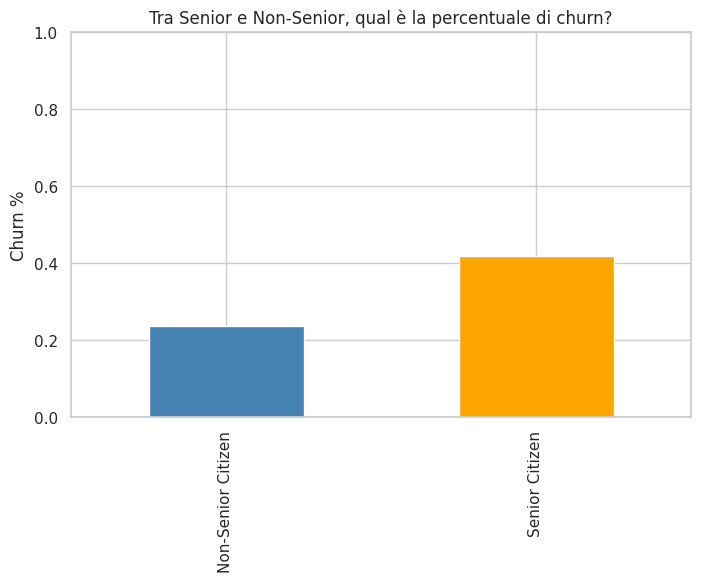

In [ ]:
import matplotlib.pyplot as plt

# Primo grafico: Distribuzione percentuale dei Senior Citizen
labels = ['Non-Senior Citizen', 'Senior Citizen']
counts = df['SeniorCitizen'].value_counts(normalize=True) * 100
colors = ['red', 'green']

plt.figure(figsize=(8,5))
plt.bar(labels, counts, color=colors)
plt.title('Distribuzione percentuale Senior Citizen')
plt.ylabel('Percentuale')
plt.ylim(0, 100)
plt.show()

# Secondo grafico: Percentuale di churn per categoria SeniorCitizen
churn_by_senior = df.groupby('SeniorCitizen')['Churn'].mean()

# Rinomino per chiarezza
churn_by_senior.index = ['Non-Senior Citizen', 'Senior Citizen']

plt.figure(figsize=(8,5))
churn_by_senior.plot(kind='bar', color=['steelblue', 'orange'])
plt.title('Tra Senior e Non-Senior, qual è la percentuale di churn?')
plt.ylabel('Churn %')
plt.ylim(0, 1)
plt.show()


### Osservazioni

- La maggior parte dei clienti nel dataset sono **Non-Senior Citizen** (oltre l'80%).
- Tra i clienti Senior Citizen, più del 40% ha abbandonato il servizio (churn), mentre tra i clienti più giovani la percentuale di churn è inferiore al 25%.
- Questo suggerisce che i Senior Citizen tendono ad abbandonare il servizio più frequentemente rispetto ai clienti più giovani.
- Di conseguenza, le variabili **SeniorCitizen** e **Churn** risultano correlate e meritano attenzione nell'analisi predittiva.


/tmp/ipython-input-38-1185535047.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate = df.groupby('Partner')['Churn'].mean() * 100


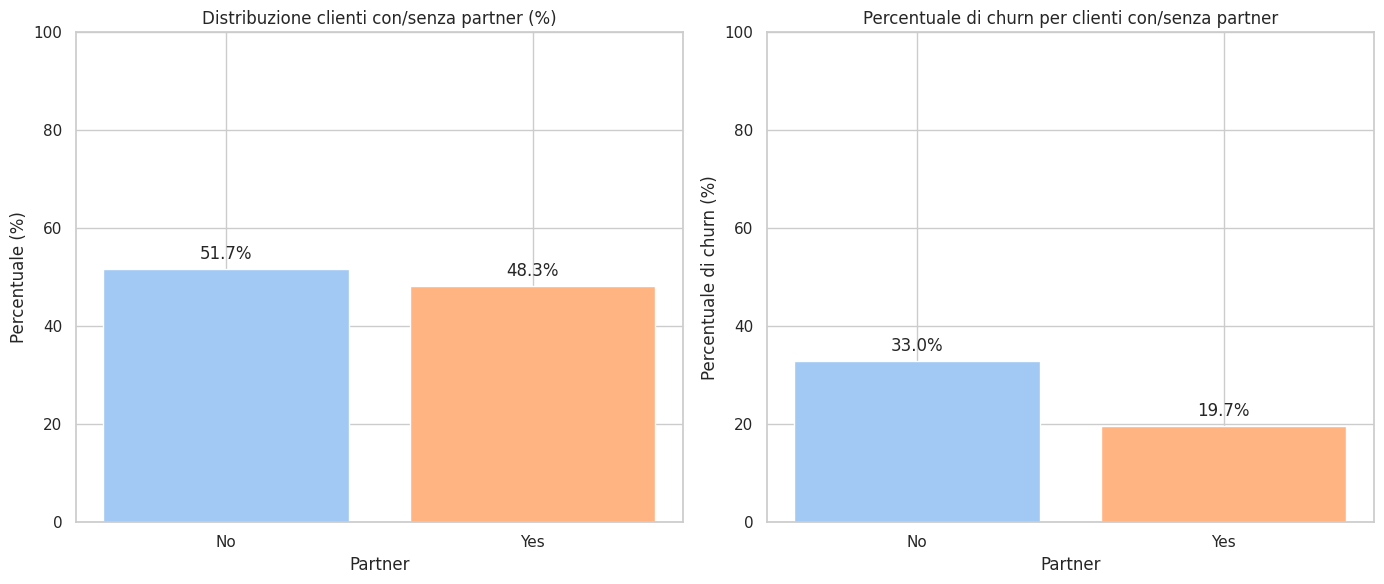

In [ ]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Primo grafico: percentuale clienti con/senza partner
partner_counts = df['Partner'].value_counts(normalize=True) * 100
partner_labels = partner_counts.index.tolist()
partner_values = partner_counts.values

axes[0].bar(partner_labels, partner_values, color=sns.color_palette('pastel'))
axes[0].set_title('Distribuzione clienti con/senza partner (%)')
axes[0].set_ylabel('Percentuale (%)')
axes[0].set_xlabel('Partner')
axes[0].set_ylim(0, 100)

# Annotazioni percentuali sopra le barre
for i, v in enumerate(partner_values):
    axes[0].text(i, v + 2, f"{v:.1f}%", ha='center')

# Secondo grafico: percentuale di churn per partner sì/no
churn_rate = df.groupby('Partner')['Churn'].mean() * 100
churn_labels = churn_rate.index.tolist()
churn_values = churn_rate.values

axes[1].bar(churn_labels, churn_values, color=sns.color_palette('pastel'))
axes[1].set_title('Percentuale di churn per clienti con/senza partner')
axes[1].set_ylabel('Percentuale di churn (%)')
axes[1].set_xlabel('Partner')
axes[1].set_ylim(0, 100)

# Annotazioni percentuali sopra le barre
for i, v in enumerate(churn_values):
    axes[1].text(i, v + 2, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.show()


> **Osservazioni:**
>
> Il dataset mostra una distribuzione quasi equa tra clienti che vivono da soli e clienti che vivono con un partner.
>
> I clienti che vivono da soli tendono ad abbandonare il servizio più frequentemente, con una percentuale di churn intorno al 35%, rispetto a circa il 20% per chi vive con un partner.


/tmp/ipython-input-39-1260474530.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate = df.groupby('Dependents')['Churn'].mean() * 100


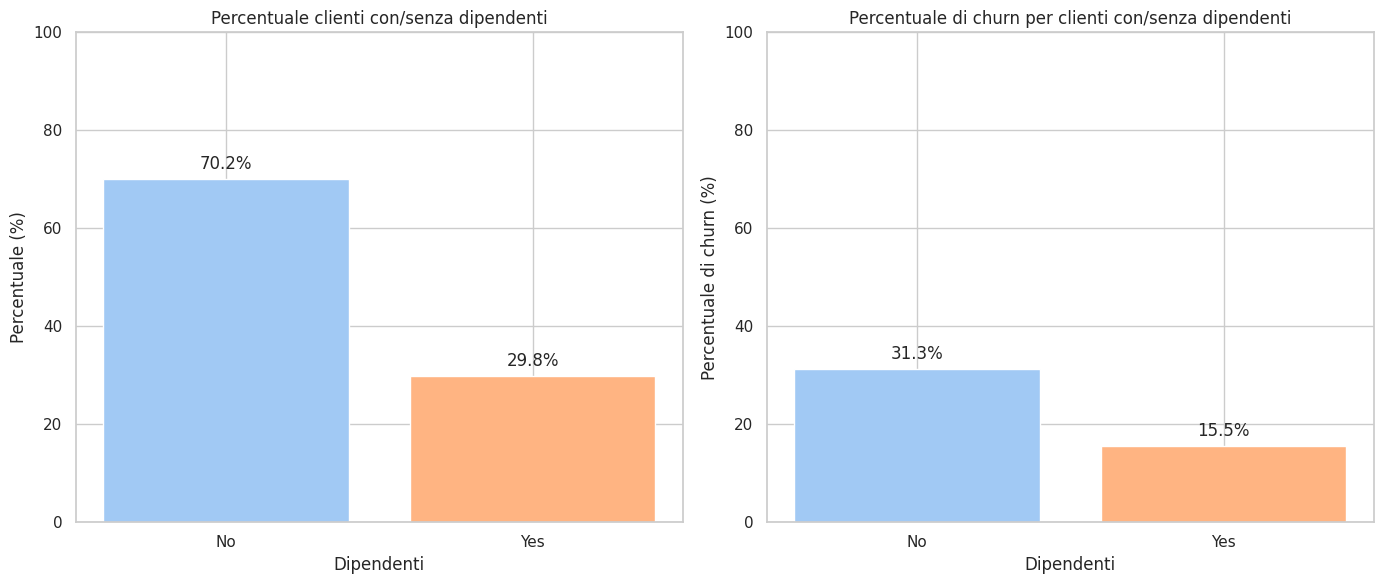

In [ ]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Grafico 1: percentuale clienti con/senza dipendenti
dependents_counts = df['Dependents'].value_counts(normalize=True) * 100
dependents_labels = dependents_counts.index.tolist()
dependents_values = dependents_counts.values

axes[0].bar(dependents_labels, dependents_values, color=sns.color_palette('pastel'))
axes[0].set_title('Percentuale clienti con/senza dipendenti')
axes[0].set_ylabel('Percentuale (%)')
axes[0].set_xlabel('Dipendenti')
axes[0].set_ylim(0, 100)

for i, v in enumerate(dependents_values):
    axes[0].text(i, v + 2, f"{v:.1f}%", ha='center')

# Grafico 2: percentuale di churn per clienti con/senza dipendenti
churn_rate = df.groupby('Dependents')['Churn'].mean() * 100
churn_labels = churn_rate.index.tolist()
churn_values = churn_rate.values

axes[1].bar(churn_labels, churn_values, color=sns.color_palette('pastel'))
axes[1].set_title('Percentuale di churn per clienti con/senza dipendenti')
axes[1].set_ylabel('Percentuale di churn (%)')
axes[1].set_xlabel('Dipendenti')
axes[1].set_ylim(0, 100)

for i, v in enumerate(churn_values):
    axes[1].text(i, v + 2, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.show()

### Osservazioni

- Il dataset contiene quasi il 70% di clienti che non hanno dipendenti a carico, mentre il 30% ne ha uno o più.
- I clienti senza dipendenti tendono ad abbandonare il servizio più frequentemente (~30% contro ~20%).
- Analizzando insieme i dati su Partner e Dipendenti, possiamo concludere che i clienti che sono single o indipendenti, cioè senza partner o dipendenti, tendono a lasciare più spesso il fornitore di servizi di comunicazione (CSP).
- Al contrario, i clienti con partner e/o dipendenti generalmente continuano a utilizzare lo stesso CSP.



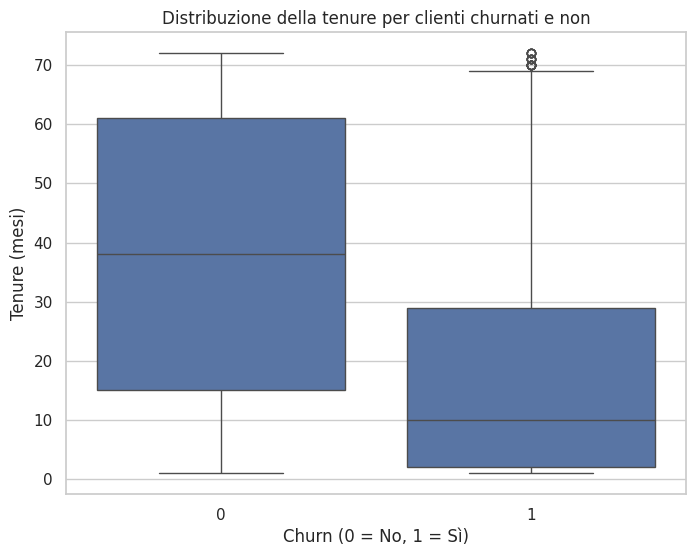

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Distribuzione della tenure per clienti churnati e non')
plt.xlabel('Churn (0 = No, 1 = Sì)')
plt.ylabel('Tenure (mesi)')
plt.show()

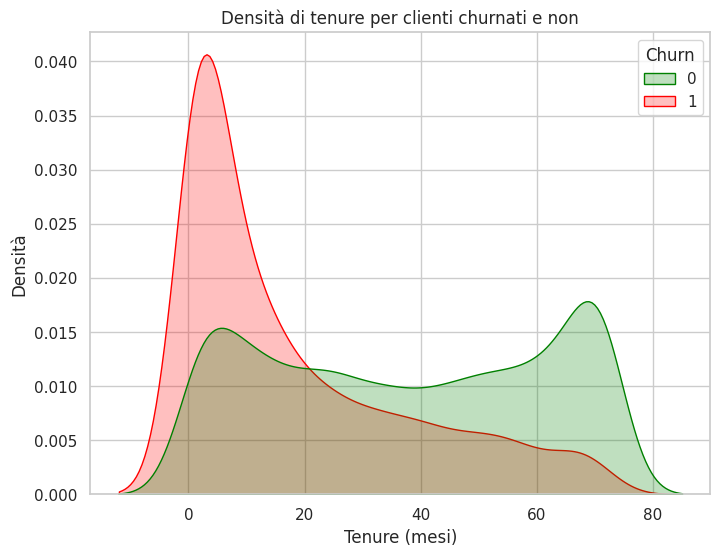

In [ ]:
plt.figure(figsize=(8,6))
sns.kdeplot(data=df, x='tenure', hue='Churn', fill=True, common_norm=False, palette=['green','red'])
plt.title('Densità di tenure per clienti churnati e non')
plt.xlabel('Tenure (mesi)')
plt.ylabel('Densità')
plt.show()

### Analisi della distribuzione della tenure in relazione al churn

Dal grafico emerge chiaramente che i clienti churnati (in rosso) tendono ad abbandonare il servizio nei primi mesi di utilizzo. In particolare, si osserva un picco netto di densità nei primi **10 mesi**, indicando che in questo intervallo temporale è **molto più probabile che un cliente se ne vada** rispetto ai periodi successivi.

Al contrario, i clienti che restano (in verde) mostrano una distribuzione più stabile nel tempo, con un aumento della densità nei mesi finali della tenure. Questo pattern suggerisce che la fase iniziale del ciclo di vita del cliente è **critica per la fidelizzazione**.

Intervenire con azioni mirate nei primi 10 mesi — come supporto personalizzato, onboarding efficace o incentivi — potrebbe contribuire in modo significativo a ridurre il tasso di churn.


/tmp/ipython-input-42-3200516516.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_contract = df.groupby(['tenure_years', 'Contract'])['Churn'].mean().reset_index()


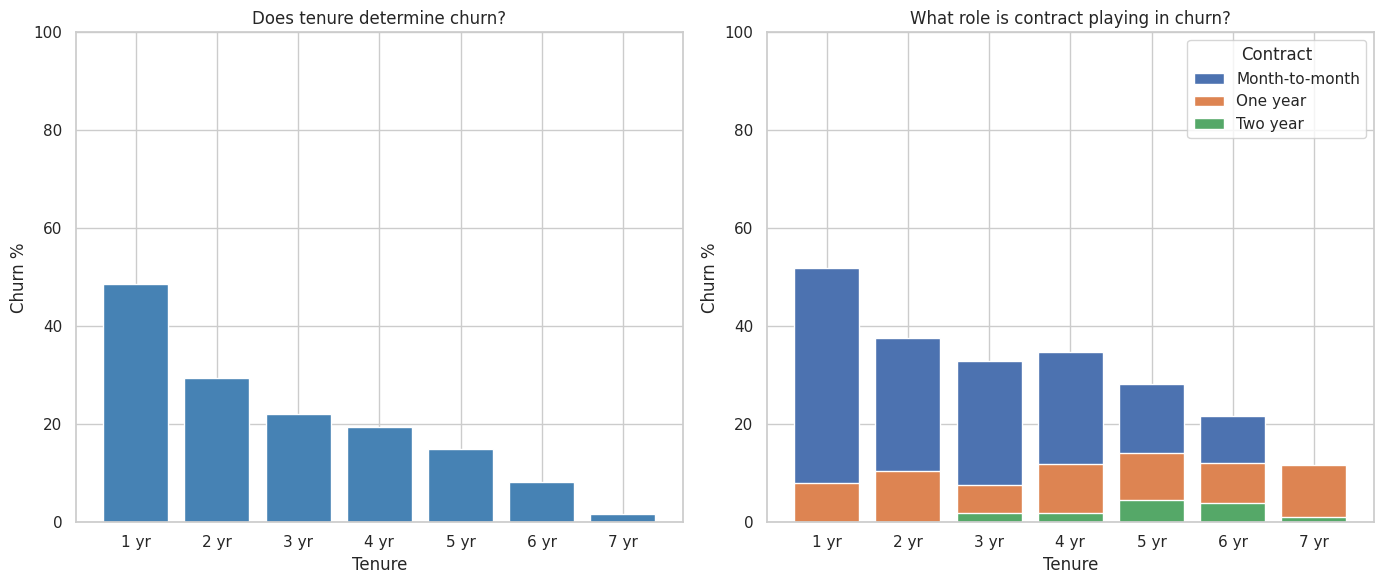

In [ ]:
# Creo una nuova colonna con la tenure arrotondata in anni
df['tenure_years'] = (df['tenure'] / 12).apply(lambda x: f"{int(x)+1} yr")

# Primo grafico: churn % per tenure
churn_by_tenure = df.groupby('tenure_years')['Churn'].mean().reset_index()
churn_by_tenure['Churn'] = churn_by_tenure['Churn'] * 100

# Secondo grafico: churn % per tenure e tipo di contratto
churn_contract = df.groupby(['tenure_years', 'Contract'])['Churn'].mean().reset_index()
churn_contract['Churn'] = churn_contract['Churn'] * 100

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Grafico 1: churn per tenure
axs[0].bar(churn_by_tenure['tenure_years'], churn_by_tenure['Churn'], color='steelblue')
axs[0].set_title('Does tenure determine churn?')
axs[0].set_xlabel('Tenure')
axs[0].set_ylabel('Churn %')
axs[0].set_ylim(0, 100)

# Grafico 2: churn per contract e tenure
for contract in churn_contract['Contract'].unique():
    subset = churn_contract[churn_contract['Contract'] == contract]
    axs[1].bar(subset['tenure_years'], subset['Churn'], label=contract)

axs[1].set_title('What role is contract playing in churn?')
axs[1].set_xlabel('Tenure')
axs[1].set_ylabel('Churn %')
axs[1].set_ylim(0, 100)
axs[1].legend(title='Contract')

plt.tight_layout()
plt.show()


### Analisi del churn in relazione a tenure e tipo di contratto

Nel primo grafico ("Does tenure determine churn?"), osserviamo che la percentuale di churn è **molto elevata durante il primo anno di permanenza**, e diminuisce progressivamente con l’aumentare della tenure. Questo conferma che i clienti sono più inclini ad abbandonare il servizio nei primi 12 mesi, evidenziando l’importanza di intervenire tempestivamente nella fase iniziale del ciclo di vita del cliente.

Nel secondo grafico ("What role is contract playing in churn?"), vediamo chiaramente che i clienti con contratto **month-to-month** mostrano tassi di churn molto più elevati rispetto a quelli con contratti annuali o biennali. Questo pattern è stabile nel tempo, suggerendo che **i contratti a lungo termine contribuiscono in modo significativo alla fidelizzazione** del cliente. Offrire incentivi per passare da un contratto mensile a uno annuale o biennale potrebbe quindi essere una strategia efficace per ridurre il churn.


/tmp/ipython-input-43-4075385110.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_contract = df.groupby('Contract')['Churn'].mean() * 100


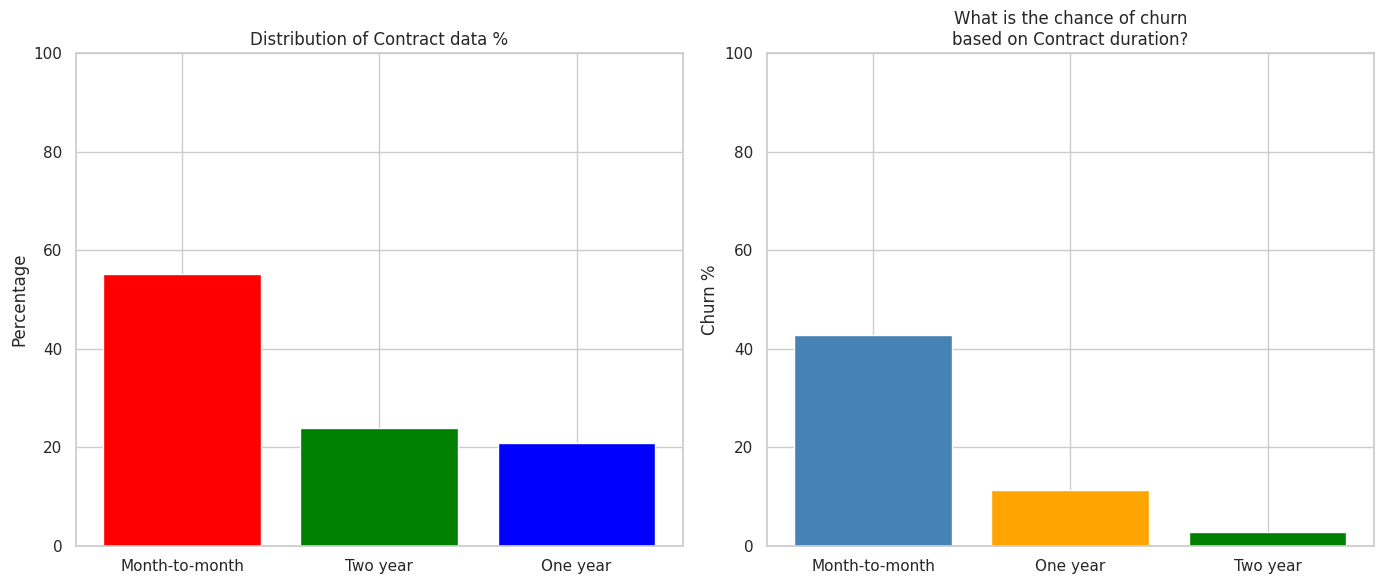

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Calcolo percentuale di distribuzione dei contratti
contract_distribution = df['Contract'].value_counts(normalize=True) * 100

# Calcolo churn medio per tipo di contratto
churn_by_contract = df.groupby('Contract')['Churn'].mean() * 100

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Grafico 1: distribuzione dei contratti
axs[0].bar(contract_distribution.index, contract_distribution.values, color=['red', 'green', 'blue'])
axs[0].set_title('Distribution of Contract data %')
axs[0].set_ylabel('Percentage')
axs[0].set_ylim(0, 100)

# Grafico 2: churn medio per tipo di contratto
axs[1].bar(churn_by_contract.index, churn_by_contract.values, color=['steelblue', 'orange', 'green'])
axs[1].set_title('What is the chance of churn\nbased on Contract duration?')
axs[1].set_ylabel('Churn %')
axs[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()


### Contratto e churn: distribuzione e impatto

Nel primo grafico ("Distribution of Contract data %") vediamo che la maggior parte dei clienti ha un contratto **month-to-month**, mentre i contratti annuali e biennali sono significativamente meno diffusi. Questo tipo di contratto flessibile potrebbe spiegare una maggiore propensione al churn.

Il secondo grafico ("What is the chance of churn based on Contract duration?") conferma infatti che i clienti con contratto **month-to-month** hanno una percentuale di churn nettamente più alta rispetto a chi ha sottoscritto un contratto **annual** o **biennal**. I contratti a lungo termine sono associati a una maggiore fidelizzazione, suggerendo che incentivi a passare da contratti mensili a formule più lunghe potrebbero ridurre il churn.


/tmp/ipython-input-44-3157553801.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  billing_churn = df.groupby('PaperlessBilling')['Churn'].mean() * 100


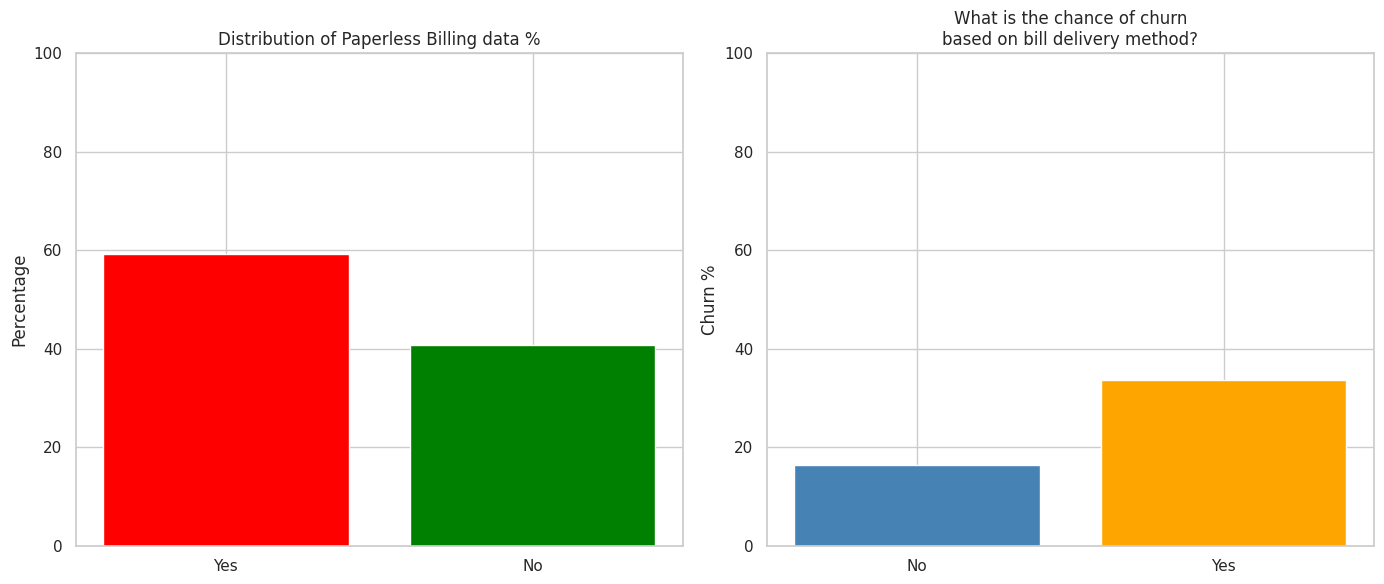

In [ ]:
# Calcolo distribuzione (percentuale) paperless billing
billing_dist = df['PaperlessBilling'].value_counts(normalize=True) * 100

# Calcolo churn medio per tipo di fatturazione
billing_churn = df.groupby('PaperlessBilling')['Churn'].mean() * 100

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Grafico 1: distribuzione PaperlessBilling
axs[0].bar(billing_dist.index, billing_dist.values, color=['red', 'green'])
axs[0].set_title('Distribution of Paperless Billing data %')
axs[0].set_ylabel('Percentage')
axs[0].set_ylim(0, 100)

# Grafico 2: churn per PaperlessBilling
axs[1].bar(billing_churn.index, billing_churn.values, color=['steelblue', 'orange'])
axs[1].set_title('What is the chance of churn\nbased on bill delivery method?')
axs[1].set_ylabel('Churn %')
axs[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

### Fatturazione elettronica e churn

Nel primo grafico osserviamo che circa il **60% dei clienti ha attivato la fatturazione elettronica (Paperless Billing = Yes)**, mentre il restante 40% continua a ricevere le fatture in formato cartaceo.

Nel secondo grafico notiamo un’informazione interessante: **i clienti con fatturazione elettronica mostrano un tasso di churn significativamente più alto** rispetto a quelli che ricevono la fattura cartacea. Questo potrebbe suggerire che la scelta del canale digitale sia correlata a un minor grado di fidelizzazione, forse perché questi clienti sono più abituati alla gestione autonoma e meno legati al servizio.

Sarebbe utile approfondire questa relazione, per esempio valutando se il metodo di pagamento o altri fattori digitali contribuiscono al churn.


/tmp/ipython-input-45-1118632069.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_internet = df.groupby('InternetService')['Churn'].mean() * 100


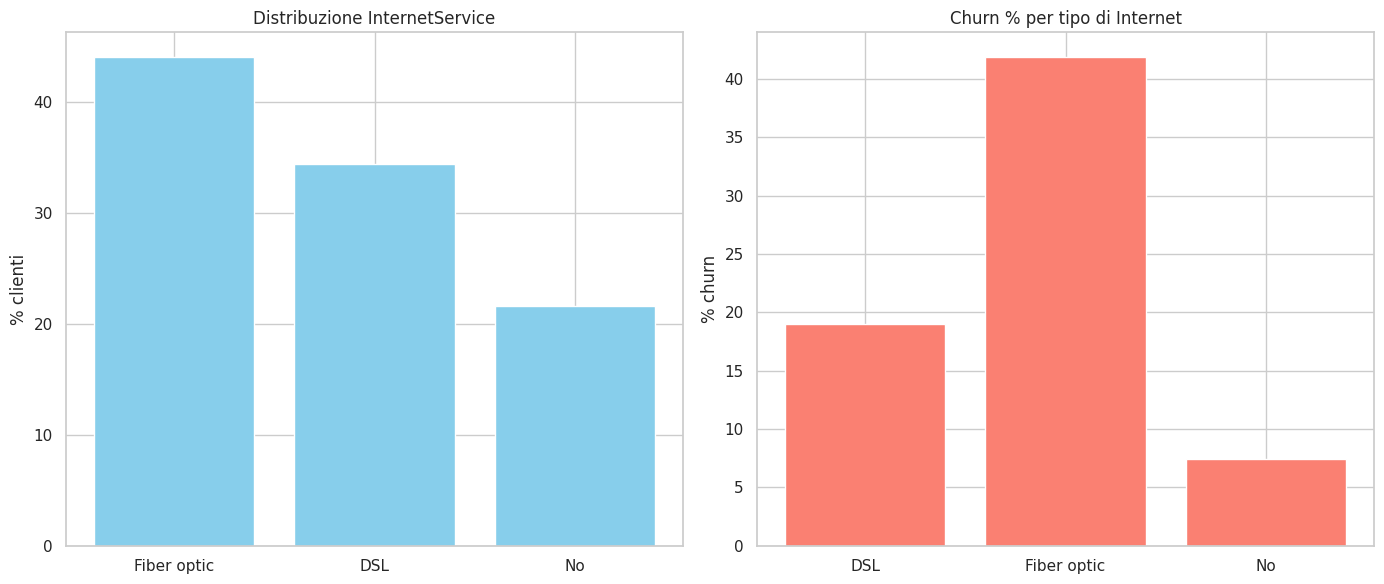

In [ ]:
churn_by_internet = df.groupby('InternetService')['Churn'].mean() * 100
count_by_internet = df['InternetService'].value_counts(normalize=True) * 100

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].bar(count_by_internet.index, count_by_internet.values, color='skyblue')
axs[0].set_title('Distribuzione InternetService')
axs[0].set_ylabel('% clienti')

axs[1].bar(churn_by_internet.index, churn_by_internet.values, color='salmon')
axs[1].set_title('Churn % per tipo di Internet')
axs[1].set_ylabel('% churn')

plt.tight_layout()
plt.show()


### Internet Service e Churn

Il grafico mostra che la maggior parte dei clienti utilizza il servizio **Fiber optic**, seguito da DSL e infine da coloro che non hanno un servizio internet.

Tuttavia, osservando la percentuale di churn, emerge chiaramente che **i clienti con fibra ottica abbandonano il servizio molto più frequentemente** rispetto a quelli con DSL o senza internet. Questo potrebbe indicare che, pur essendo una tecnologia avanzata, la fibra è associata a clienti più esigenti o che sperimentano problemi tecnici o di costo percepito.


/tmp/ipython-input-46-2243174222.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_charge = df.groupby('MonthlyCharges_group')['Churn'].mean() * 100


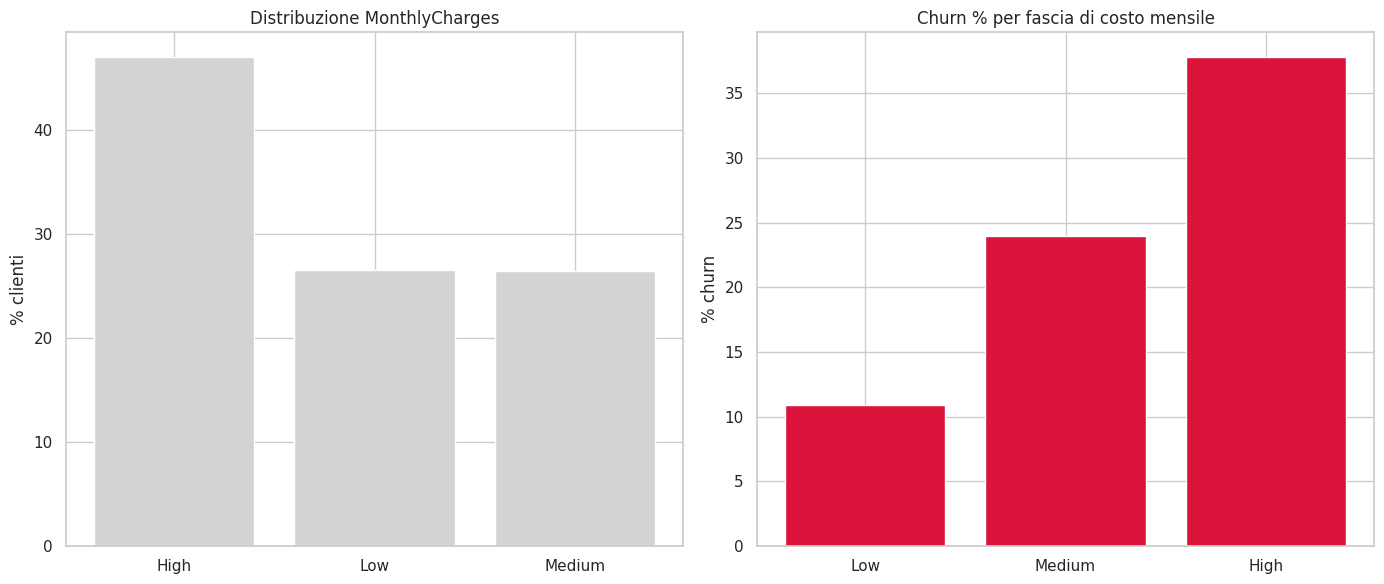

In [ ]:
df['MonthlyCharges_group'] = pd.cut(df['MonthlyCharges'], bins=[0, 35, 70, 105], labels=['Low', 'Medium', 'High'])

churn_by_charge = df.groupby('MonthlyCharges_group')['Churn'].mean() * 100
count_by_charge = df['MonthlyCharges_group'].value_counts(normalize=True) * 100

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].bar(count_by_charge.index, count_by_charge.values, color='lightgray')
axs[0].set_title('Distribuzione MonthlyCharges')
axs[0].set_ylabel('% clienti')

axs[1].bar(churn_by_charge.index, churn_by_charge.values, color='crimson')
axs[1].set_title('Churn % per fascia di costo mensile')
axs[1].set_ylabel('% churn')

plt.tight_layout()
plt.show()

### Spesa Mensile e Churn

Ho deciso di suddividere la spesa mensile in tre fasce: bassa, media e alta.

Il churn aumenta visibilmente con l’aumentare dei costi mensili. **I clienti con spese elevate hanno il churn più alto**, probabilmente a causa della percezione di un costo eccessivo rispetto al valore ricevuto, o per la presenza di servizi opzionali inutilizzati ma attivati.


In [ ]:
# Rimuovo colonne non necessarie
df_model = df.drop(columns=['tenure_years', 'MonthlyCharges_group'])

In [ ]:
# Individuo tutte le feature categoriche
categorical = df_model.select_dtypes(include='category').columns.tolist()
categorical

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [ ]:
# One-hot encoding
df_encoded = pd.get_dummies(df_model, columns=categorical, drop_first=True)

In [ ]:
X = df_encoded.drop('Churn', axis=1) # feature
y = df_encoded['Churn'] # target

In [ ]:
from sklearn.model_selection import train_test_split

X_train_ch, X_test_ch, y_train_ch, y_test_ch = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
from imblearn.combine import SMOTEENN
smote = SMOTEENN(random_state=42)
X_train_res_ch, y_train_res_ch = smote.fit_resample(X_train_ch, y_train_ch)

from collections import Counter
print("Distribuzione originale:", Counter(y_train_ch))
print("Dopo SMOTE:", Counter(y_train_res_ch))

Distribuzione originale: Counter({0: 3614, 1: 1308})
Dopo SMOTE: Counter({1: 2172, 0: 1886})


# Gabriele Fronzoni


---
# Dataset - indicatori di salute per individuare la presenza di diabete

Il dataset in questione si riferisce al *Behavioral Risk Factor Surveillance System (BRFSS)*, che è un sondaggio telefonico che viene svolto annualmente negli Stati Uniti dal *Center of Disease Control and Prevention (CDC)*. Per questo dataset, sono stati presi di riferimento i dati del 2015.

In [7]:
path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/diabetes-health-indicators-dataset


In [8]:
data_diabete = pd.read_csv(path + "/diabetes_binary_health_indicators_BRFSS2015.csv")
data_diabete.head(5)

Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1              0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2              0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3              0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4              0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      15.0       1.0  0.0   9.0        4.0   
1          1.0      3.0       0.0       0.0       0.0  0.0   7.0        6.0   
2          1.0      5.0      30.0      30.0       1.0  0.0   9.0        4.0   
3          0.0      2.0       0.0       0.0       0.0  0.0  11.0        3.0   
4          0.0      2.0       3.0       0.0       0.0  0.0  11.0        5.0   

   Income  
0     3.0  
1     1.0  
2     8.0  
3     6.0  
4     4.0  

[5 rows x 22 columns]

## Struttura del dataset

Vediamo di seguito quelle che sono le features presenti:


  1.   `Diabetes_binary`: variabile booleana che indica se la persona sia diabetica;
  2.   `HighBP`: variabile booleana che indica se la persona ha la pressione del sangue alta;
  3. `HighChol`: variabile booleana che indica se la persona ha il colesterolo alto;
  4. `CholCheck`: variabile booleana che indica se la persona ha fatto un controllo del colesterolo negli ultimi 5 anni;
  5. `BMI`: indica l'indice di massa corporea (BMI) della persona;
  6. `Smoker`: variabile booleana indica se la persona ha fumato almeno 100 sigarette nella sua vita;
  7. `Stroke`: variabile booleana che indica se la persona ha mai avuto un infarto;
  8. `HeartDiseaseorAttack`: variabile booleana che indica la presenza nella persona di cardiopatie congenite (CHD) oppure di infarto miocardico (MI);
  9. `PhysActivity`: variabile booleana che indica se la persona ha effettuato attività fisica negli ultimi 30 giorni (non è incluso il lavoro);
  10. `Fruits`: variabile booleana che indica se la persona consuma frutta una o più volte al giorno;
  11. `Veggies`: variabile booleana che indica se una persona consuma verdura una o più volte al giorno;
  12. `HvyAlcoholConsump`: variabile booleana che indica se la persona abbia un consumo di alchool elevato (per gli uomini adulti >= 14 drink alla settimana e per le donne adulte >= 7 drink alla settimana);
  13. `AnyHealthcare`: variabile booleana che indica se la persona avesse un qualsiasi tipo di assicurazione sanitaria;
  14. `NoDocbcCost`: variabile booleana che indica se la persona abbia avuto di consultare un dottore nell'ultimo anno, ma non lo ha fatto a causa dei costi;
  15. `GenHlth`: si tratta del valore di stato di salute in una scala da 1 a 5, dove 1 è eccellente e 5 è molto scarso;
  16. `MentHlth`: indica i giorni di depressione che la persona ha vissuto negli ultimi 30 giorni;
  17. `PhysHlth`: indica i giorni in cui si è stati male fisicamente o si sono sofferti infortuni negli ultimi 30 giorni;
  18. `DiffWalk`: variabile booleana che indica se la persona abbia difficoltà nel camminare o nel salire le scale;
  19. `Sex`: variabile booleana che indica il sesso della persona (0 - donna, 1 - uomo);
  20. `Age`: età della persona. La variabile ha valori che vanno da 1 a 13. Ognuno di questi valori indica una fascia di età, con 1 = 18-24 e 13 = 80 a più. Ogni fascia comprende 5 anni.
  21. `Education`: indica il livello di istruzione della persona. La variabile assume valori compresi tra 1 e 6 dove: 1 = mai frequentato una scuola, 2 = scuola elementare, 3 = frequenta scuola superiore, 4 = diplomato, 5 = frequenta l'università e 6 = laureato.
  22. `Income`: indica il reddito annuo della persona. La variabile assume valori compresi tra 1 e 8 dove: 1 = reddito < 10.000, 2 = reddito < 15.000, 3 = reddito < 20.000, 4 = reddito < 25.000, 5 = reddito < 35.000, 6 = reddito < 50.000, 7 = reddito < 75.000, 8 = reddito >= 75.000.

Di tutte queste features, la variabile target è la prima, ovvero `Diabetes_binary`.


In [9]:
data_diabete.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

Per prima cosa, tutte le variabili booleane vengono indicate con tipo *bool*. `GenHlth`, `Age`, `Education` e `Income` vengono invece trattate come variabili di  tipo *category*. `MentHlth` e `PhysHlth` vengono invece trattate come variabili *int*, mentre `BMI` come *float*.

In [10]:

boolean_cols = [
    'Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
    'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex'
]
for col in boolean_cols:
    data_diabete[col] = data_diabete[col].astype(bool)

categorical_cols = ['GenHlth', 'Age', 'Education', 'Income']
for col in categorical_cols:
    data_diabete[col] = data_diabete[col].astype('category')

int_cols = ['MentHlth', 'PhysHlth']
for col in int_cols:
  data_diabete[col] = data_diabete[col].astype('int')

print(data_diabete.info(memory_usage="deep"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Diabetes_binary       253680 non-null  bool    
 1   HighBP                253680 non-null  bool    
 2   HighChol              253680 non-null  bool    
 3   CholCheck             253680 non-null  bool    
 4   BMI                   253680 non-null  float64 
 5   Smoker                253680 non-null  bool    
 6   Stroke                253680 non-null  bool    
 7   HeartDiseaseorAttack  253680 non-null  bool    
 8   PhysActivity          253680 non-null  bool    
 9   Fruits                253680 non-null  bool    
 10  Veggies               253680 non-null  bool    
 11  HvyAlcoholConsump     253680 non-null  bool    
 12  AnyHealthcare         253680 non-null  bool    
 13  NoDocbcCost           253680 non-null  bool    
 14  GenHlth               253680 non-nul

Per prima cosa, viene fatto un controllo su quelli che sono i possibili valori nulli all'interno del dataset:

In [11]:
data_diabete.isna().sum()

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

Come si può evincere, all'interno del dataset non sono presenti valori nulli.

## Esplorazione del dataset
Per prima cosa, analizziamo la distribuzione della variabile target:

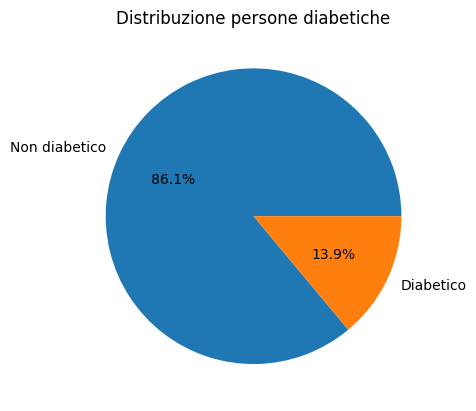

In [12]:
ax = data_diabete['Diabetes_binary'].value_counts().plot.pie(autopct="%1.1f%%", labels=["Non diabetico", "Diabetico"], title="Distribuzione persone diabetiche")
ax.set_ylabel('')
plt.show()

Possiamo vedere come il datase scelto sia fortemente sbilanciato, aspetto che sarà da gestire opportunamente in fase di training dei modelli.

Andiamo anche ad eliminare quelli che sono i record duplicati

In [13]:
data_diabete.duplicated().sum()
data_diabete.drop_duplicates(inplace = True)

Per le variabili binarie, mostriamo come i valori True e False si distribuiscono in base alla presenza o meno di diabete:

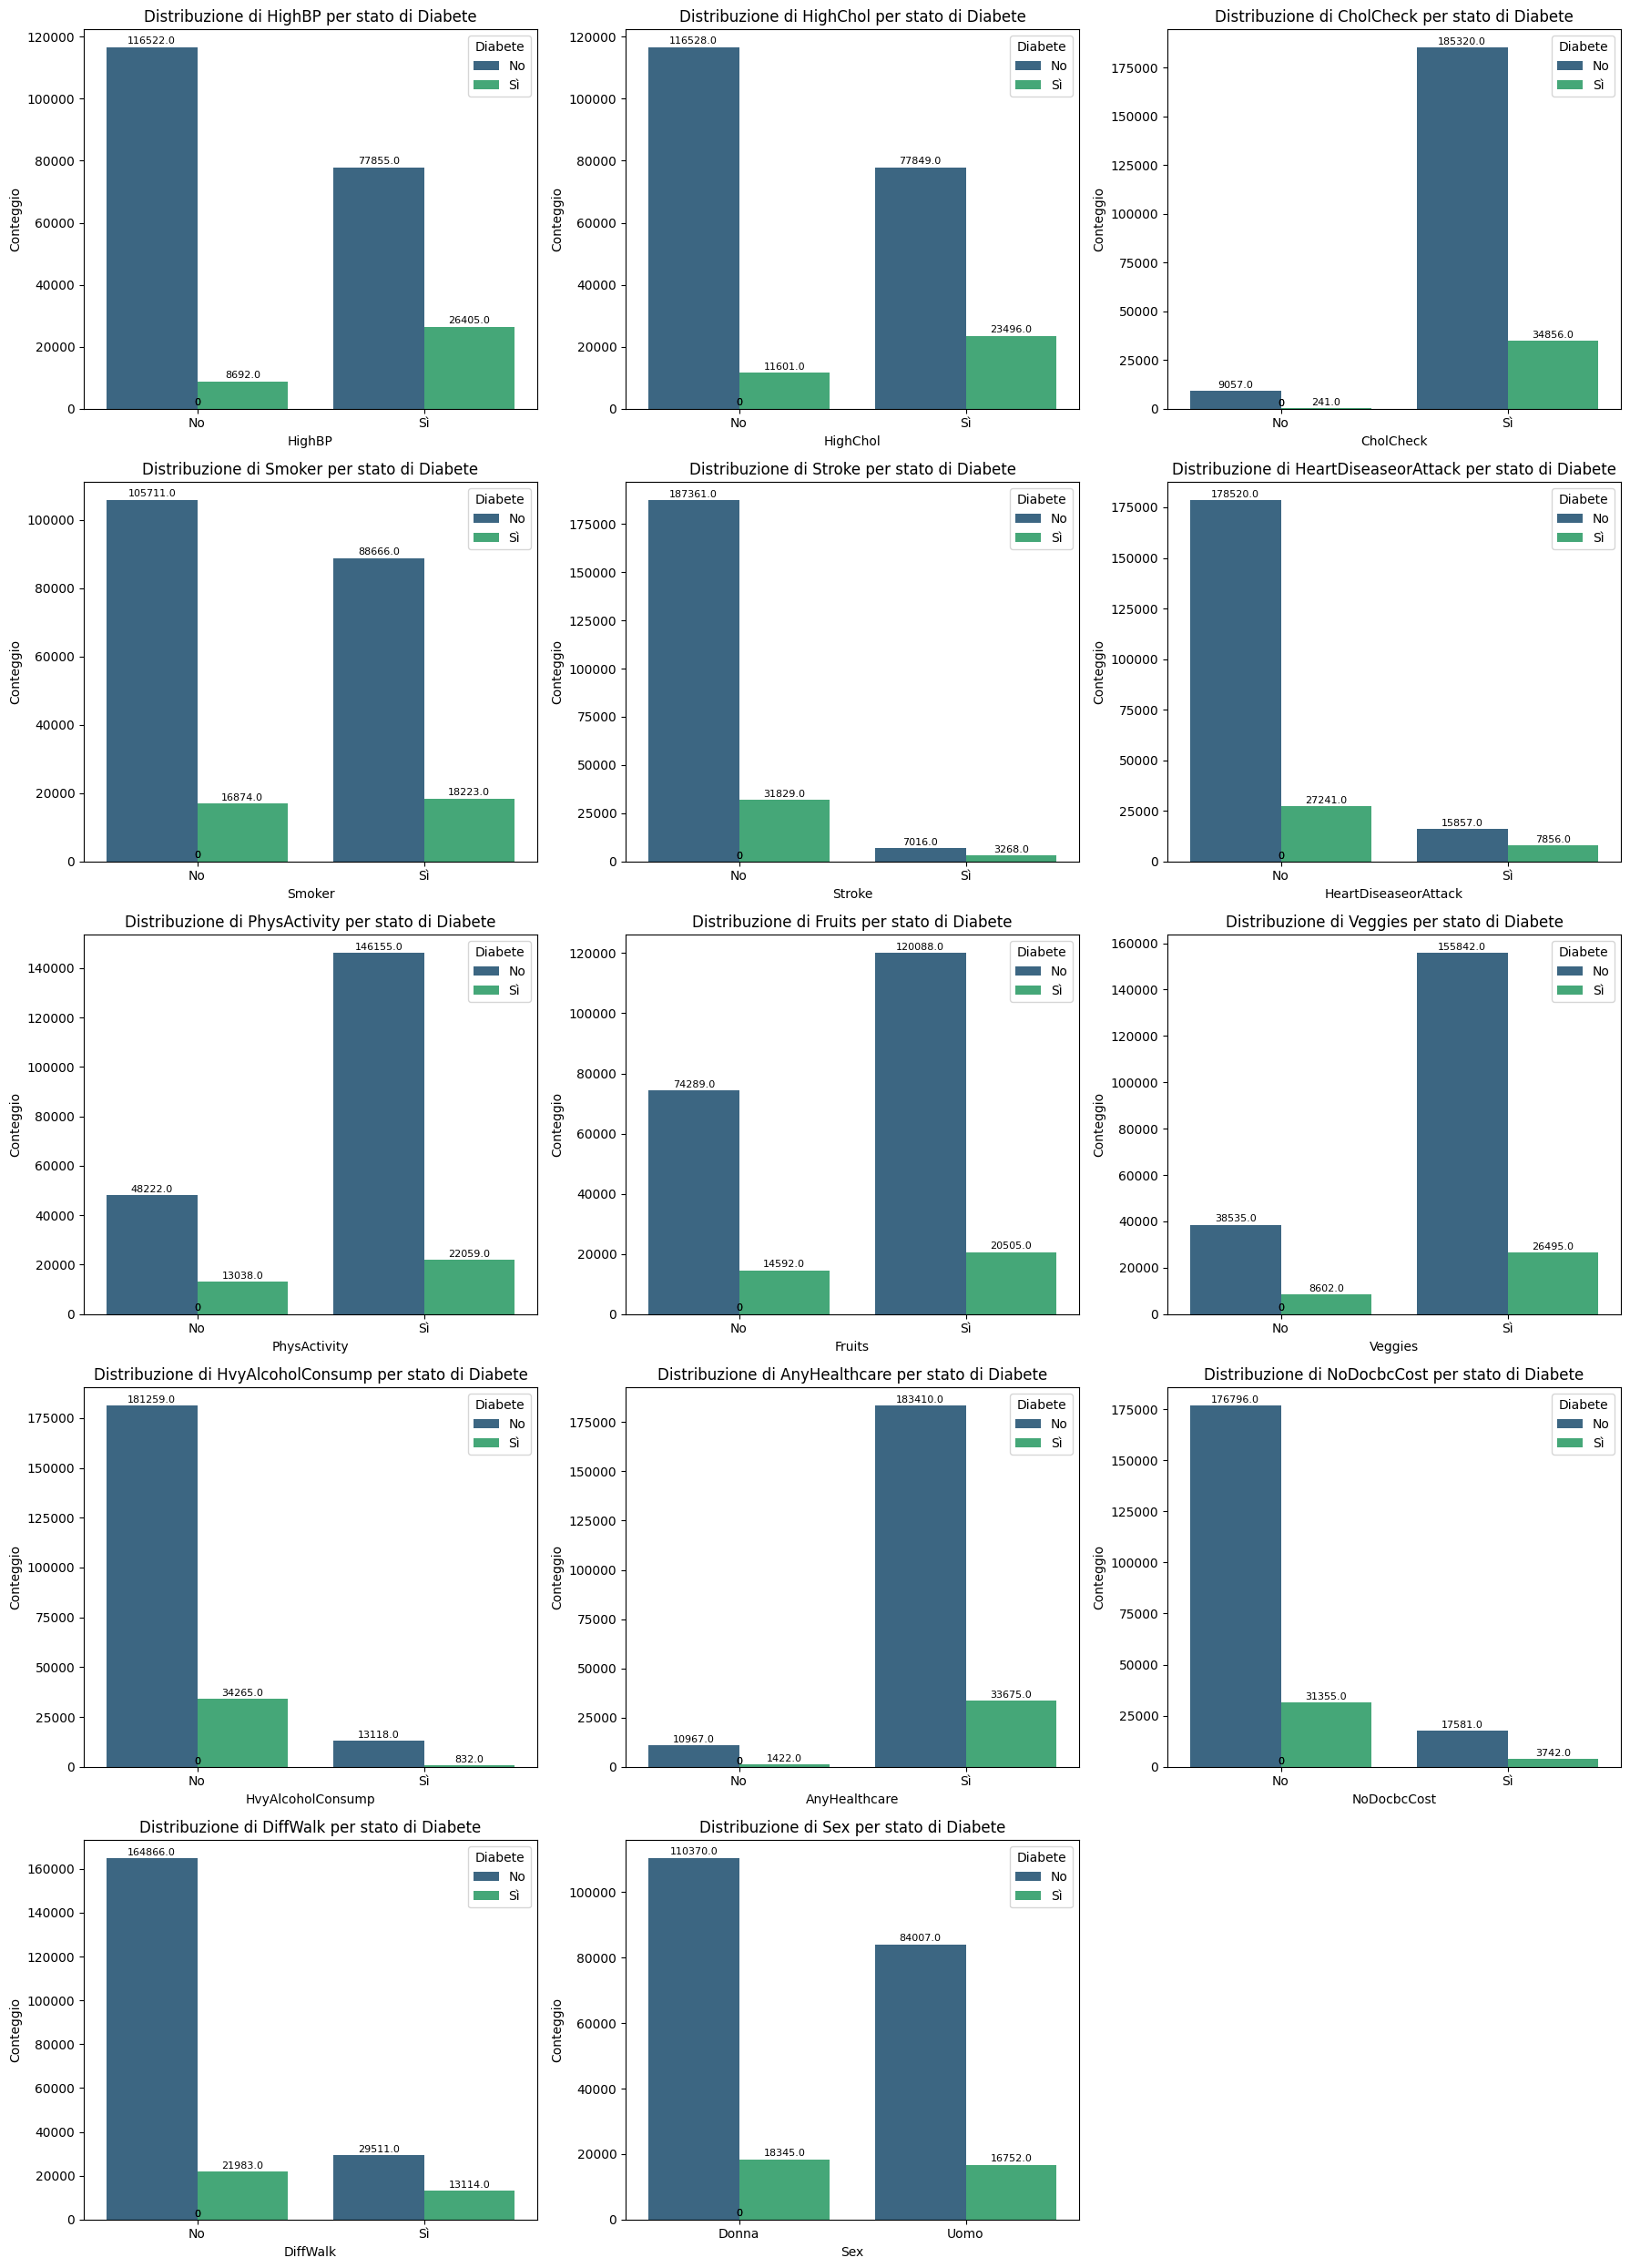

In [14]:

import matplotlib.pyplot as plt
binary_cols_for_plot = [col for col in boolean_cols if col != 'Diabetes_binary']

n_cols_binary = len(binary_cols_for_plot)
n_rows_binary = (n_cols_binary + 1) // 3

fig, axes = plt.subplots(n_rows_binary, 3, figsize=(18, n_rows_binary * 5))
axes = axes.flatten()

# Itero sulle colonne binarie per creare gli istogrammi
for i, col in enumerate(binary_cols_for_plot):
    sns.countplot(data=data_diabete, x=col, hue='Diabetes_binary', ax=axes[i], palette='viridis')

    axes[i].set_title(f'Distribuzione di {col} per stato di Diabete', fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Conteggio', fontsize=10)
    axes[i].set_xticks([0, 1])
    if(col == "Sex"):
      axes[i].set_xticklabels(['Donna', 'Uomo'])
    else:
      axes[i].set_xticklabels(['No', 'Sì'])

    axes[i].legend(title='Diabete', labels=['No', 'Sì'])

    for p in axes[i].patches:
        height = p.get_height()
        axes[i].text(p.get_x() + p.get_width()/2., height + 500, f'{height}', ha='center', va='bottom', fontsize=8)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Le osservazioni interessanti che derivano da questi grafici sono:
* Quasi la metà delle persone che hanno il diabete, hanno avuto un infarto, mentre per le persone non diabetiche questo rapporto scende ad 1/6 dei casi;
* Si nota come l'assenza di attività fisica sia legata alla presenza di diabete, in quanto le persone diabetiche sono in proporzione di più nel caso non si pratichi alcun tipo di attività fisica;
* Analogo discorso del punto precedente si può fare nelle difficoltà a muoversi, per cui le persone che ne soffrono sono più propense al diabete;
* Il sesso della persona non sembra influenzare particolarmente la presenza di diabete.

Vediamo invece con dei grafici ad istogramma la distribuzione delle altre variabili:

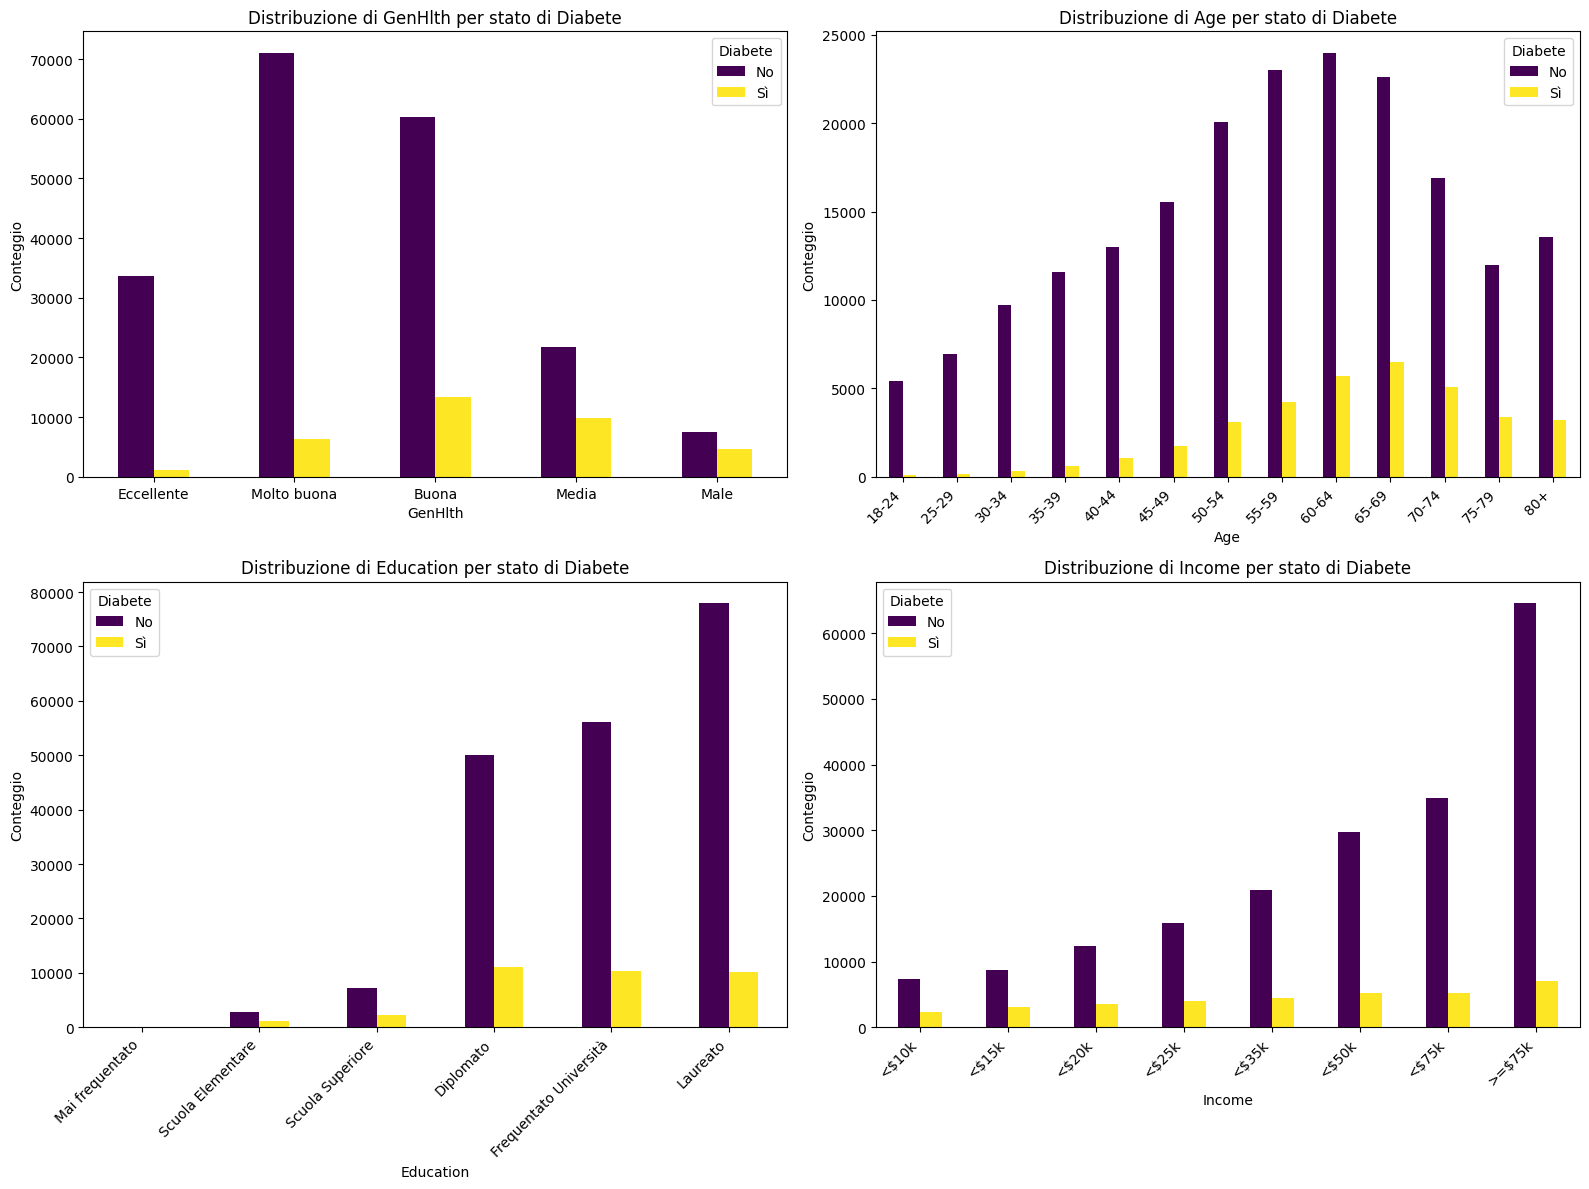

In [15]:

import matplotlib.pyplot as plt
categorical_cols_for_plot = ['GenHlth', 'Age', 'Education', 'Income']

n_cols_cat = len(categorical_cols_for_plot)
n_rows_cat = (n_cols_cat + 1) // 2 # Organizza su 2 colonne

fig, axes = plt.subplots(n_rows_cat, 2, figsize=(16, n_rows_cat * 6))
axes = axes.flatten()

age_labels = {
    1: '18-24', 2: '25-29', 3: '30-34', 4: '35-39', 5: '40-44', 6: '45-49',
    7: '50-54', 8: '55-59', 9: '60-64', 10: '65-69', 11: '70-74', 12: '75-79', 13: '80+'
}
education_labels = {
    1: 'Mai frequentato', 2: 'Scuola Elementare', 3: 'Scuola Superiore', 4: 'Diplomato',
    5: 'Frequentato Università', 6: 'Laureato'
}
income_labels = {
    1: '<$10k', 2: '<$15k', 3: '<$20k', 4: '<$25k', 5: '<$35k', 6: '<$50k',
    7: '<$75k', 8: '>=$75k'
}
genhlth_labels = {
    1: 'Eccellente', 2: 'Molto buona', 3: 'Buona', 4: 'Media', 5: 'Male'
}


# Itero sulle colonne categoriche per creare gli istogrammi
for i, col in enumerate(categorical_cols_for_plot):
    # Conteggio per ogni categoria della colonna e per ogni valore di Churn
    plot_data = data_diabete.groupby([col, 'Diabetes_binary'], observed=True).size().unstack(fill_value=0)

    # Crea l'istogramma
    plot_data.plot(kind='bar', stacked=False, ax=axes[i], colormap='viridis')

    axes[i].set_title(f'Distribuzione di {col} per stato di Diabete', fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Conteggio', fontsize=10)

    # Imposta le etichette sull'asse x in base alla colonna
    if col == 'Age':
        axes[i].set_xticklabels([age_labels.get(x, x) for x in plot_data.index], rotation=45, ha='right')
    elif col == 'Education':
        axes[i].set_xticklabels([education_labels.get(x, x) for x in plot_data.index], rotation=45, ha='right')
    elif col == 'Income':
        axes[i].set_xticklabels([income_labels.get(x, x) for x in plot_data.index], rotation=45, ha='right')
    elif col == 'GenHlth':
        axes[i].set_xticklabels([genhlth_labels.get(x, x) for x in plot_data.index], rotation=0)


    axes[i].legend(title='Diabete', labels=['No', 'Sì'])


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()





Dagli istogrammi sulle variabili categoriche possiamo notare che:
* Più lo stato di salute del paziente peggiore, più aumentano i casi di diabete. Questo è normale, in quanto il diabete peggiora la salute;
* Anche l'eta risulta essere un fattore di rischio per il diabete, e anche questo è normale perché l'avanzare dell'eta risulta proprio essere uno dei più importanti fattori di rischio, nello specifico per il diabete di tipo 2;
* I livelli di Educazione e Stipendio invece non risultano essere rilevanti per la presenza o meno di diabete.

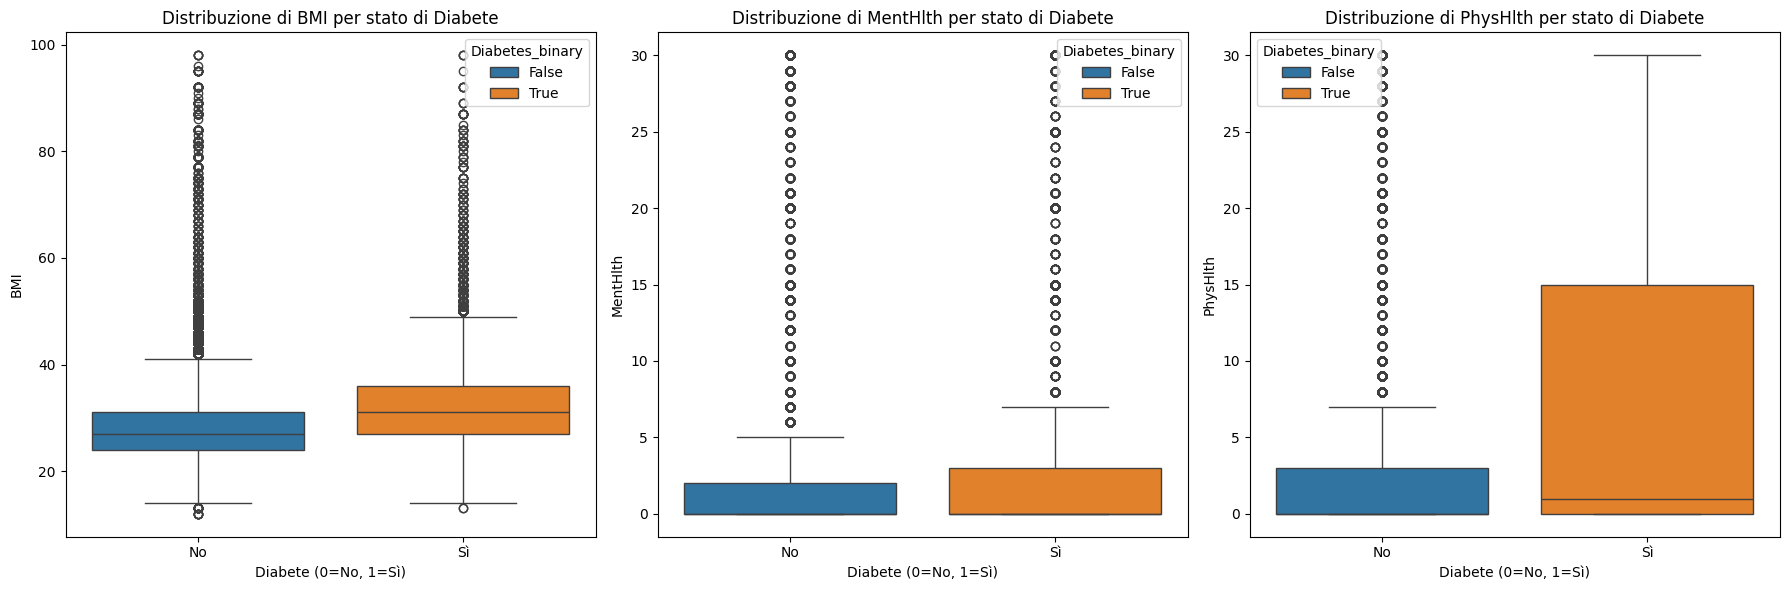

In [16]:

numerical_cols_for_plot = ['BMI', 'MentHlth', 'PhysHlth']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.flatten()

for i, col in enumerate(numerical_cols_for_plot):
    sns.boxplot(data=data_diabete, x='Diabetes_binary', y=col, hue="Diabetes_binary", ax=axes[i])
    axes[i].set_title(f'Distribuzione di {col} per stato di Diabete', fontsize=12)
    axes[i].set_xlabel('Diabete (0=No, 1=Sì)', fontsize=10)
    axes[i].set_ylabel(col, fontsize=10)
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['No', 'Sì'])


plt.tight_layout()
plt.show()

Dai Box Plot prodotti sui dati di tipo numerico notiamo invece che:
* Le persone diabetiche tendono ad avere una BMI maggiore, infatti la condizione di obesità risulta essere una delle cause più influenti per il diabete;
* La salute mentale sembra essere scarsamente correlata con la presenza di diabete;
* La salute fisica è invece molto influenzata: questo lo si nota dal fatto che per le persone diabetiche, aumenta la dimensione dei quartili e quelli che per i non diabetici sono considerati outlier, per gli altri sono valori più comuni.

## Matrice di correlazione
Di seguito vediamo la matrice di correlazione delle diverse feature ripsetto alla variabile obiettivo `Diabetes_binary`. Prima di poter valutare ciò, però, è necessario effettuare il One-Hot-Encoding delle variabili categoriche:

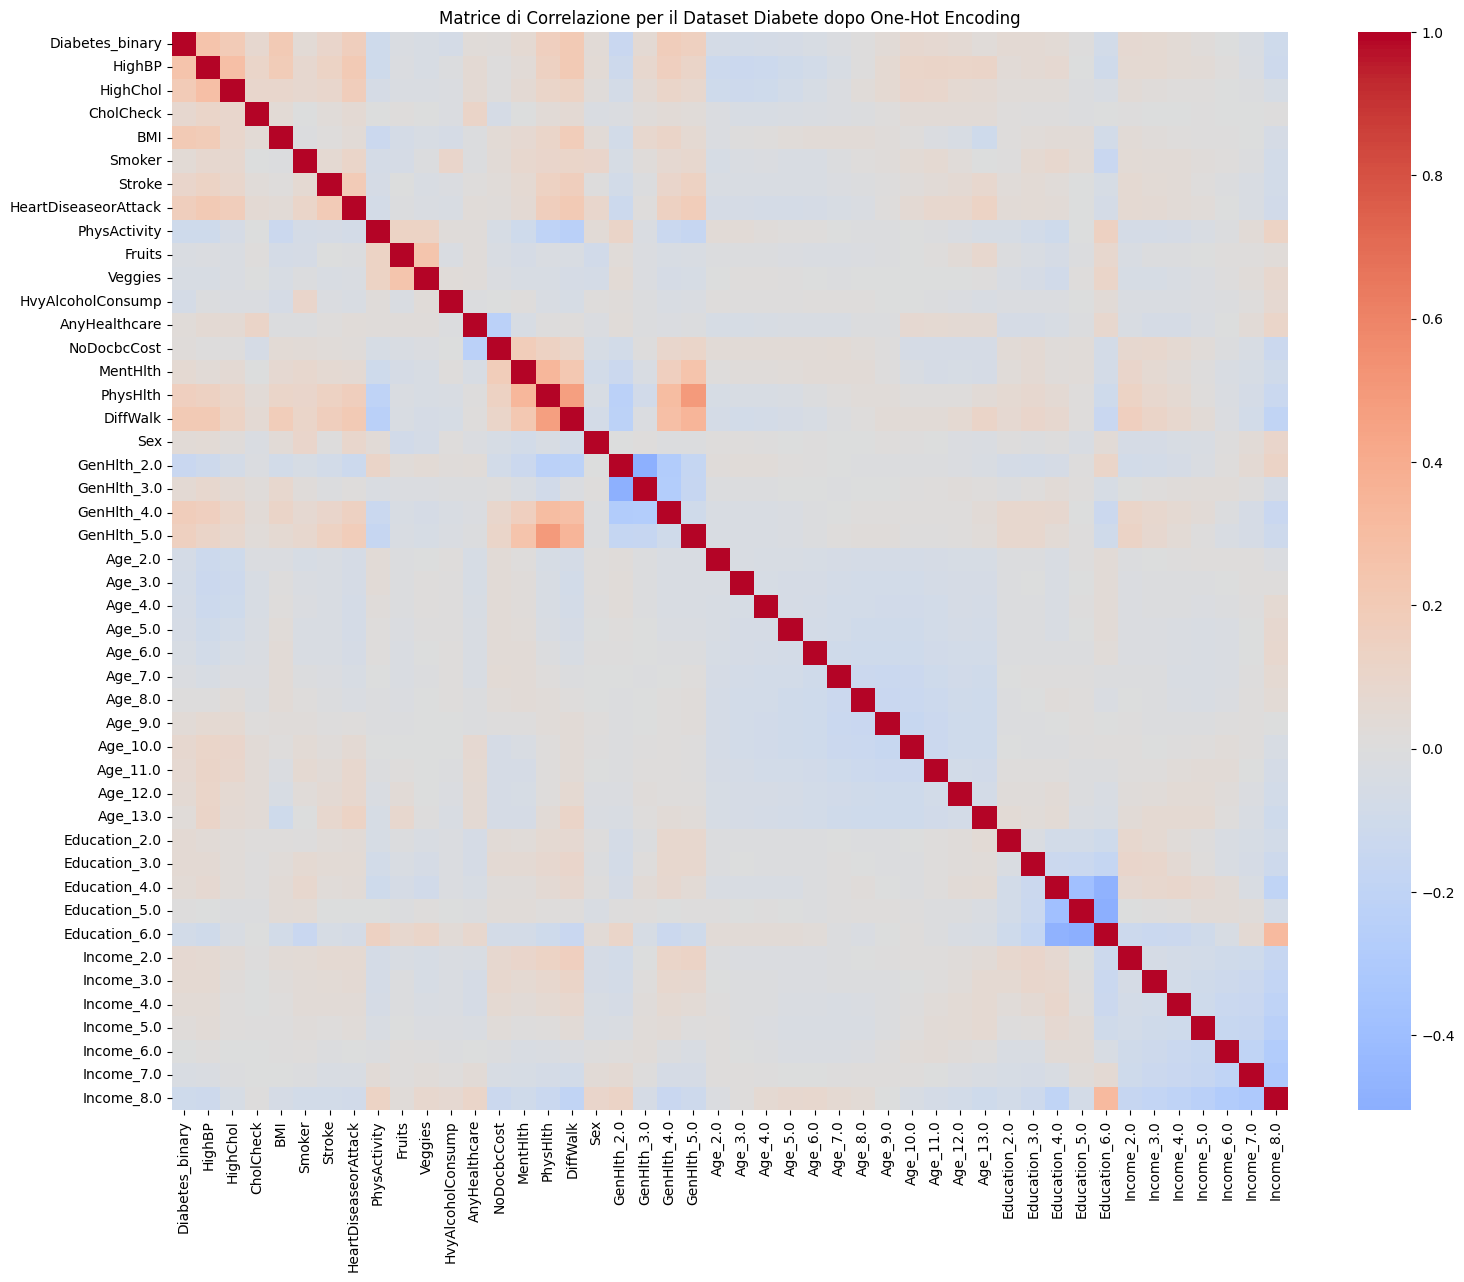


Correlazione con Diabetes_binary:


Diabetes_binary         1.000000
HighBP                  0.254318
DiffWalk                0.205302
BMI                     0.205086
HighChol                0.194944
GenHlth_4.0             0.174268
HeartDiseaseorAttack    0.168213
PhysHlth                0.156211
GenHlth_5.0             0.148003
Stroke                  0.099193
Age_10.0                0.073989
CholCheck               0.072523
Age_11.0                0.070999
Income_2.0              0.070730
MentHlth                0.054153
Income_3.0              0.053801
GenHlth_3.0             0.053488
Education_2.0           0.052024
Education_3.0           0.051627
Age_12.0                0.049912
Education_4.0           0.046104
Smoker                  0.045504
Income_4.0              0.042766
Age_9.0                 0.041199
Sex                     0.032724
Age_13.0                0.029378
AnyHealthcare           0.025331
Income_5.0              0.023782
NoDocbcCost             0.020048
Education_5.0           0.003969
Age_8.0                 0.002614
Income_6.0             -0.002915
Age_7.0                -0.018673
Fruits                 -0.024805
Income_7.0             -0.029063
Age_6.0                -0.041380
Veggies                -0.041734
Age_5.0                -0.055485
Age_2.0                -0.065916
HvyAlcoholConsump      -0.065950
Age_4.0                -0.067128
Age_3.0                -0.072211
Education_6.0          -0.081274
PhysActivity           -0.100404
Income_8.0             -0.102289
GenHlth_2.0            -0.142208
Name: Diabetes_binary, dtype: float64

In [17]:

data_diabete = pd.get_dummies(data_diabete, columns=categorical_cols, drop_first=True)

corr_matrix_diabete = data_diabete.corr()


plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix_diabete, annot=False, cmap='coolwarm', center=0)
plt.title('Matrice di Correlazione per il Dataset Diabete dopo One-Hot Encoding')
plt.show()

corr_with_target_diabete = corr_matrix_diabete['Diabetes_binary'].sort_values(ascending=False)
print("\nCorrelazione con Diabetes_binary:")
corr_with_target_diabete

La prima osservazione che possiamo fare è il fatto che non ci siano features predominanti. Questo implica che probabilmente un modello lineare potrà avere maggiori difficoltà a trovare una funzione adatta per modellare i dati.

Possiamo poi vedere come `HighBP`, `DiffWalk` e `BMI` siano features molto influenti per una persona diabetica. Questo è normale e comprensibile, perché una persona diabetica spesso ha una pressione sanguigna alta; la scarsa attività fisica è un altro fattore che impedisce significativamente, così come l'obesità.

D'altro canto vediamo che le variabili che influiscono maggiormente sulle persone non diabetiche sono:


*   `Gen_Hlth_2.0`: ovvero che un livello di salute buono è legato all'assenza di diabete;
*   `Income_8.0`: ovvero che livelli di RAL alti garantiscono anche un maggiore benessere, questo è probabilmente legato alla struttura del sistema sanitario statunitense in cui bisogna disporre di denaro per poter accedere a cure e analisi;
* `PhysActivity`: questo è legato al discorso che abbiamo fatto sopra per `DiffWalk`, ovvero che una maggiore attività fisica permette di gestire in maniera migliore i livelli di zucchero nel sangue e quindi a prevenire il diabete (concetto fortemente studiato e concordato dalla comunità scientifica).

Vi sono anche delle correlazioni tra le altre feature, aspetto che viene approfondito maggiormente nella parte successiva di Features Engineering.

## Features Engineering

Dalla matrice di correlazione possiamo notare i seguenti legami sulle feature del dataset:
* `HighBP`, `HighChol`, `BMI` e `HeartDiseaseorAttack` sono correlate tra di loro. Questo è normale, in quanto tutti indicatori della salute cardiologica del paziente;
* `MenthHlth`, `PhysHlth` e `DiffWalk` sono correlate tra di loro. Anche questo è coerente, in quanto tutti indici di dello stato di salute generale del paziente.

A partire da queste osservazioni, costruiamo le variabili `CardioMetabolic_Risk` e `OverallHealth` da aggiungere al nostro dataset.

In [18]:
# Creazione feature 'RiskScore' che indica un punteggio di rischio cardio metabolico. La feature ha un valore che varia
# da 0 a 4, derivante dalla somma delle diverse condizioni di rischio. La BMI si considera rischiosa quando supera
# il 30.0.
data_diabete['CardioMetabolic_Risk'] = (
    data_diabete['HighBP'] +
    data_diabete['HighChol'] +
    data_diabete['BMI'].apply(lambda x:1 if x>30 else 0) +
    data_diabete['HeartDiseaseorAttack'] +
    data_diabete['Stroke']
)


In [19]:
# Creazione feature 'OverallHealth' che combina MentalHealth, PhysHlth e DiffWalk
# Un punteggio più alto indica una salute peggiore
# Normalizziamo MentHlth e PhysHlth su una scala 0-30 per renderli comparabili con DiffWalk (che è booleana)
# e poi sommiamo
data_diabete['OverallHealth'] = (
    (data_diabete['MentHlth'] / 30) +
    (data_diabete['PhysHlth'] / 30) +
    data_diabete['DiffWalk']
)

print("\nDataset con la nuova feature 'OverallHealth':")
print(data_diabete[['MentHlth', 'PhysHlth', 'DiffWalk', 'OverallHealth']].head())

# Calcolo la correlazione della nuova feature con la variabile target
corr_with_overall_health = data_diabete['OverallHealth'].corr(data_diabete['Diabetes_binary'])

print(f"\nCorrelazione di 'OverallHealth' con 'Diabetes_binary': {corr_with_overall_health:.4f}")

corr_matrix_diabete = data_diabete.corr()
corr_with_target_diabete = corr_matrix_diabete['Diabetes_binary'].sort_values(ascending=False)

print("\nCorrelazione con Diabetes_binary (aggiornata):")
corr_with_target_diabete



Dataset con la nuova feature 'OverallHealth':
   MentHlth  PhysHlth  DiffWalk  OverallHealth
0        18        15      True            2.1
1         0         0     False            0.0
2        30        30      True            3.0
3         0         0     False            0.0
4         3         0     False            0.1

Correlazione di 'OverallHealth' con 'Diabetes_binary': 0.1964

Correlazione con Diabetes_binary (aggiornata):


Diabetes_binary         1.000000
CardioMetabolic_Risk    0.307053
HighBP                  0.254318
DiffWalk                0.205302
BMI                     0.205086
OverallHealth           0.196424
HighChol                0.194944
GenHlth_4.0             0.174268
HeartDiseaseorAttack    0.168213
PhysHlth                0.156211
GenHlth_5.0             0.148003
Stroke                  0.099193
Age_10.0                0.073989
CholCheck               0.072523
Age_11.0                0.070999
Income_2.0              0.070730
MentHlth                0.054153
Income_3.0              0.053801
GenHlth_3.0             0.053488
Education_2.0           0.052024
Education_3.0           0.051627
Age_12.0                0.049912
Education_4.0           0.046104
Smoker                  0.045504
Income_4.0              0.042766
Age_9.0                 0.041199
Sex                     0.032724
Age_13.0                0.029378
AnyHealthcare           0.025331
Income_5.0              0.023782
NoDocbcCost             0.020048
Education_5.0           0.003969
Age_8.0                 0.002614
Income_6.0             -0.002915
Age_7.0                -0.018673
Fruits                 -0.024805
Income_7.0             -0.029063
Age_6.0                -0.041380
Veggies                -0.041734
Age_5.0                -0.055485
Age_2.0                -0.065916
HvyAlcoholConsump      -0.065950
Age_4.0                -0.067128
Age_3.0                -0.072211
Education_6.0          -0.081274
PhysActivity           -0.100404
Income_8.0             -0.102289
GenHlth_2.0            -0.142208
Name: Diabetes_binary, dtype: float64

Sfruttiamo i dati di correlazione delle diverse feature con `Diabetes_binary` per poter eliminare alcune feature. Per farlo, vediamo quelle variabili che hanno una correlazione vicino allo zero in valore assoluto (nello specifico, consideriamo i casi in cui `|correlazione| <= 0.05`). Questo ci permette di evitare a priori di dover considerare feature scarsamente legate a quella che è la nostra variabile target.  

In [20]:
features_to_keep_diabete = corr_with_target_diabete[abs(corr_with_target_diabete) >= 0.05].index.tolist()

if 'Diabetes_binary' not in features_to_keep_diabete:
    features_to_keep_diabete.append('Diabetes_binary')

data_diabete_filtered = data_diabete[features_to_keep_diabete].copy()

print("\nFeature rimanenti:", data_diabete_filtered.columns.tolist())


Feature rimanenti: ['Diabetes_binary', 'CardioMetabolic_Risk', 'HighBP', 'DiffWalk', 'BMI', 'OverallHealth', 'HighChol', 'GenHlth_4.0', 'HeartDiseaseorAttack', 'PhysHlth', 'GenHlth_5.0', 'Stroke', 'Age_10.0', 'CholCheck', 'Age_11.0', 'Income_2.0', 'MentHlth', 'Income_3.0', 'GenHlth_3.0', 'Education_2.0', 'Education_3.0', 'Age_5.0', 'Age_2.0', 'HvyAlcoholConsump', 'Age_4.0', 'Age_3.0', 'Education_6.0', 'PhysActivity', 'Income_8.0', 'GenHlth_2.0']


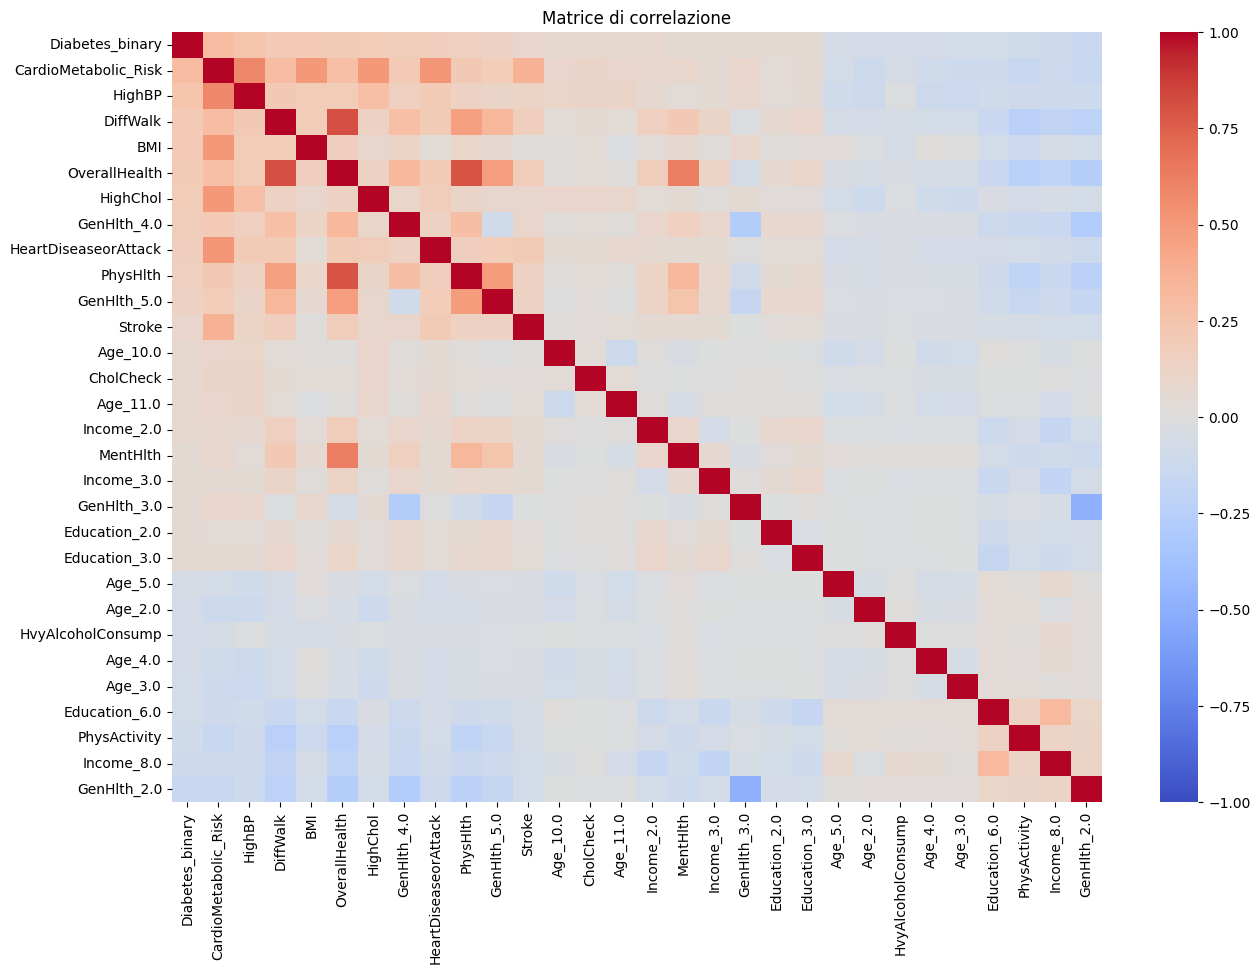


Correlazioni con Diabetes_binary:


Diabetes_binary         1.000000
CardioMetabolic_Risk    0.307053
HighBP                  0.254318
DiffWalk                0.205302
BMI                     0.205086
OverallHealth           0.196424
HighChol                0.194944
GenHlth_4.0             0.174268
HeartDiseaseorAttack    0.168213
PhysHlth                0.156211
GenHlth_5.0             0.148003
Stroke                  0.099193
Age_10.0                0.073989
CholCheck               0.072523
Age_11.0                0.070999
Income_2.0              0.070730
MentHlth                0.054153
Income_3.0              0.053801
GenHlth_3.0             0.053488
Education_2.0           0.052024
Education_3.0           0.051627
Age_5.0                -0.055485
Age_2.0                -0.065916
HvyAlcoholConsump      -0.065950
Age_4.0                -0.067128
Age_3.0                -0.072211
Education_6.0          -0.081274
PhysActivity           -0.100404
Income_8.0             -0.102289
GenHlth_2.0            -0.142208
Name: Diabetes_binary, dtype: float64

In [21]:
import seaborn as sns
plt.figure(figsize=(15, 10))
corr_matrix = data_diabete_filtered.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice di correlazione')
plt.show()

# Correlazioni con la variabile target
print("\nCorrelazioni con Diabetes_binary:")
display(corr_matrix['Diabetes_binary'].sort_values(ascending=False))

## Preparazione dei dati per il training
Il processo di preparazione dei dati prevede la divisione in X e y, andando a rimuovere la variabile target dal dataset. Inoltre, si dividono i dati in training e validation set, usando una suddivisione 70/30.

In [22]:
data_diabete_filtered

Diabetes_binary  CardioMetabolic_Risk  HighBP  DiffWalk   BMI  \
0                 False                     2    True      True  40.0   
1                 False                     0   False     False  25.0   
2                 False                     1    True      True  28.0   
3                 False                     1    True     False  27.0   
4                 False                     1    True     False  24.0   
...                 ...                   ...     ...       ...   ...   
253675            False                     2    True     False  45.0   
253676             True                     1    True      True  18.0   
253677            False                     0   False     False  28.0   
253678            False                     1    True     False  23.0   
253679             True                     2    True     False  25.0   

        OverallHealth  HighChol  GenHlth_4.0  HeartDiseaseorAttack  PhysHlth  \
0            2.100000      True        False                 False        15   
1            0.000000     False        False                 False         0   
2            3.000000      True        False                 False        30   
3            0.000000     False        False                 False         0   
4            0.100000      True        False                 False         0   
...               ...       ...          ...                   ...       ...   
253675       0.166667      True        False                 False         5   
253676       1.000000      True         True                 False         0   
253677       0.000000     False        False                 False         0   
253678       0.000000     False        False                 False         0   
253679       0.000000      True        False                  True         0   

        ...  Education_3.0  Age_5.0  Age_2.0  HvyAlcoholConsump  Age_4.0  \
0       ...          False    False    False              False    False   
1       ...          False    False    False              False    False   
2       ...          False    False    False              False    False   
3       ...           True    False    False              False    False   
4       ...          False    False    False              False    False   
...     ...            ...      ...      ...                ...      ...   
253675  ...          False     True    False              False    False   
253676  ...          False    False    False              False    False   
253677  ...          False    False     True              False    False   
253678  ...          False    False    False              False    False   
253679  ...          False    False    False              False    False   

        Age_3.0  Education_6.0  PhysActivity  Income_8.0  GenHlth_2.0  
0         False          False         False       False        False  
1         False           True          True       False        False  
2         False          False         False        True        False  
3         False          False          True       False         True  
4         False          False          True       False         True  
...         ...            ...           ...         ...          ...  
253675    False           True         False       False        False  
253676    False          False         False       False        False  
253677    False          False          True       False        False  
253678    False          False         False       False        False  
253679    False           True          True       False         True  

[229474 rows x 30 columns]

E' necessario normalizzare i valori delle features numeriche.

In [23]:
X_dia = data_diabete_filtered.drop('Diabetes_binary', axis=1)
y_dia = data_diabete_filtered["Diabetes_binary"]

In [24]:
from sklearn.model_selection import train_test_split
X_dia_train, X_dia_val, y_dia_train, y_dia_val = train_test_split(X_dia, y_dia, test_size=0.3, random_state=42, stratify=y_dia)

Essendo il dataset fortemente sbilanciato, abbiamo bisogno di applicare una tecnica per bilanciare i dati: abbiamo deciso di applicare **SMOTEENN**: questa tecnica prevdere una combinazione di oversampling e undersampling. Infatti, viene prima applicata una tecnica di oversamplig per creare dati sintetici e successivamente una parte di questi che rappresentano casi limite vengono eliminati. Tra le diverse tecniche di oversampling, questa risulta essere una delle migliori, in quanto con i dati presenti all'interno del dataset, tecniche come SMOTE non porterebbero a buoni risultati, perché generano dati sintetici in un contesto in cui è defficile individuare il vero limite. La pulizia delle istanze create risulta essere quindi una tecnica efficace.

In [25]:
print(f"Distribuzione delle classi prima di SMOTEENN:  {pd.Series(y_dia_train).value_counts()}")

Distribuzione delle classi prima di SMOTEENN:  Diabetes_binary
False    136063
True      24568
Name: count, dtype: int64


In [26]:
from imblearn.combine import SMOTEENN
sme = SMOTEENN(random_state=42)
X_dia_train_resampled, y_dia_train_resampled = sme.fit_resample(X_dia_train, y_dia_train)
print(f"Distribuzione delle classi dopo SMOTEENN:  {pd.Series(y_dia_train_resampled).value_counts()}")

Distribuzione delle classi dopo SMOTEENN:  Diabetes_binary
True     98855
False    83707
Name: count, dtype: int64


# Orazio Spina

## Analisi di un dataset riguardante la diagnosi di Alzheimer

### Descrizione del dataset
Il dataset contiene informazioni riguardanti le condizioni di salute di alcuni pazienti. In particolare dettagli demografici, fattori legati allo stile di vita, anamnesi, misurazioni cliniche, valutazioni congnitive e funzionali, sintomi e una diagnosi di malattia di Alzheimer.

### Struttura del dataset
- **Numero di righe**: 2149
- **Numero di colonne**: 35
- **Features**:
  - **Informazioni del paziente**:
    - `PatientID`: Identificatiore unico assegnato a ciascun paziente (da 4751 a 6900).
    - **Dettagli demografici**:
      - `Age`: Età del paziente, va da 60 a 90 anni.
      - `Gender`: Sesso del paziente, 0 indica Uomo e 1 indica Donna
      - `Ethnicity`: Etnia del paziente, codificata come segue:
        - 0: Caucasica
        - 1: Afro americana
        - 2: Asiatica
        - 3: Altro
      - `EducationLevel`: Livello di istruzione del paziente, codificata come segue:
        - 0: Nessuna
        - 1: Scuola superiore
        - 2: Laurea triennale
        - 3: Magistrale e altro
    - **Fattori legati allo stile di vita**:
      - `BMI`: Indice di massa corporea del paziente, da 15 a 40.
      - `Smoking`: Stato di fumatore, dove 0 indica No e 1 indica Sì.
      - `AlcoholConsumption`: Consumo settimanale di alcol in unità, da 0 a 20.
      - `PhysicalActivity`: Attività fisica settimanale in ore, da 0 a 10.
      - `DietQuality`: Punteggio della qualità della dieta, da 0 a 10.
      - `SleepQuality`: Punteggio della qualità del sonno, da 4 a 10.
  - **Cartella clinica**:
    - `FamilyHistoryAlzheimers`: Anamnesi familiare di malattia di Alzheimer, dove 0 indica No e 1 indica Sì.
    - `CardiovascularDisease`: Presenza di malattie cardiovascolari, dove 0 indica No e 1 indica Sì.
    - `Diabetes`: Presenza di diabete, dove 0 indica No e 1 indica Sì.
    - `Depression`: Presenza di depressione, dove 0 indica No e 1 indica Sì.
    - `HeadInjury`: Anamnesi di trauma cranico, dove 0 indica No e 1 indica Sì.
    - `Hypertension`: Presenza di ipertensione, dove 0 indica No e 1 indica Sì.
  - **Misurazioni cliniche**:
    - `SystolicBP`: Pressione sanguigna sistolica, compresa tra 90 e 180 mmHg.
    - `DiastolicBP`: Pressione diastolica, compresa tra 60 e 120 mmHg.
    - `CholesterolTotal`: Livelli di colesterolo totale, compresi tra 150 e 300 mg/dL.
    - `CholesterolLDL`: Livelli di colesterolo lipoproteine a bassa densità, compresi tra 50 e 200 mg/dL.
    - `CholesterolHDL`: Livelli di colesterolo lipoproteine ad alta densità, compresi tra 20 e 100 mg/dL.
    - `CholesterolTriglycerides`: Livelli di trigliceridi, compresi tra 50 e 400 mg/dL.
  - **Valutazioni cognitive e funzionali**:
    - `MMSE`: Punteggio del Mini-Mental State Examination, compreso tra 0 e 30. Punteggi più bassi indicano un deterioramento cognitivo.
    - `FunctionalAssessment`: Punteggio di valutazione funzionale, che va da 0 a 10. Punteggi più bassi indicano un maggiore grado di compromissione.
    - `MemoryComplaints`: Presenza di disturbi della memoria, dove 0 indica No e 1 indica Sì.
    - `BehavioralProblems`: Presenza di problemi comportamentali, dove 0 indica No e 1 indica Sì.
    - `ADL`: Punteggio delle attività della vita quotidiana, che va da 0 a 10. Punteggi più bassi indicano un maggiore grado di compromissione.
  - **Sintomi**:
    - `Confusion`: Presenza di confusione, dove 0 indica No e 1 indica Sì.
    - `Disorientation`: Presenza di disorientamento, dove 0 indica No e 1 indica Sì.
    - `PersonalityChanges`: Presenza di cambiamenti di personalità, dove 0 indica No e 1 indica Sì.
    - `DifficultyCompletingTasks`: Presenza di difficoltà nel completare i compiti, dove 0 indica No e 1 indica Sì.
    - `Forgetfulness`: Presence of forgetfulness, where 0 indicates No and 1 indicates Yes.
  - **Informazioni sulla diagnosi**:
    - `Diagnosis`: Stato della diagnosi per la malattia di Alzheimer, dove 0 indica No e 1 indica Sì.
  - **Informazioni riservate**:
    - `DoctorInCharge`: Questa colonna contiene informazioni riservate sul medico curante, con valore "XXXConfid" per tutti i pazienti.

## Dettagli aggiuntivi
- **Valori nulli**:
  Il dataset non contiene valori nulli o mancanti.

- **Obiettivo dell'analisi**:
  Utilizzare tecniche di machine learning, in particolare SVM, per cercare di ottenere una diagnosi (`Diagnosis`) della malattia partendo dai dati relativi il paziente. L'analisi include l'esplorazione del dataset, preprocessing, addestramento dei modelli, ottimizzazione degli iperparametri e valutazione dei modelli tramite varie metriche.


In [ ]:
# Carico il dataset da file
# Download latest version
path = kagglehub.dataset_download("rabieelkharoua/alzheimers-disease-dataset")
data_alz = pd.read_csv(path + "/alzheimers_disease_data.csv")

# Rimozione delle features non rilevanti
data_alz.drop(["DoctorInCharge", "PatientID"], axis=1, inplace=True)

In [ ]:
# Informazioni sul dataset
print("\nInformazioni dul dataset:")
display(data_alz.info(memory_usage="deep"))


Informazioni dul dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        2149 non-null   int64  
 1   Gender                     2149 non-null   int64  
 2   Ethnicity                  2149 non-null   int64  
 3   EducationLevel             2149 non-null   int64  
 4   BMI                        2149 non-null   float64
 5   Smoking                    2149 non-null   int64  
 6   AlcoholConsumption         2149 non-null   float64
 7   PhysicalActivity           2149 non-null   float64
 8   DietQuality                2149 non-null   float64
 9   SleepQuality               2149 non-null   float64
 10  FamilyHistoryAlzheimers    2149 non-null   int64  
 11  CardiovascularDisease      2149 non-null   int64  
 12  Diabetes                   2149 non-null   int64  
 13  Depression           

None

In [ ]:
# Conversione delle colonne booleane in tipo 'bool'
boolean_features = ['Gender', 'Smoking', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'MemoryComplaints', 'BehavioralProblems', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness']

numerical_features = ["Age", "BMI", "AlcoholConsumption", "PhysicalActivity", "DietQuality", "SleepQuality", "SystolicBP", 'DiastolicBP', "CholesterolTotal", "CholesterolLDL", "CholesterolHDL", "CholesterolTriglycerides", "MMSE", "FunctionalAssessment", "ADL"]

categorical_features = ["Ethnicity", "EducationLevel"]

for col in boolean_features:
  data_alz[col] = data_alz[col].astype(bool)

for col in categorical_features:
  data_alz[col] = data_alz[col].astype('category')

In [ ]:
# Informazioni sul dataset dopo aver convertito i tipi delle colonne
print("\nInformazioni dul dataset:")
display(data_alz.info(memory_usage="deep"))


Informazioni dul dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Age                        2149 non-null   int64   
 1   Gender                     2149 non-null   bool    
 2   Ethnicity                  2149 non-null   category
 3   EducationLevel             2149 non-null   category
 4   BMI                        2149 non-null   float64 
 5   Smoking                    2149 non-null   bool    
 6   AlcoholConsumption         2149 non-null   float64 
 7   PhysicalActivity           2149 non-null   float64 
 8   DietQuality                2149 non-null   float64 
 9   SleepQuality               2149 non-null   float64 
 10  FamilyHistoryAlzheimers    2149 non-null   bool    
 11  CardiovascularDisease      2149 non-null   bool    
 12  Diabetes                   2149 non-null   bool    
 13  Depres

None

## Controllo l'eventuale presenza di valori nulli all'interno del dataset

In [ ]:
data_alz.isna().sum()

Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyCompletingTasks    0
Forgetfulness                0
Diagnosis                    0
dtype: int64

Come possiamo vedere all'interno del dataset non sono presenti valori nulli.

## Analisi esplorativa del dataset

In [ ]:
# Statistiche delle varie features
print("\nStatistiche descrittive delle features del dataset:")
display(data_alz.describe().T)


Statistiche descrittive delle features del dataset:


count        mean         std         min  \
Age                       2149.0   74.908795    8.990221   60.000000   
BMI                       2149.0   27.655697    7.217438   15.008851   
AlcoholConsumption        2149.0   10.039442    5.757910    0.002003   
PhysicalActivity          2149.0    4.920202    2.857191    0.003616   
DietQuality               2149.0    4.993138    2.909055    0.009385   
SleepQuality              2149.0    7.051081    1.763573    4.002629   
SystolicBP                2149.0  134.264774   25.949352   90.000000   
DiastolicBP               2149.0   89.847836   17.592496   60.000000   
CholesterolTotal          2149.0  225.197519   42.542233  150.093316   
CholesterolLDL            2149.0  124.335944   43.366584   50.230707   
CholesterolHDL            2149.0   59.463533   23.139174   20.003434   
CholesterolTriglycerides  2149.0  228.281496  101.986721   50.407194   
MMSE                      2149.0   14.755132    8.613151    0.005312   
FunctionalAssessment      2149.0    5.080055    2.892743    0.000460   
ADL                       2149.0    4.982958    2.949775    0.001288   
Diagnosis                 2149.0    0.353653    0.478214    0.000000   

                                 25%         50%         75%         max  
Age                        67.000000   75.000000   83.000000   90.000000  
BMI                        21.611408   27.823924   33.869778   39.992767  
AlcoholConsumption          5.139810    9.934412   15.157931   19.989293  
PhysicalActivity            2.570626    4.766424    7.427899    9.987429  
DietQuality                 2.458455    5.076087    7.558625    9.998346  
SleepQuality                5.482997    7.115646    8.562521    9.999840  
SystolicBP                112.000000  134.000000  157.000000  179.000000  
DiastolicBP                74.000000   91.000000  105.000000  119.000000  
CholesterolTotal          190.252963  225.086430  262.031657  299.993352  
CholesterolLDL             87.195798  123.342593  161.733733  199.965665  
CholesterolHDL             39.095698   59.768237   78.939050   99.980324  
CholesterolTriglycerides  137.583222  230.301983  314.839046  399.941862  
MMSE                        7.167602   14.441660   22.161028   29.991381  
FunctionalAssessment        2.566281    5.094439    7.546981    9.996467  
ADL                         2.342836    5.038973    7.581490    9.999747  
Diagnosis                   0.000000    0.000000    1.000000    1.000000

### Visualizziamo la distribuzione della variabile target

Diagnosis
0    0.646347
1    0.353653
Name: proportion, dtype: float64

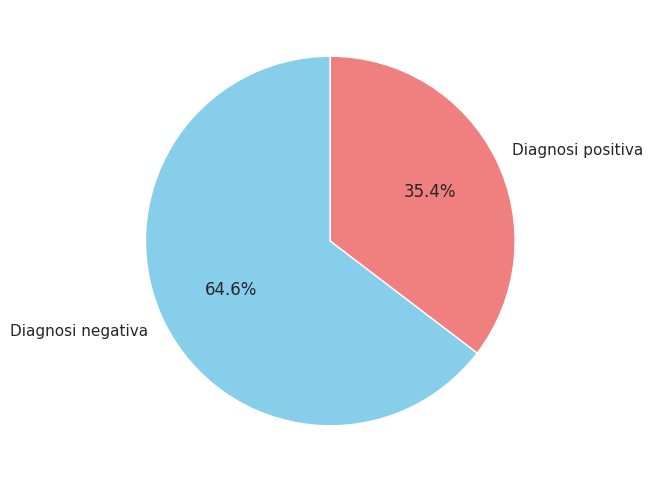

In [ ]:
# Percentuale di diagnosi positive/negative
display(data_alz["Diagnosis"].value_counts(normalize=True))

positive, negative = data_alz["Diagnosis"].value_counts()
tot = positive + negative

data_alz["Diagnosis"].value_counts().plot.pie(autopct='%1.1f%%', labels=["Diagnosi negativa", "Diagnosi positiva"], figsize=(12, 6), colors=['skyblue', 'lightcoral'], startangle=90, ylabel="");

### Variabili di tipo booleano

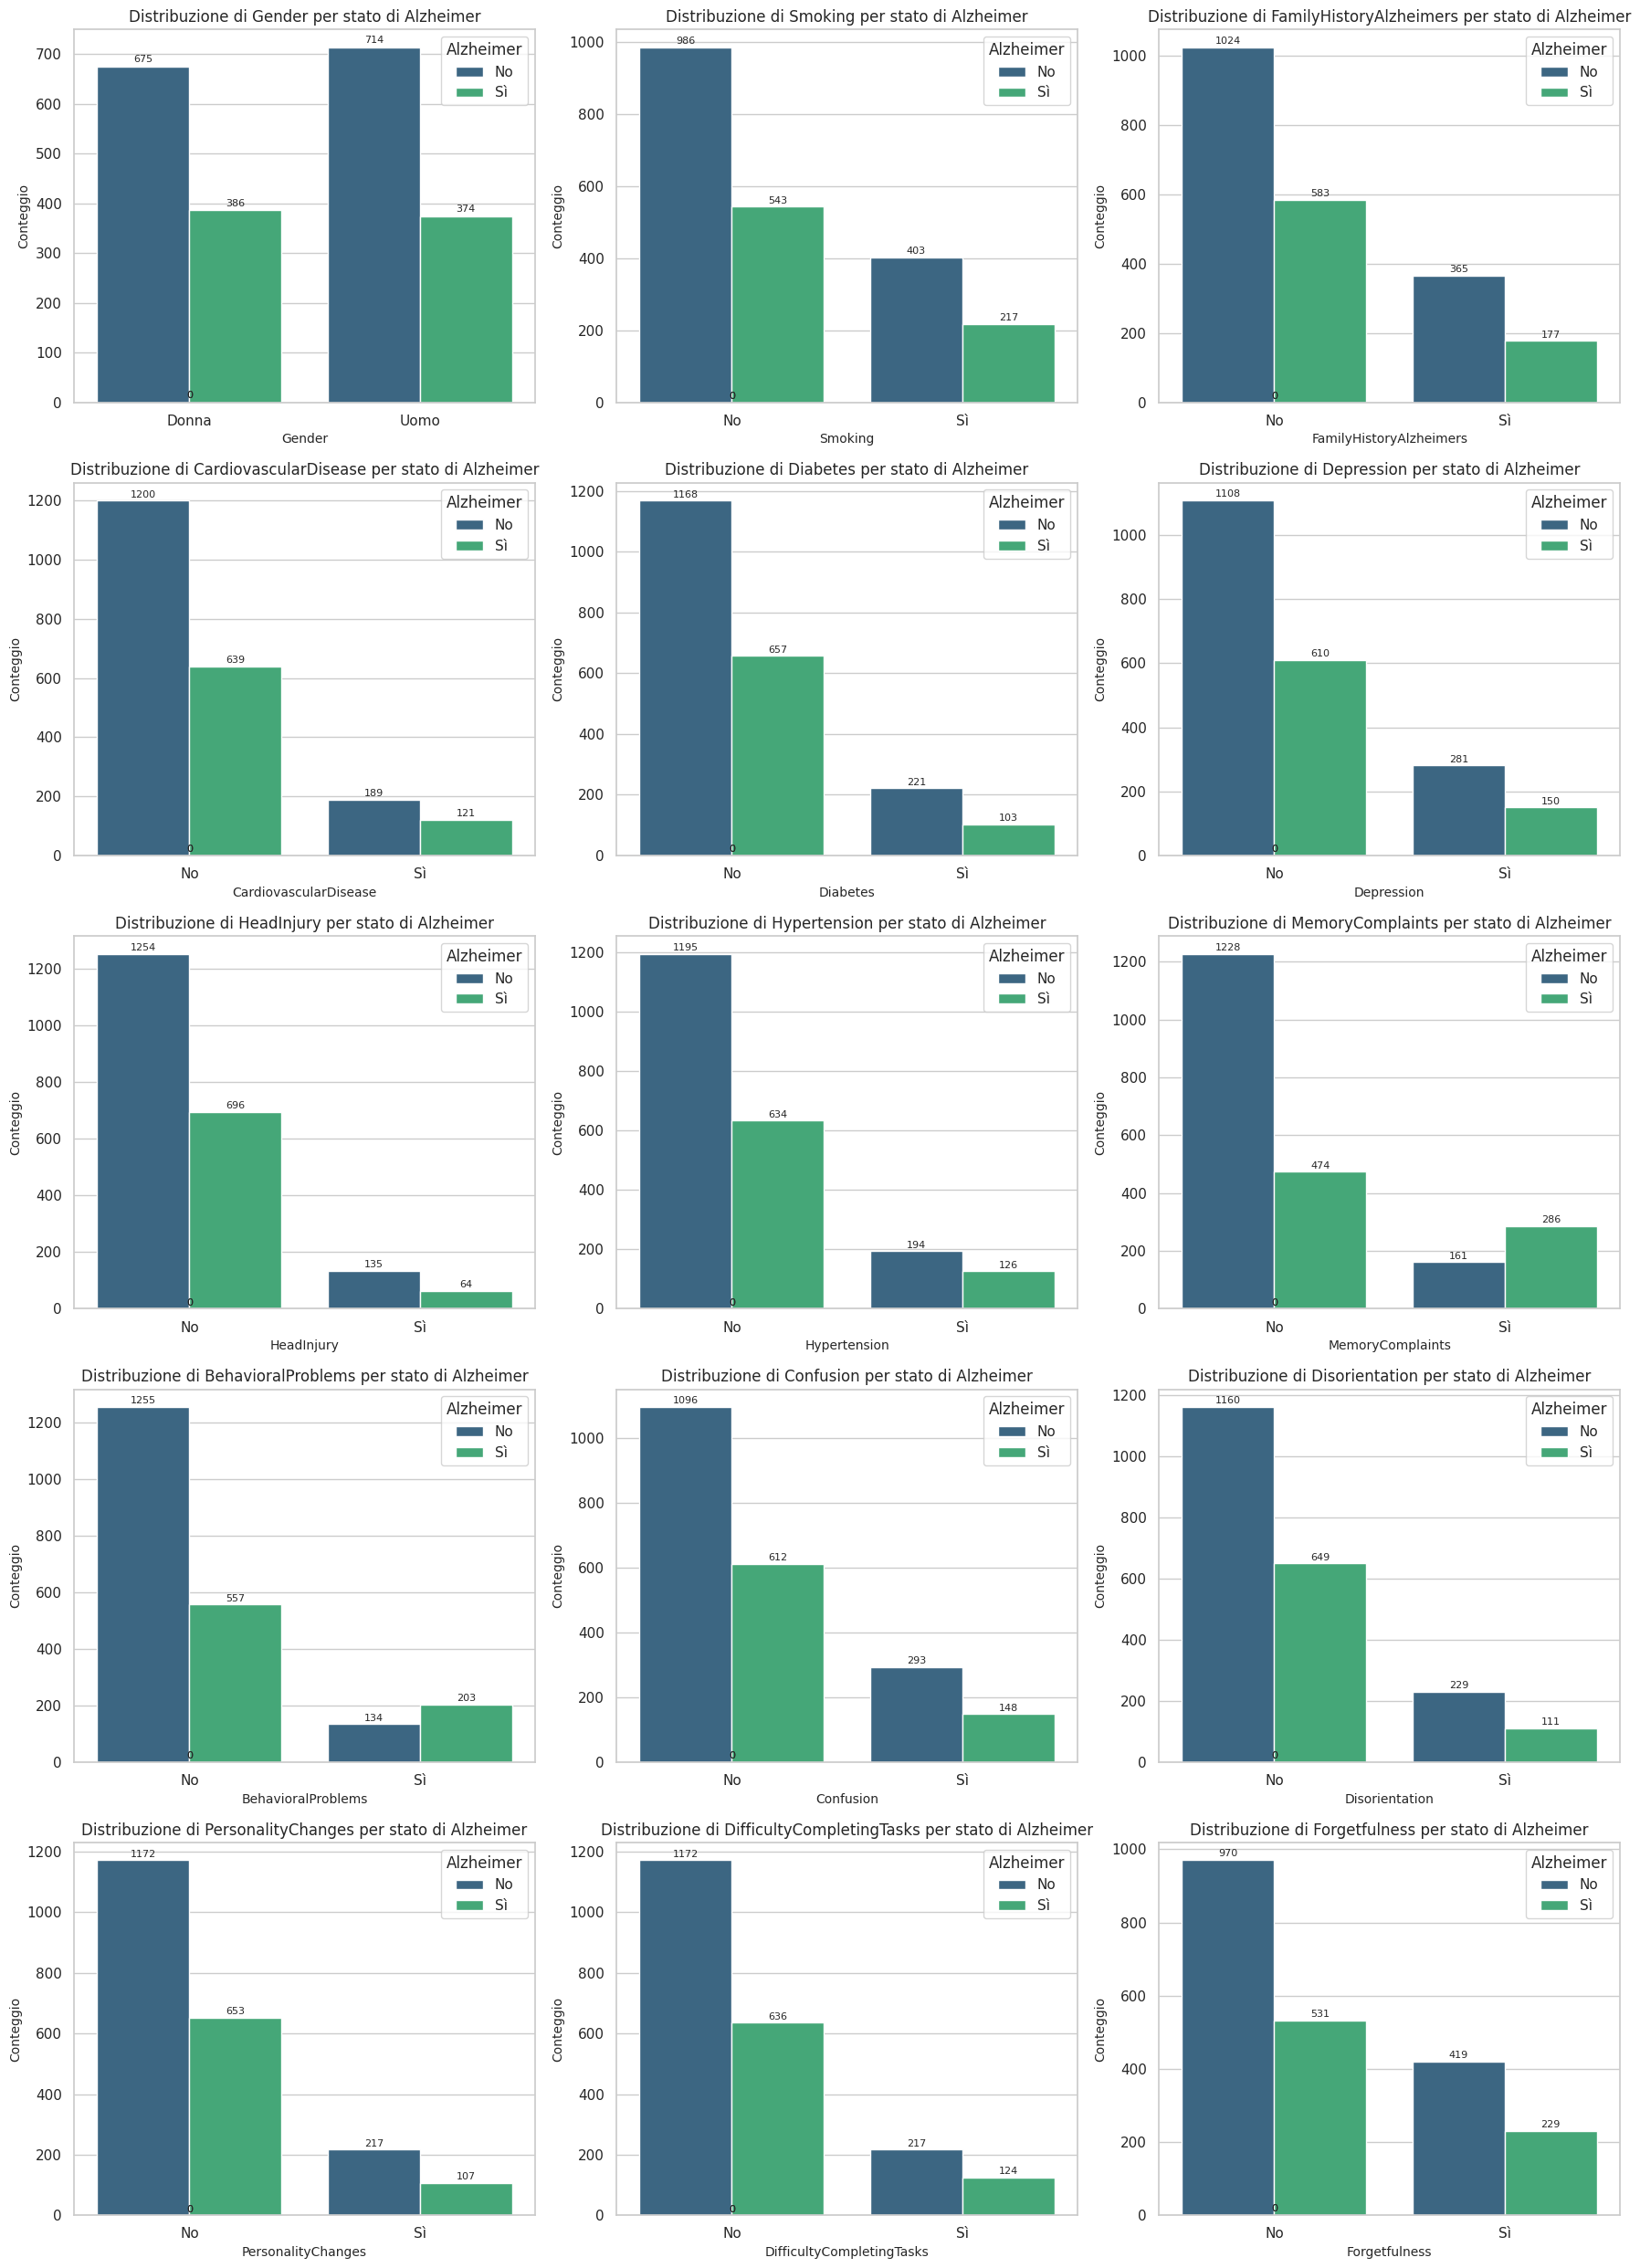

In [ ]:
# Plot delle feature booleane in relazione con la diagnosi
n_cols_binary = len(boolean_features)
n_rows_binary = (n_cols_binary + 1) // 3

# Creo la figura e i subplot
fig, axes = plt.subplots(n_rows_binary, 3, figsize=(18, n_rows_binary * 5))
axes = axes.flatten() # Appiattisco l'array di assi per iterare facilmente

# Itero sulle colonne binarie per creare gli istogrammi
for i, col in enumerate(boolean_features):
    # Uso seaborn per creare l'istogramma raggruppato per 'Diabetes_binary'
    sns.countplot(data=data_alz, x=col, hue='Diagnosis', ax=axes[i], palette='viridis')

    # Imposto titoli e etichette
    axes[i].set_title(f'Distribuzione di {col} per stato di Alzheimer', fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Conteggio', fontsize=10)
    axes[i].set_xticks([0, 1])
    if(col == "Gender"):
      axes[i].set_xticklabels(['Donna', 'Uomo'])
    else:
      axes[i].set_xticklabels(['No', 'Sì'])

    # Aggiungo la legenda per 'Diabetes_binary'
    axes[i].legend(title='Alzheimer', labels=['No', 'Sì'])

    # Annotazioni sopra le barre per mostrare i conteggi
    for p in axes[i].patches:
        height = p.get_height()
        axes[i].text(p.get_x() + p.get_width()/2., height + 5, f'{int(height)}', ha='center', va='bottom', fontsize=8)


# Nascondo gli assi inutilizzati se il numero di grafici è inferiore al totale dei subplot
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Assicuro che i subplot non si sovrappongano
plt.show()

### Variabili di tipo categorico

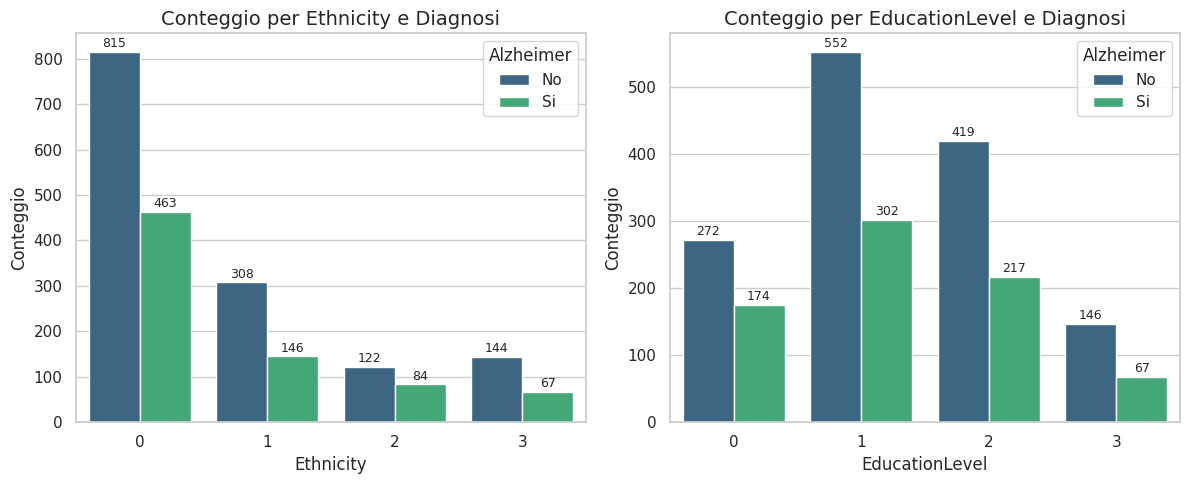

In [ ]:
# # Plot delle feature categoriche in relazione con la diagnosi
n_features_cat = len(categorical_features)
n_cols = 3
n_rows = (n_features_cat + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.ravel()

for i, col_name in enumerate(categorical_features):
    # Usiamo countplot: crea una barra per ogni categoria e 'hue' la divide
    ax = axes[i]
    sns.countplot(data=data_alz, x=col_name, hue='Diagnosis', ax=ax, palette='viridis')

    # Aggiungiamo i conteggi numerici sopra ogni barra per massima chiarezza
    for p in ax.patches:
        height = p.get_height()
        if height > 0: # Mostra l'etichetta solo se la barra esiste
            ax.text(p.get_x() + p.get_width() / 2., height + 3, f'{int(height)}',
                    ha="center", va="bottom", fontsize=9)

    ax.set_title(f'Conteggio per {col_name} e Diagnosi', fontsize=14)
    ax.set_xlabel(col_name, fontsize=12)
    ax.set_ylabel('Conteggio', fontsize=12)
    ax.legend(title='Alzheimer', labels=["No", "Si"])

# Nascondiamo gli assi non utilizzati
for j in range(n_features_cat, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Variabili di tipo numerico

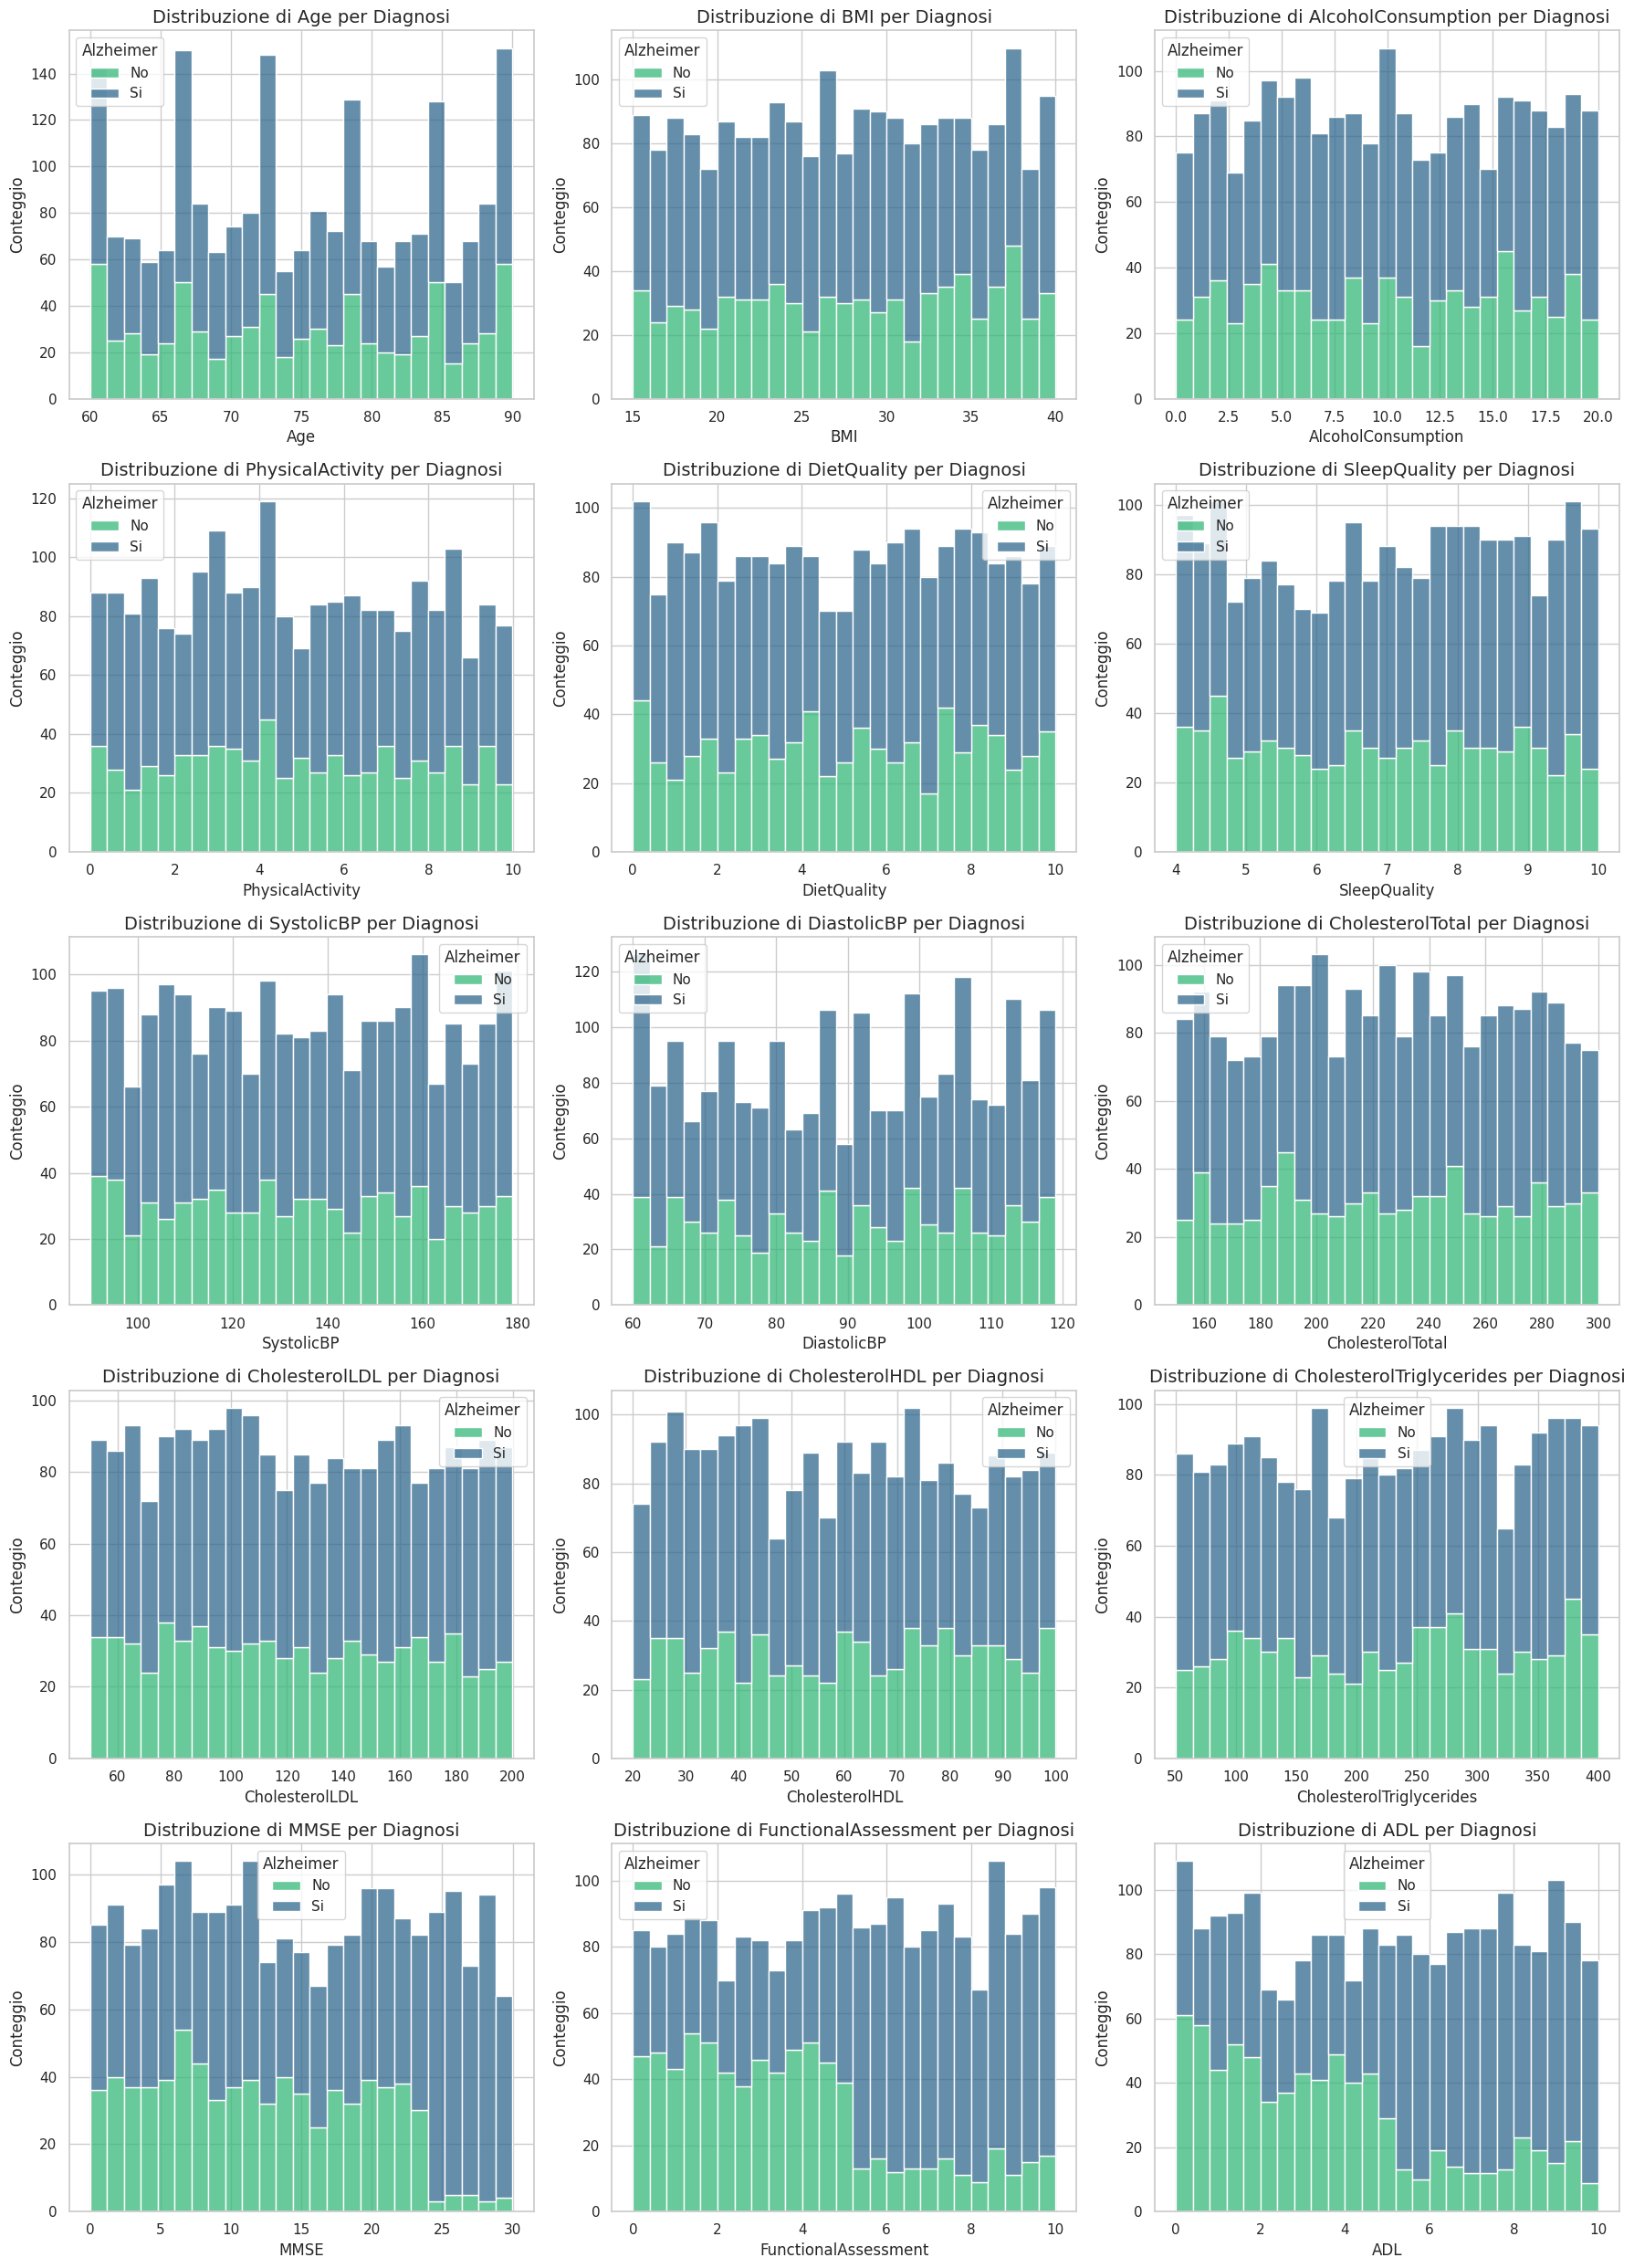

In [ ]:
# Plot delle feature numeriche in relazione con la diagnosi
n_features_num = len(numerical_features)
n_cols = 3
n_rows = (n_features_num + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.ravel()

for i, col_name in enumerate(numerical_features):
    # Usiamo histplot: crea un istogramma (barre per intervalli di valori)
    # multiple='stack' sovrappone i conteggi di 'sani' e 'malati'
    sns.histplot(
        data=data_alz,
        x=col_name,
        hue='Diagnosis',
        multiple='stack', # Questa è l'opzione chiave per sovrapporre
        palette='viridis',
        ax=axes[i],
        bins=25 # Puoi regolare il numero di "barre" dell'istogramma
    )
    axes[i].set_title(f'Distribuzione di {col_name} per Diagnosi', fontsize=14)
    axes[i].set_xlabel(col_name, fontsize=12)
    axes[i].set_ylabel('Conteggio', fontsize=12)
    axes[i].legend(title='Alzheimer', labels=["No", "Si"])

# Nascondiamo gli assi non utilizzati
for j in range(n_features_num, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Matrice di correlazione
Di seguito visualizziamo la matrice di correlazione delle varie features rispetto alla variabile obiettivo `Diagnosis`.

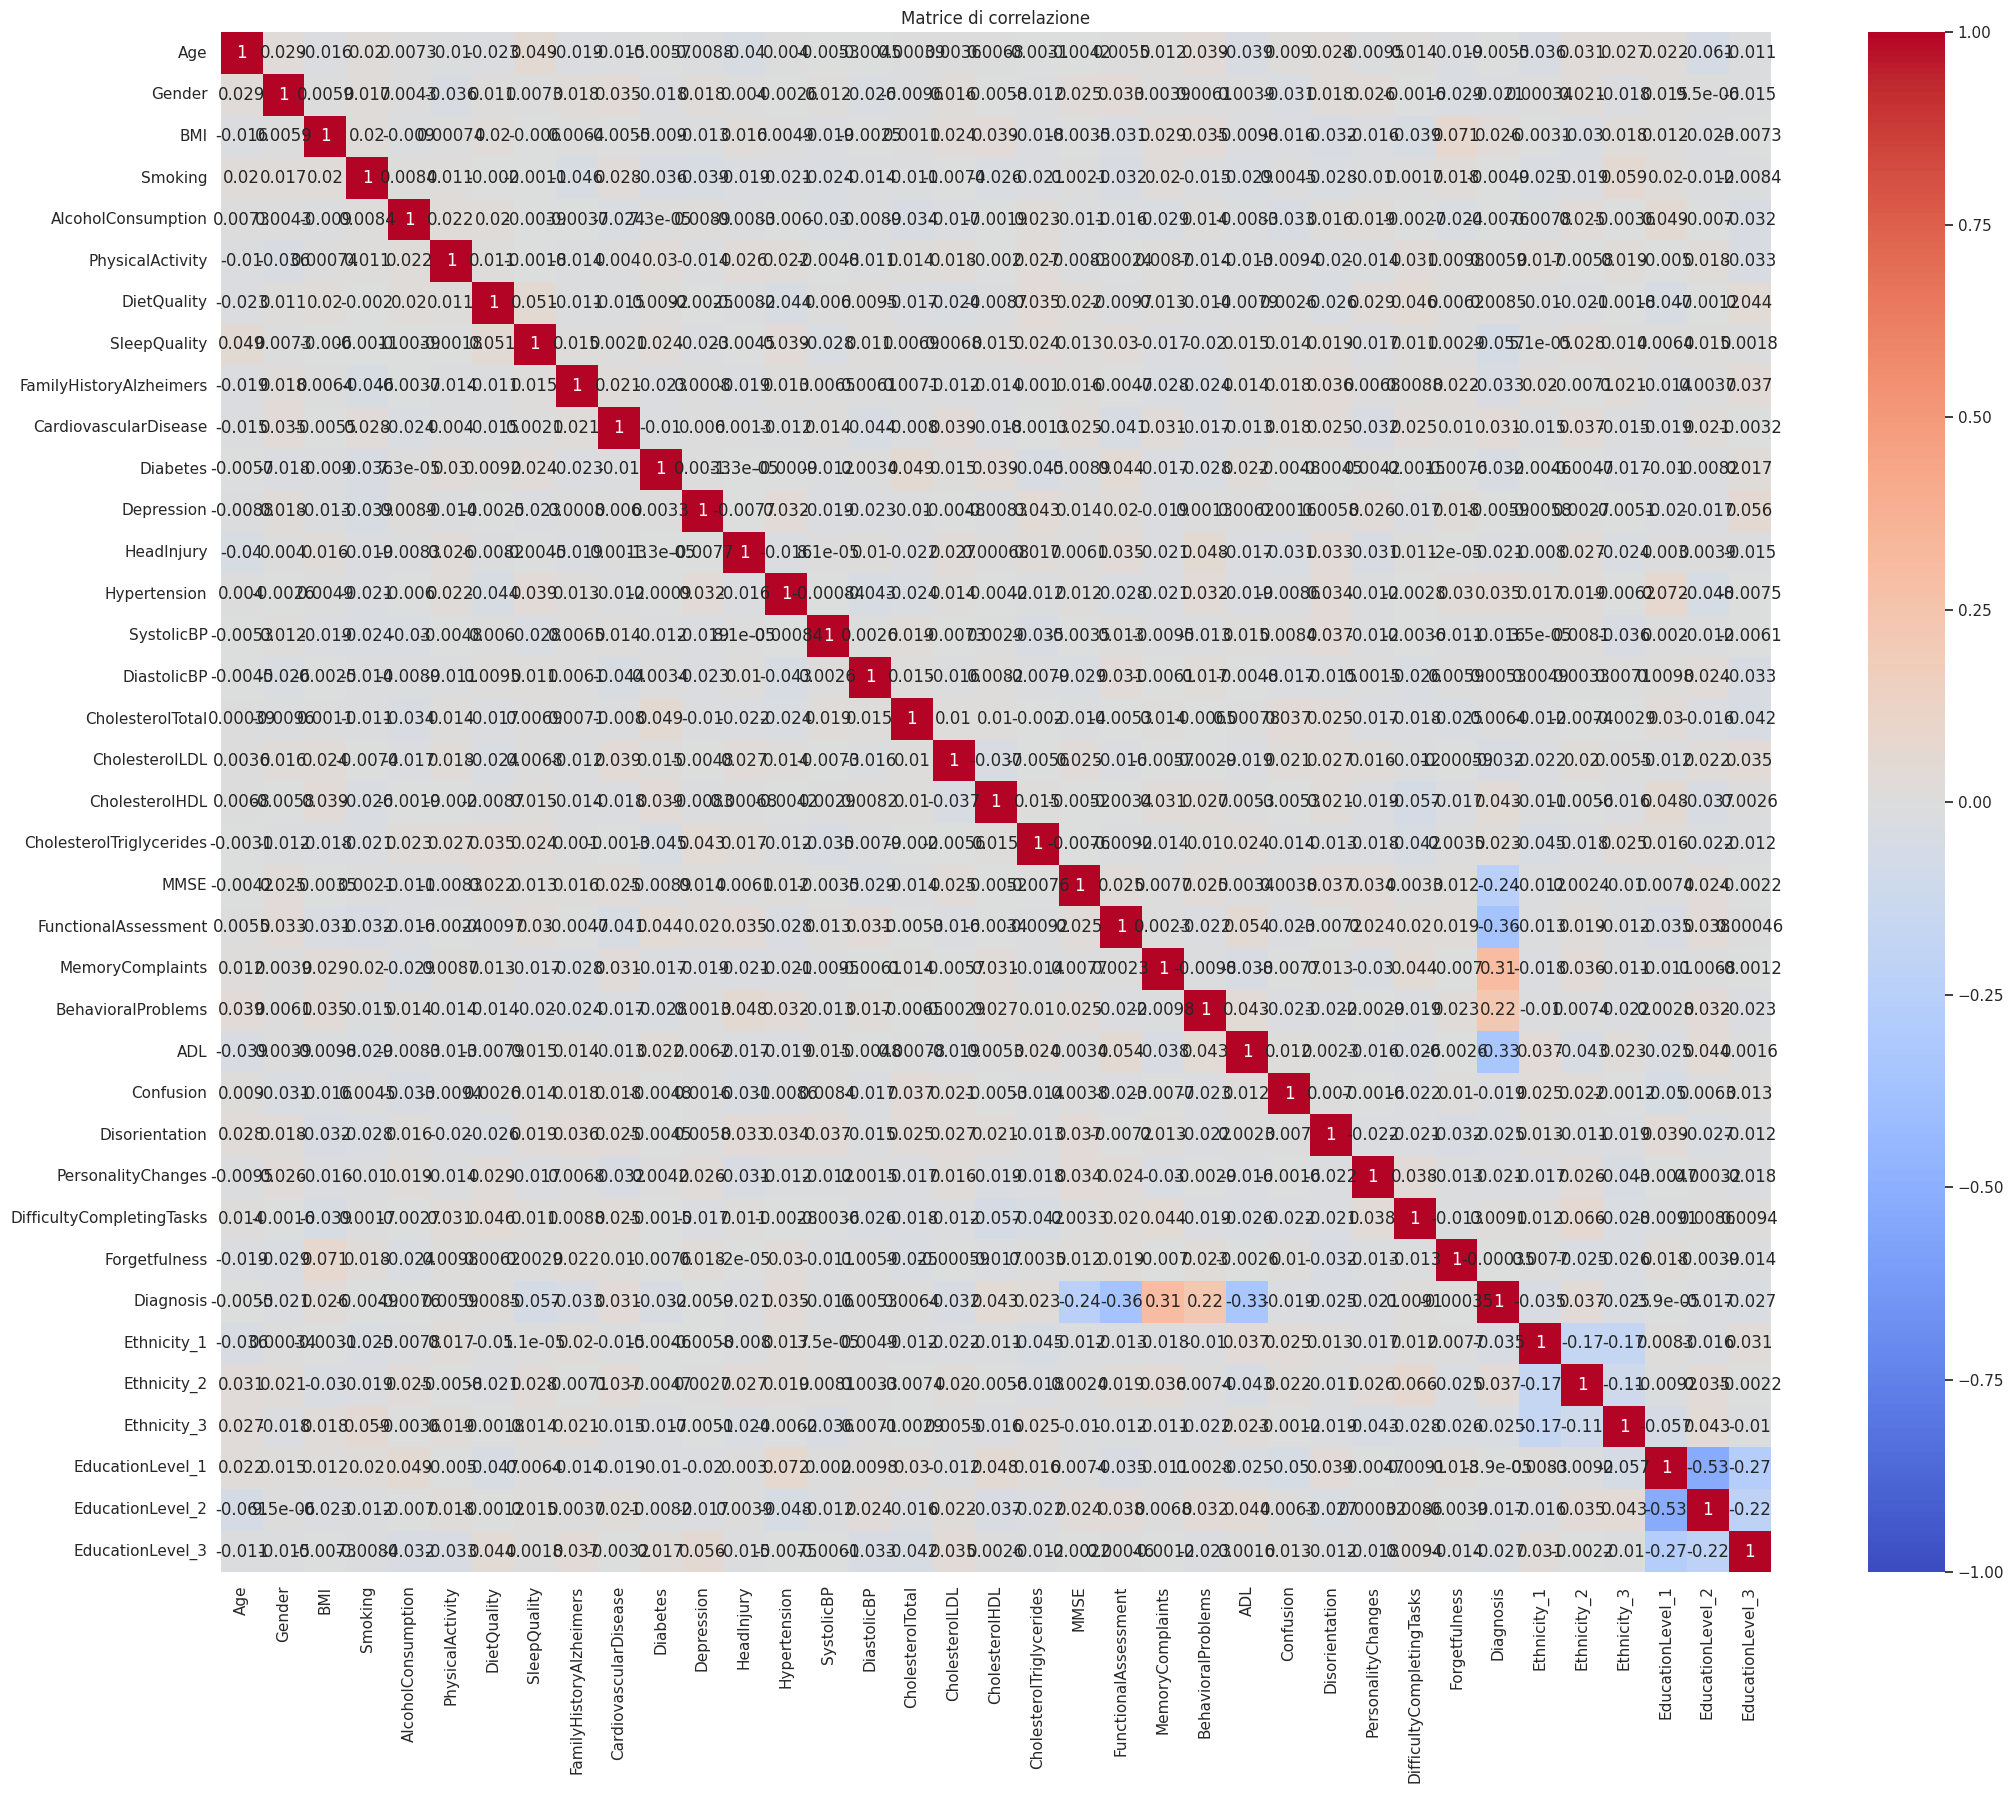


Correlazioni con Potability:


Diagnosis                    1.000000
MemoryComplaints             0.306742
BehavioralProblems           0.224350
CholesterolHDL               0.042584
Ethnicity_2                  0.036854
Hypertension                 0.035080
CardiovascularDisease        0.031490
BMI                          0.026343
CholesterolTriglycerides     0.022672
DifficultyCompletingTasks    0.009069
DietQuality                  0.008506
CholesterolTotal             0.006394
PhysicalActivity             0.005945
DiastolicBP                  0.005293
EducationLevel_1            -0.000039
Forgetfulness               -0.000354
Smoking                     -0.004865
Age                         -0.005488
Depression                  -0.005893
AlcoholConsumption          -0.007618
SystolicBP                  -0.015615
EducationLevel_2            -0.016894
Confusion                   -0.019186
PersonalityChanges          -0.020627
Gender                      -0.020975
HeadInjury                  -0.021411
Disorientation              -0.024648
Ethnicity_3                 -0.024926
EducationLevel_3            -0.027126
Diabetes                    -0.031508
CholesterolLDL              -0.031976
FamilyHistoryAlzheimers     -0.032900
Ethnicity_1                 -0.034712
SleepQuality                -0.056548
MMSE                        -0.237126
ADL                         -0.332346
FunctionalAssessment        -0.364898
Name: Diagnosis, dtype: float64

In [ ]:
# One-Hot encoding alla colonne categoriche
data_alz = pd.get_dummies(data_alz, columns=categorical_features, drop_first=True)

# Calcolo della matrice di correlazione
corr_matrix = data_alz.corr(method="pearson")

# Visualizzazione della matrice di correlazione
plt.figure(figsize=(25,20))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matrice di correlazione")
plt.show()

# Correlazioni con la variabile target
print("\nCorrelazioni con Potability:")
display(corr_matrix['Diagnosis'].sort_values(ascending=False))

### Commento sulla matrice di correlazione
#### Analisi generale
La matrice mostra la correlazione presente tra le varie features e la variabile target (`Diagnosis`). Possiamo vedere che per la maggior parte delle features non abbiamo valori di correlazione lineare significativi.

#### Correlazione con Diagnosis
Possiamo vedere che sono presenti quattro features che hanno un livello rilevante di correlazione con la variabile target. Ossia `MMSE`, `FunctionalAssesment`, `MemoryComplaints` e `ADL`.

#### Mulicollinearità
Non essendoci evidenze di valori di collinearità elevati tra di le features quindi non è necessario rimuoverne nessuna.

#### Implicazioni per il progetto
Nessuna feature va eliminata per multicollinearità, tutta via è possibile addestrare due modelli diversi, uno con tutte le features e uno con le sole quattro features che hanno riportato valori di correlazione rilevanti.

#### Analisi di una feature con un livello di correlazione interessante
Come possiamo vedere dal seguente grafico nel caso della feature  `ADL` (difficoltà nello svolgimento di attività quotidiane, come mangiare, lavarsi i denti, ecc.) il suo valore influenza fortemente la diagnosi finale, infatti valori più bassi indicano difficoltà maggiori.

<Axes: ylabel='Frequency'>

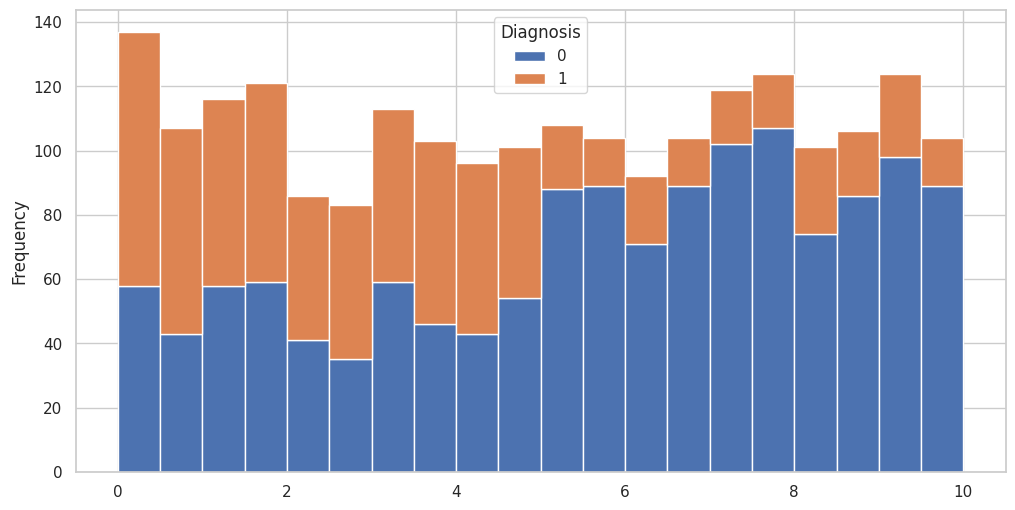

In [ ]:
data_alz.pivot_table(index=data_alz.index, columns="Diagnosis", values="ADL").plot.hist(bins=20, stacked=True, figsize=(12, 6))

## Preparazione dei dati per il training

In [ ]:
# Selezione feature di input e obiettivo
X_alz = data_alz.drop(["Diagnosis"], axis=1)
y_alz = data_alz["Diagnosis"]

In [ ]:
# Split delle variabili in trainig set e test set
X_alz_train, X_alz_test, y_alz_train, y_alz_test = train_test_split(
    X_alz, y_alz,
    test_size = 0.2,
    random_state=250819
)

## SMOTE
Utilizziamo SMOTE per fare un oversamplig per la classe meno numerosa.

In [ ]:
print(f"Distribuzione delle classi prima di SMOTE:  {pd.Series(y_alz_train).value_counts()}")

Distribuzione delle classi prima di SMOTE:  Diagnosis
0    1105
1     614
Name: count, dtype: int64


In [ ]:
smote = SMOTE(random_state=250819)
X_alz_train_resampled, y_alz_train_resampled = smote.fit_resample(X_alz_train, y_alz_train)
print(f"Distribuzione delle classi dopo SMOTE:  {pd.Series(y_alz_train_resampled).value_counts()}")

Distribuzione delle classi dopo SMOTE:  Diagnosis
0    1105
1    1105
Name: count, dtype: int64


## Estrazione feature più significative e visualizzazione

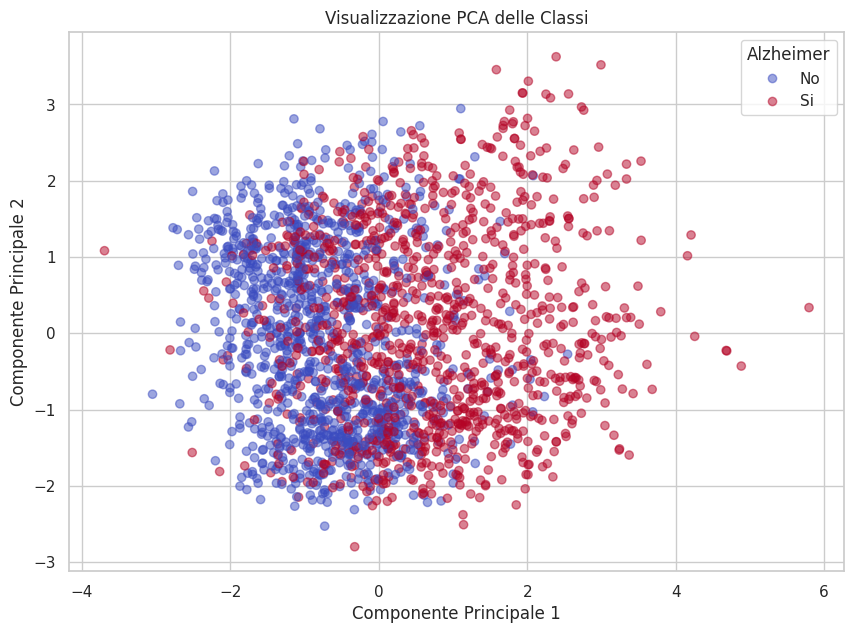

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_alz_train_resampled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Crea il plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_alz_train_resampled, cmap='coolwarm', alpha=0.5)
plt.title('Visualizzazione PCA delle Classi')
plt.xlabel('Componente Principale 1')
plt.ylabel('Componente Principale 2')
plt.legend(title="Alzheimer", handles=scatter.legend_elements()[0], labels=['No', 'Si'])
plt.show()

## Utilizzo di sole feature con correlazione rilevante

### Estraggo solo le feature interessate dal dataset

In [ ]:
X_alz_subset = data_alz[["MMSE", "FunctionalAssessment", "MemoryComplaints", "BehavioralProblems", "ADL"]]

In [ ]:
# Split delle variabili in trainig set e test set
X_alz_subset_train, X_alz_subset_test, y_alz_subset_train, y_alz_subset_test = train_test_split(
    X_alz_subset, y_alz,
    test_size = 0.2,
    random_state=250819
)

## SMOTE
Utilizziamo SMOTE per fare un oversamplig per la classe meno numerosa.

In [ ]:
print(f"Distribuzione delle classi prima di SMOTE:  {pd.Series(y_alz_subset_train).value_counts()}")

Distribuzione delle classi prima di SMOTE:  Diagnosis
0    1105
1     614
Name: count, dtype: int64


In [ ]:
smote = SMOTE(random_state=250819)
X_alz_subset_train_resampled, y_alz_subset_train_resampled = smote.fit_resample(X_alz_subset_train, y_alz_subset_train)
print(f"Distribuzione delle classi dopo SMOTE:  {pd.Series(y_alz_subset_train_resampled).value_counts()}")

Distribuzione delle classi dopo SMOTE:  Diagnosis
0    1105
1    1105
Name: count, dtype: int64


## Estrazione feature più significative e visualizzazione

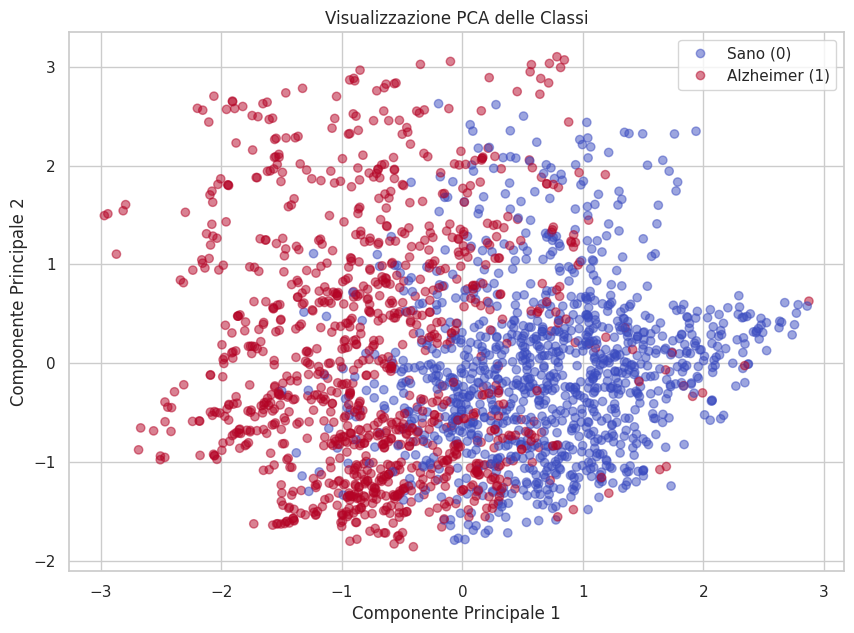

In [ ]:
scaler = StandardScaler()
X_subset_scaled = scaler.fit_transform(X_alz_subset_train_resampled)

pca = PCA(n_components=2)
X_subset_pca = pca.fit_transform(X_subset_scaled)

# Crea il plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_subset_pca[:, 0], X_subset_pca[:, 1], c=y_alz_subset_train_resampled, cmap='coolwarm', alpha=0.5)
plt.title('Visualizzazione PCA delle Classi')
plt.xlabel('Componente Principale 1')
plt.ylabel('Componente Principale 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Sano (0)', 'Alzheimer (1)'])
plt.show()

#Modelli

## Logistic Regression

### Regressione Logistica – Teoria

La **Regressione Logistica** è un modello di classificazione binaria che stima la probabilità che un'istanza appartenga a una delle due classi. Si basa su un classificatore **lineare** combinato con la **funzione sigmoide**, che mappa un output lineare in un intervallo compreso tra 0 e 1:

$$
\sigma(w^\top x + b) = \frac{1}{1 + e^{-(w^\top x + b)}}
$$

#### Interpretazione Probabilistica

- L’output della funzione sigmoide è un valore tra 0 e 1 e può essere interpretato come la **probabilità** che l’istanza appartenga alla **classe positiva (+1)**:
  $$
  \mathbb{P}(Y = +1 \mid X = x) = \sigma(w^\top x + b)
  $$
  $$
  \mathbb{P}(Y = -1 \mid X = x) = 1 - \sigma(w^\top x + b)
  $$
- Se \( w^\top x + b = 0 \), la sigmoide restituisce 0.5 (soglia decisionale).
- Se \( w^\top x + b > 0 \), la probabilità stimata per la classe +1 è maggiore di 0.5.
- Se \( w^\top x + b < 0 \), la probabilità stimata per la classe +1 è minore di 0.5.

#### Estensioni non lineari

La regressione logistica può essere estesa a modelli **non lineari** introducendo trasformazioni polinomiali delle feature:

$$
h_w(x_1, ..., x_n) = \sum_{i,j} w_{ij} x_i x_j + \dots
$$

Queste trasformazioni aumentano la complessità e il rischio di overfitting. Un'alternativa è la **Kernel Logistic Regression**, che consente di modellare relazioni non lineari senza calcolare esplicitamente le trasformazioni.

#### Connessione con le Reti Neurali

Una singola **unità neuronale** con attivazione **sigmoide** è matematicamente equivalente alla regressione logistica. L'output lineare \( a = w^\top x + b \) viene passato alla funzione sigmoide:

$$
f(a) = \frac{1}{1 + e^{-a}}
$$



In [ ]:
def build_logistic_gs():
    lr_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("classifier", LogisticRegression(max_iter=1000))
    ])

    grid = {
        "classifier__C": [0.01, 0.1, 1, 10],
        "classifier__penalty": ['l1', 'l2'],
        "classifier__solver": ['liblinear']  # compatibile con l1 e l2
    }

    skf = StratifiedKFold(5, shuffle=True, random_state=42)
    gs = GridSearchCV(lr_pipe, grid, cv=skf, scoring='f1', n_jobs=-1)
    return gs

### Dataset - Churn

In [ ]:
logistic_gs = build_logistic_gs()
logistic_gs.fit(X_train_res_ch, y_train_res_ch)

print("Migliori parametri Logistic Regression:")
print(logistic_gs.best_params_)

Migliori parametri Logistic Regression:
{'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


True Positives (TP): 407
False Positives (FP): 378
False Negatives (FN): 154
True Negatives (TN): 1171

Accuratezza: 0.75
Precisione (Churn=1): 0.52
Precisione (Churn=0): 0.88
Precisione media: 0.70
Richiamo (Churn=1): 0.73
Richiamo (Churn=0): 0.76
Richiamo medio: 0.74
F1-Score (Churn=1): 0.60
F1-Score (Churn=0): 0.81
F1-Score medio: 0.71


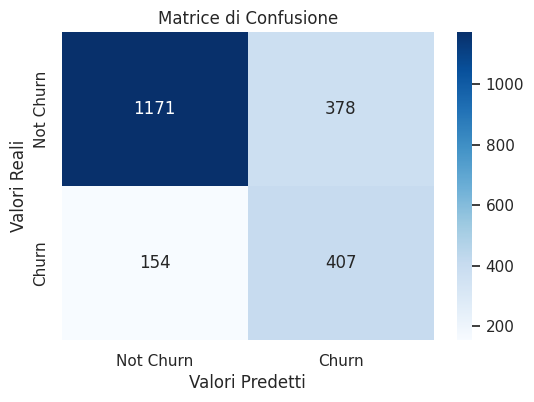


Calcolo del valore del kappa statistic
Kappa statistic value: 0.4270781762781415

Calcolo dell'intervallo di accuratezza per un valore di Z uguale a 1.96
Valore di N: 2110
P minimo: 0.7288996384339451
P massimo: 0.7659340331145758


In [ ]:
best_rf = rf_gs.best_estimator_

evaluation_confusion_matrix(best_rf, X_test_ch, y_test_ch, param_name="Churn")
kappa_statistic(best_rf, X_test_ch, y_test_ch)
intervallo_di_accuratezza(best_rf, X_test_ch, y_test_ch)

### Dataset - Diabete

In [ ]:
logistic_gs = build_logistic_gs()
logistic_gs.fit(X_dia_train_resampled, y_dia_train_resampled)

print("Migliori parametri Logistic Regression:")
print(logistic_gs.best_params_)

Migliori parametri Logistic Regression:
{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


True Positives (TP): 7735
False Positives (FP): 16565
False Negatives (FN): 2794
True Negatives (TN): 41749

Accuratezza: 0.72
Precisione (Diabete=1): 0.32
Precisione (Diabete=0): 0.94
Precisione media: 0.63
Richiamo (Diabete=1): 0.73
Richiamo (Diabete=0): 0.72
Richiamo medio: 0.73
F1-Score (Diabete=1): 0.44
F1-Score (Diabete=0): 0.81
F1-Score medio: 0.63


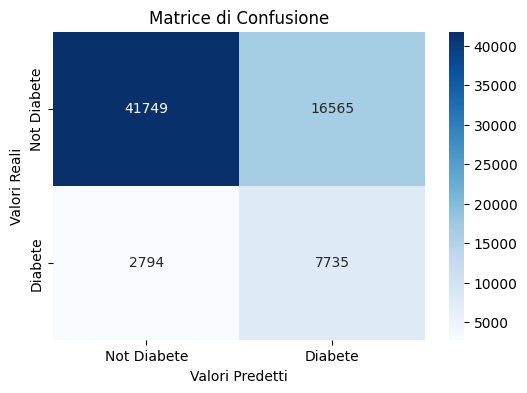


Calcolo del valore del kappa statistic
Kappa statistic value: 0.293364226664357

Calcolo dell'intervallo di accuratezza per un valore di Z uguale a 1.96
Valore di N: 68843
P minimo: 0.7154243415993996
P massimo: 0.7221411196461022


In [ ]:
best_lr= logistic_gs.best_estimator_

evaluation_confusion_matrix(best_lr, X_dia_val, y_dia_val, param_name="Diabete")
kappa_statistic(best_lr, X_dia_val, y_dia_val)
intervallo_di_accuratezza(best_lr, X_dia_val, y_dia_val)

### Dataset Alzheimer


In [ ]:
# Creo la grid search per il modello da allenare su tutte le features e faccio il fit
alz_lr_gs = build_logistic_gs()
alz_lr_gs.fit(X_alz_train_resampled, y_alz_train_resampled)

# Creo la grid search per il modello da allenare solo sulle fetures rilevanti e faccio il fit
alz_lr_gs_subset = build_logistic_gs()
alz_lr_gs_subset.fit(X_alz_subset_train_resampled, y_alz_subset_train_resampled)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear']},
             scoring='f1')

In [ ]:
# Mostro i migliori parametri e lo score del miglior modello allenato su tutte le features
print("\nModello con tutte le features")
display(pd.Series(alz_lr_gs.best_params_))
best_alz_lr_gs = alz_lr_gs.best_estimator_
print(best_alz_lr_gs.score(X_alz_test, y_alz_test))

print("\nModello allenato sul subset")
# Mostro i migliori parametri e lo score del miglior modello allenato sul sottoinsieme di features
display(pd.Series(alz_lr_gs_subset.best_params_))
best_alz_lr_gs_subset = alz_lr_gs_subset.best_estimator_
print(best_alz_lr_gs_subset.score(X_alz_subset_test, y_alz_subset_test))


Modello con tutte le features


classifier__C                  1
classifier__penalty           l1
classifier__solver     liblinear
dtype: object

0.8488372093023255

Modello allenato sul subset


classifier__C               0.01
classifier__penalty           l1
classifier__solver     liblinear
dtype: object

0.8534883720930233



Modello con tutte le features
True Positives (TP): 115
False Positives (FP): 34
False Negatives (FN): 31
True Negatives (TN): 250

Accuratezza: 0.85
Precisione (Diagnosis=1): 0.77
Precisione (Diagnosis=0): 0.89
Precisione media: 0.83
Richiamo (Diagnosis=1): 0.79
Richiamo (Diagnosis=0): 0.88
Richiamo medio: 0.83
F1-Score (Diagnosis=1): 0.78
F1-Score (Diagnosis=0): 0.88
F1-Score medio: 0.83


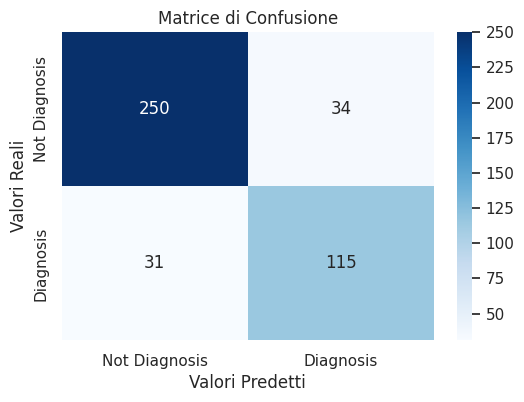


Calcolo del valore del kappa statistic
Kappa statistic value: 0.6646348779726907

Calcolo dell'intervallo di accuratezza per un valore di Z uguale a 1.96
Valore di N: 430
P minimo: 0.8118996843120507
P massimo: 0.8795969356524709

Modello allenato sul subset
True Positives (TP): 126
False Positives (FP): 43
False Negatives (FN): 20
True Negatives (TN): 241

Accuratezza: 0.85
Precisione (Diagnosis=1): 0.75
Precisione (Diagnosis=0): 0.92
Precisione media: 0.83
Richiamo (Diagnosis=1): 0.86
Richiamo (Diagnosis=0): 0.85
Richiamo medio: 0.86
F1-Score (Diagnosis=1): 0.80
F1-Score (Diagnosis=0): 0.88
F1-Score medio: 0.84


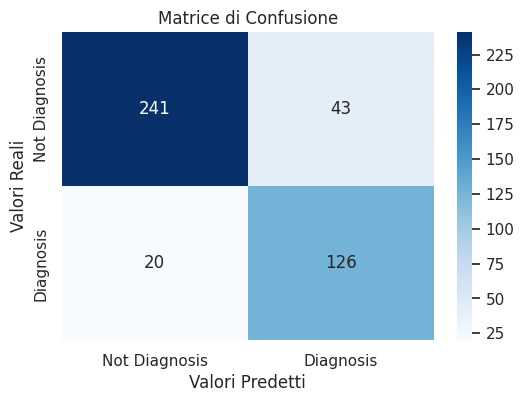


Calcolo del valore del kappa statistic
Kappa statistic value: 0.6853731620635991

Calcolo dell'intervallo di accuratezza per un valore di Z uguale a 1.96
Valore di N: 430
P minimo: 0.8169358386481911
P massimo: 0.8837807362491908


In [ ]:
# Analisi dei risulati ottenuti con il modello allenato su tutte le features
print("\nModello con tutte le features")
evaluation_confusion_matrix(best_alz_lr_gs, X_alz_test, y_alz_test, param_name="Diagnosis")
kappa_statistic(best_alz_lr_gs, X_alz_test, y_alz_test)
intervallo_di_accuratezza(best_alz_lr_gs, X_alz_test, y_alz_test)

# Analisi dei risulati ottenuti con il modello allenato sul subset delle features
print("\nModello allenato sul subset")
evaluation_confusion_matrix(best_alz_lr_gs_subset, X_alz_subset_test, y_alz_subset_test, param_name="Diagnosis")
kappa_statistic(best_alz_lr_gs_subset, X_alz_subset_test, y_alz_subset_test)
intervallo_di_accuratezza(best_alz_lr_gs_subset, X_alz_subset_test, y_alz_subset_test)

In [ ]:
# Confronto tra i due modelli ottenuti
confronta_modelli(best_alz_lr_gs, best_alz_lr_gs_subset, X_alz_test, X_alz_subset_test, y_alz_test, y_alz_subset_test)

D minimo: -0.042925025580437974
D massimo: 0.05222735116183352
Lo zero è contenuto nell'intervallo. Quindi la differenza tra i due modelli non è significativa


## Random Forest

**Random forest** è un algoritmo di classificazione basato sugli alberi di regressione. Questo si basa sulla tecnica di *bagging*, ovvero vengono creati una molteplicità di alberi usando sottoinsiemi non disgiunti del dataset originale. Questa tecnica permette di avere alberi calcolati su sottoinsiemi sempre diversi, potendo ottenere così prestazioni migliori.

Il valore predetto da Random Forest finale è rappresentato dalla media delle previsioni di tutti gli alberi decisionali e l'efficacia è migliore di qualsiasi singolo albero della random forest.

Inoltre, la struttura dell'algoritmo permette di eseguirlo in parallelo.

Per quanto riguarda i parametri dell'algoritmo:

* `max_samples`: rappresenta il numero (se intero) o la percentuale (se numero reale compreso tra 0 e 1) di istanze del training set udate per addestrare ogni albero;

* `max_features`: indica il numero di features casuali che ha ogni albero come sottoinsieme casuale di tutte le features del training set;

* `max_depth`: indica la profondità massima di ogni albero;
* `n_estimators`: indica il numero di alberi.

In [ ]:
# Pipeline per Random Forest
def get_gs_rf():
  pipeline_rf = Pipeline([
      ('scaler', StandardScaler()),
      ('rf', RandomForestClassifier(random_state=42))
  ])

  grid = {
      "rf__max_samples": [0.2,0.4,0.6],
      "rf__max_features": ["sqrt"],
      "rf__n_estimators": [200,400],
      "rf__max_depth": [None, 5, 15],
  }

  skf = StratifiedKFold(5, shuffle=True)
  gs = GridSearchCV(pipeline_rf, grid, cv=skf, scoring="f1", n_jobs=-1)
  return gs

### Dataset - Churn

In [ ]:
rf_gs = get_gs_rf()
rf_gs.fit(X_train_res_ch, y_train_res_ch)

print("Migliori parametri Random Forest:")
print(rf_gs.best_params_)

Migliori parametri Random Forest:
{'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__max_samples': 0.6, 'rf__n_estimators': 400}


True Positives (TP): 407
False Positives (FP): 378
False Negatives (FN): 154
True Negatives (TN): 1171

Accuratezza: 0.75
Precisione (Churn=1): 0.52
Precisione (Churn=0): 0.88
Precisione media: 0.70
Richiamo (Churn=1): 0.73
Richiamo (Churn=0): 0.76
Richiamo medio: 0.74
F1-Score (Churn=1): 0.60
F1-Score (Churn=0): 0.81
F1-Score medio: 0.71


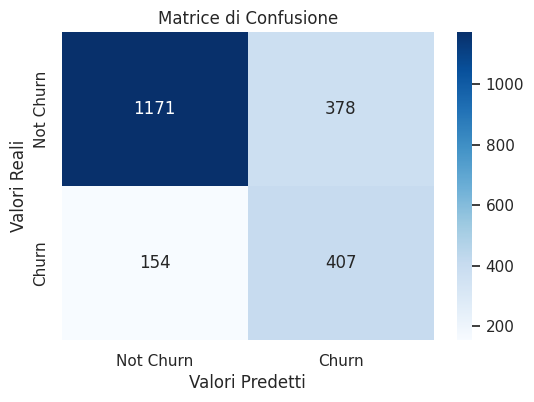


Calcolo del valore del kappa statistic
Kappa statistic value: 0.4270781762781415

Calcolo dell'intervallo di accuratezza per un valore di Z uguale a 1.96
Valore di N: 2110
P minimo: 0.7288996384339451
P massimo: 0.7659340331145758


In [ ]:
best_rf_model = rf_gs.best_estimator_

evaluation_confusion_matrix(best_rf_model, X_test_ch, y_test_ch, param_name='Churn')
kappa_statistic(best_rf_model, X_test_ch, y_test_ch)
intervallo_di_accuratezza(best_rf_model, X_test_ch, y_test_ch)


### Dataset - Diabete

In [ ]:
dia_gs_rf = get_gs_rf()
dia_gs_rf.fit(X_dia_train_resampled, y_dia_train_resampled)
analyze_grid_search_results(dia_gs_rf)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Migliori parametri trovati: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__max_samples': 0.6, 'rf__n_estimators': 400}
Miglior punteggio medio CV: 0.9567233915068124

Dettagli dei risultati della Grid Search (prime 10 combinazioni):
   param_rf__max_depth param_rf__max_features  param_rf__max_samples  param_rf__n_estimators  mean_test_score  std_test_score  rank_test_score
5                 None                   sqrt                    0.6                     400         0.956723        0.000493                1
4                 None                   sqrt                    0.6                     200         0.956381        0.000706                2
2                 None                   sqrt                    0.4                     200         0.952253        0.000317                3
3                 None                   sqrt                    0.4                     400         0.952242        0.000273                4
1                 None                   s

True Positives (TP): 7162
False Positives (FP): 15904
False Negatives (FN): 3367
True Negatives (TN): 42410

Accuratezza: 0.72
Precisione (Diabete=1): 0.31
Precisione (Diabete=0): 0.93
Precisione media: 0.62
Richiamo (Diabete=1): 0.68
Richiamo (Diabete=0): 0.73
Richiamo medio: 0.70
F1-Score (Diabete=1): 0.43
F1-Score (Diabete=0): 0.81
F1-Score medio: 0.62


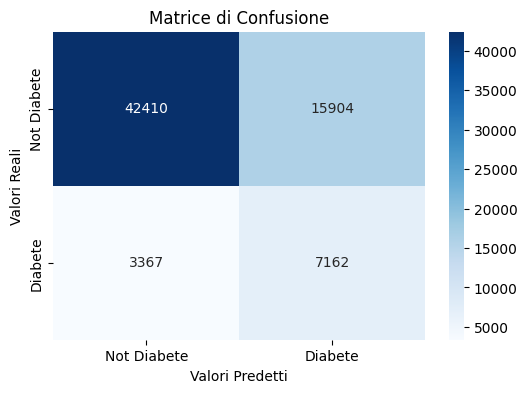


Calcolo del valore del kappa statistic
Kappa statistic value: 0.2738739790555943

Calcolo dell'intervallo di accuratezza per un valore di Z uguale a 1.96
Valore di N: 68843
P minimo: 0.7167072045081612
P massimo: 0.7234146557806338


In [ ]:
best_rf_dia= dia_gs_rf.best_estimator_

evaluation_confusion_matrix(best_rf_dia, X_dia_val, y_dia_val, param_name="Diabete")
kappa_statistic(best_rf_dia, X_dia_val, y_dia_val)
intervallo_di_accuratezza(best_rf_dia, X_dia_val, y_dia_val)

### Dataset Alzheimer


In [ ]:
# Creo la grid search per il modello da allenare su tutte le features e faccio il fit
alz_rf_gs = get_gs_rf()
alz_rf_gs.fit(X_alz_train_resampled, y_alz_train_resampled)

# Creo la grid search per il modello da allenare solo sulle fetures rilevanti e faccio il fit
alz_rf_gs_subset = get_gs_rf()
alz_rf_gs_subset.fit(X_alz_subset_train_resampled, y_alz_subset_train_resampled)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 5, 15],
                         'rf__max_features': ['sqrt'],
                         'rf__max_samples': [0.2, 0.4, 0.6],
                         'rf__n_estimators': [200, 400]},
             scoring='f1')

In [ ]:
# Mostro i migliori parametri e lo score del miglior modello allenato su tutte le features
print("\nModello con tutte le features")
display(pd.Series(alz_rf_gs.best_params_))
best_alz_rf_gs = alz_rf_gs.best_estimator_
print(best_alz_rf_gs.score(X_alz_test, y_alz_test))

print("\nModello allenato sul subset")
# Mostro i migliori parametri e lo score del miglior modello allenato sul sottoinsieme di features
display(pd.Series(alz_rf_gs_subset.best_params_))
best_alz_rf_gs_subset = alz_rf_gs_subset.best_estimator_
print(best_alz_rf_gs_subset.score(X_alz_subset_test, y_alz_subset_test))


Modello con tutte le features


rf__max_depth         15
rf__max_features    sqrt
rf__max_samples      0.6
rf__n_estimators     400
dtype: object

0.9488372093023256

Modello allenato sul subset


rf__max_depth       None
rf__max_features    sqrt
rf__max_samples      0.6
rf__n_estimators     200
dtype: object

0.9511627906976744



Modello con tutte le features
True Positives (TP): 135
False Positives (FP): 11
False Negatives (FN): 11
True Negatives (TN): 273

Accuratezza: 0.95
Precisione (Diagnosis=1): 0.92
Precisione (Diagnosis=0): 0.96
Precisione media: 0.94
Richiamo (Diagnosis=1): 0.92
Richiamo (Diagnosis=0): 0.96
Richiamo medio: 0.94
F1-Score (Diagnosis=1): 0.92
F1-Score (Diagnosis=0): 0.96
F1-Score medio: 0.94


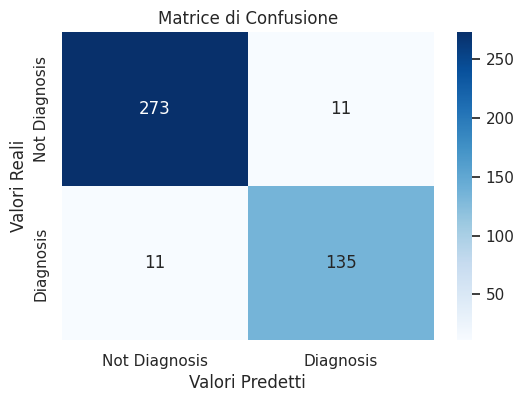


Calcolo del valore del kappa statistic
Kappa statistic value: 0.8859251398803782

Calcolo dell'intervallo di accuratezza per un valore di Z uguale a 1.96
Valore di N: 430
P minimo: 0.9237522694759319
P massimo: 0.9659733815450859

Modello allenato sul subset
True Positives (TP): 135
False Positives (FP): 10
False Negatives (FN): 11
True Negatives (TN): 274

Accuratezza: 0.95
Precisione (Diagnosis=1): 0.93
Precisione (Diagnosis=0): 0.96
Precisione media: 0.95
Richiamo (Diagnosis=1): 0.92
Richiamo (Diagnosis=0): 0.96
Richiamo medio: 0.94
F1-Score (Diagnosis=1): 0.93
F1-Score (Diagnosis=0): 0.96
F1-Score medio: 0.95


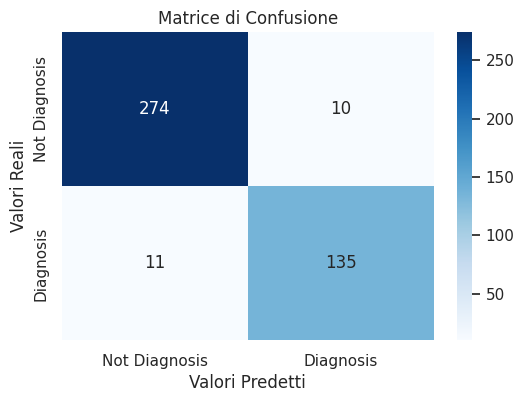


Calcolo del valore del kappa statistic
Kappa statistic value: 0.8909288561420461

Calcolo dell'intervallo di accuratezza per un valore di Z uguale a 1.96
Valore di N: 430
P minimo: 0.9264969098002412
P massimo: 0.9678387186872067


In [ ]:
# Analisi dei risulati ottenuti con il modello allenato su tutte le features
print("\nModello con tutte le features")
evaluation_confusion_matrix(best_alz_rf_gs, X_alz_test, y_alz_test, param_name="Diagnosis")
kappa_statistic(best_alz_rf_gs, X_alz_test, y_alz_test)
intervallo_di_accuratezza(best_alz_rf_gs, X_alz_test, y_alz_test)

# Analisi dei risulati ottenuti con il modello allenato sul subset delle features
print("\nModello allenato sul subset")
evaluation_confusion_matrix(best_alz_rf_gs_subset, X_alz_subset_test, y_alz_subset_test, param_name="Diagnosis")
kappa_statistic(best_alz_rf_gs_subset, X_alz_subset_test, y_alz_subset_test)
intervallo_di_accuratezza(best_alz_rf_gs_subset, X_alz_subset_test, y_alz_subset_test)

In [ ]:
# Confronto tra i due modelli ottenuti
confronta_modelli(best_alz_rf_gs, best_alz_rf_gs_subset, X_alz_test, X_alz_subset_test, y_alz_test, y_alz_subset_test)

D minimo: -0.026806899146415195
D massimo: 0.031458061937112744
Lo zero è contenuto nell'intervallo. Quindi la differenza tra i due modelli non è significativa


## XGBoost

### Come funziona XGBoost: costruzione dell'albero

XGBoost è un algoritmo di boosting che costruisce alberi in modo **greedy**, ottimizzando una funzione obiettivo composta da **loss di training** e **penalizzazione per la complessità**. Il processo di crescita di ogni albero segue questi passaggi:

1. **Inizializzazione**  
   Si parte da un albero con una singola foglia (profondità 0).

2. **Ricerca degli split**  
   - Per ogni nodo foglia esistente, si valuta l'effetto di uno split su tutte le feature e soglie possibili.
   - Per ogni split candidato, si calcolano:  
     - \( G_L, H_L \): somma dei gradienti e degli hessiani per il figlio sinistro  
     - \( G_R, H_R \): somma dei gradienti e degli hessiani per il figlio destro  

   Si calcola il **guadagno (Gain)** dello split come riduzione della funzione obiettivo:

   $$
   \text{Gain} = \left( \frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{(G_L + G_R)^2}{H_L + H_R + \lambda} \right) - \gamma
   $$

   Dove:  
   - \( \lambda \) è il termine di regolarizzazione L2  
   - \( \gamma \) è il costo per aggiungere una nuova foglia

3. **Scelta dello split ottimale**  
   - Si seleziona lo split che massimizza il guadagno.
   - Lo split è effettuato **solo se** il guadagno è positivo.

4. **Crescita iterativa**  
   - Si continua finché non si raggiunge la profondità massima o non ci sono più split con guadagno positivo.

> In questo modo, **XGBoost bilancia accuratezza e complessità**, evitando overfitting e producendo alberi molto efficienti per la classificazione o la regressione.


In [ ]:
def build_xgb_gs():
    xgb_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("classifier", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ])

    grid = {
        "classifier__learning_rate": [0.05, 0.1, 0.2],
        "classifier__max_depth": [3, 5, 7],
        "classifier__scale_pos_weight": [1, 2, 3],
        "classifier__n_estimators": [100, 200]
    }

    skf = StratifiedKFold(5, shuffle=True, random_state=42)
    gs = GridSearchCV(xgb_pipe, grid, cv=skf, scoring='f1', n_jobs=-1)
    return gs

### Dataset - Churn

In [ ]:
xgb_gs = build_xgb_gs()
xgb_gs.fit(X_train_res_ch, y_train_res_ch)

print("Migliori parametri XGBoost:")
print(xgb_gs.best_params_)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:45:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Migliori parametri XGBoost:
{'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 1}


True Positives (TP): 392
False Positives (FP): 353
False Negatives (FN): 169
True Negatives (TN): 1196

Accuratezza: 0.75
Precisione (Churn=1): 0.53
Precisione (Churn=0): 0.88
Precisione media: 0.70
Richiamo (Churn=1): 0.70
Richiamo (Churn=0): 0.77
Richiamo medio: 0.74
F1-Score (Churn=1): 0.60
F1-Score (Churn=0): 0.82
F1-Score medio: 0.71


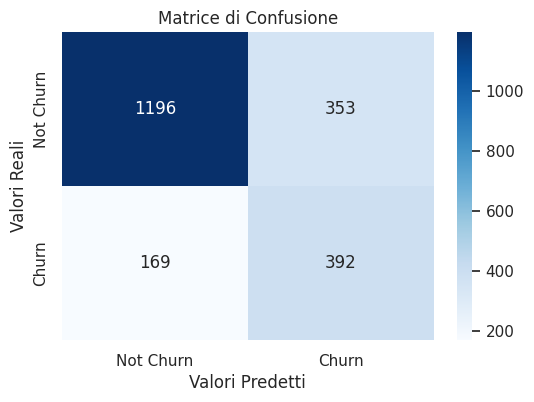


Calcolo del valore del kappa statistic
Kappa statistic value: 0.42627502252874044

Calcolo dell'intervallo di accuratezza per un valore di Z uguale a 1.96
Valore di N: 2110
P minimo: 0.7337469119005121
P massimo: 0.7705482065227416


In [ ]:
best_xgb = xgb_gs.best_estimator_

evaluation_confusion_matrix(best_xgb, X_test_ch, y_test_ch, param_name="Churn")
kappa_statistic(best_xgb, X_test_ch, y_test_ch)
intervallo_di_accuratezza(best_xgb, X_test_ch, y_test_ch)

### Dataset - Diabete

In [ ]:
dia_gs_xg = build_xgb_gs()
dia_gs_xg.fit(X_dia_train_resampled, y_dia_train_resampled)
analyze_grid_search_results(dia_gs_xg)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:57:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Migliori parametri trovati: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 1}
Miglior punteggio medio CV: 0.9304236223485578

Dettagli dei risultati della Grid Search (prime 10 combinazioni):
    param_classifier__learning_rate  param_classifier__max_depth  param_classifier__n_estimators  param_classifier__scale_pos_weight  mean_test_score  std_test_score  rank_test_score
51                              0.2                            7                             200                                   1         0.930424        0.000802                1
52                              0.2                            7                             200                                   2         0.926902        0.001087                2
48                              0.2                            7                             100                                   1         0.924153        0.000558             

True Positives (TP): 6922
False Positives (FP): 13345
False Negatives (FN): 3607
True Negatives (TN): 44969

Accuratezza: 0.75
Precisione (Diabete=1): 0.34
Precisione (Diabete=0): 0.93
Precisione media: 0.63
Richiamo (Diabete=1): 0.66
Richiamo (Diabete=0): 0.77
Richiamo medio: 0.71
F1-Score (Diabete=1): 0.45
F1-Score (Diabete=0): 0.84
F1-Score medio: 0.65


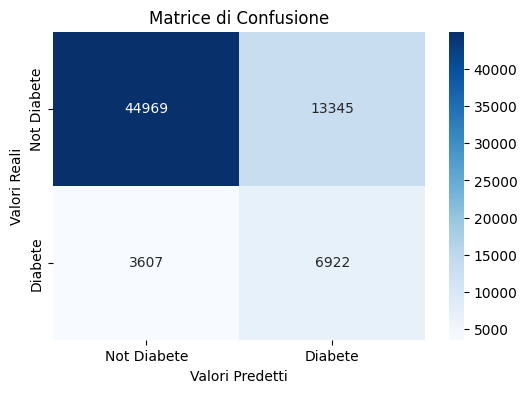


Calcolo del valore del kappa statistic
Kappa statistic value: 0.3108001965068885

Calcolo dell'intervallo di accuratezza per un valore di Z uguale a 1.96
Valore di N: 68843
P minimo: 0.7505261781763471
P massimo: 0.7569626069010499


In [ ]:
best_gs_dia= dia_gs_xg.best_estimator_

evaluation_confusion_matrix(best_gs_dia, X_dia_val, y_dia_val, param_name="Diabete")
kappa_statistic(best_gs_dia, X_dia_val, y_dia_val)
intervallo_di_accuratezza(best_gs_dia, X_dia_val, y_dia_val)

### Dataset Alzheimer

In [ ]:
# Creo la grid search per il modello da allenare su tutte le features e faccio il fit
alz_xgb_gs = build_xgb_gs()
alz_xgb_gs.fit(X_alz_train_resampled, y_alz_train_resampled)

# Creo la grid search per il modello da allenare solo sulle fetures rilevanti e faccio il fit
alz_xgb_gs_subset = build_xgb_gs()
alz_xgb_gs_subset.fit(X_alz_subset_train_resampled, y_alz_subset_train_resampled)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:22:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.05, 0.1, 0.2],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [100, 200],
                         'classifier__scale_pos_weight': [1, 2, 3]},
             scoring='f1')

In [ ]:
# Mostro i migliori parametri e lo score del miglior modello allenato su tutte le features
print("\nModello con tutte le features")
display(pd.Series(alz_xgb_gs.best_params_))
best_alz_xgb_gs = alz_xgb_gs.best_estimator_
print(best_alz_xgb_gs.score(X_alz_test, y_alz_test))

print("\nModello allenato sul subset")
# Mostro i migliori parametri e lo score del miglior modello allenato sul sottoinsieme di features
display(pd.Series(alz_xgb_gs_subset.best_params_))
best_alz_xgb_gs_subset = alz_xgb_gs_subset.best_estimator_
print(best_alz_xgb_gs_subset.score(X_alz_subset_test, y_alz_subset_test))


Modello con tutte le features


classifier__learning_rate         0.2
classifier__max_depth             7.0
classifier__n_estimators        100.0
classifier__scale_pos_weight      2.0
dtype: float64

0.9488372093023256

Modello allenato sul subset


classifier__learning_rate         0.05
classifier__max_depth             3.00
classifier__n_estimators        100.00
classifier__scale_pos_weight      1.00
dtype: float64

0.9651162790697675



Modello con tutte le features
True Positives (TP): 135
False Positives (FP): 11
False Negatives (FN): 11
True Negatives (TN): 273

Accuratezza: 0.95
Precisione (Diagnosis=1): 0.92
Precisione (Diagnosis=0): 0.96
Precisione media: 0.94
Richiamo (Diagnosis=1): 0.92
Richiamo (Diagnosis=0): 0.96
Richiamo medio: 0.94
F1-Score (Diagnosis=1): 0.92
F1-Score (Diagnosis=0): 0.96
F1-Score medio: 0.94


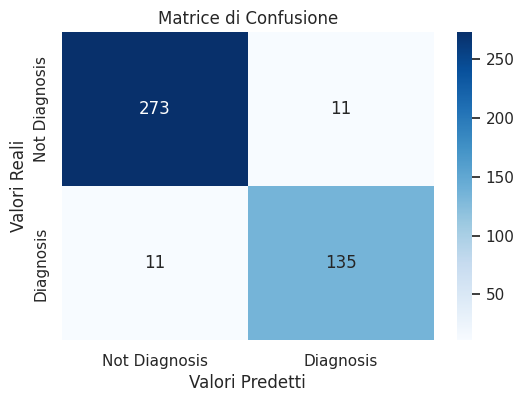


Calcolo del valore del kappa statistic
Kappa statistic value: 0.8859251398803782

Calcolo dell'intervallo di accuratezza per un valore di Z uguale a 1.96
Valore di N: 430
P minimo: 0.9237522694759319
P massimo: 0.9659733815450859

Modello allenato sul subset
True Positives (TP): 139
False Positives (FP): 8
False Negatives (FN): 7
True Negatives (TN): 276

Accuratezza: 0.97
Precisione (Diagnosis=1): 0.95
Precisione (Diagnosis=0): 0.98
Precisione media: 0.96
Richiamo (Diagnosis=1): 0.95
Richiamo (Diagnosis=0): 0.97
Richiamo medio: 0.96
F1-Score (Diagnosis=1): 0.95
F1-Score (Diagnosis=0): 0.97
F1-Score medio: 0.96


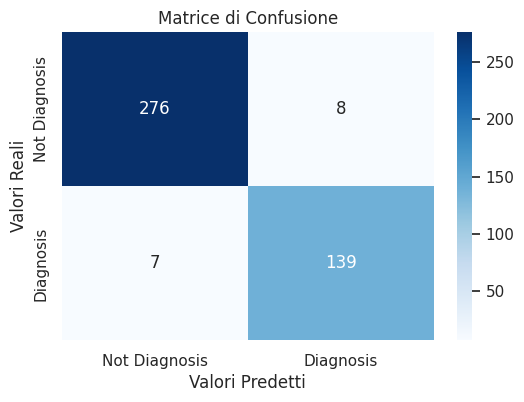


Calcolo del valore del kappa statistic
Kappa statistic value: 0.9223509016926301

Calcolo dell'intervallo di accuratezza per un valore di Z uguale a 1.96
Valore di N: 430
P minimo: 0.9432473378823572
P massimo: 0.9787481554036717


In [ ]:
# Analisi dei risulati ottenuti con il modello allenato su tutte le features
print("\nModello con tutte le features")
evaluation_confusion_matrix(best_alz_xgb_gs, X_alz_test, y_alz_test, param_name="Diagnosis")
kappa_statistic(best_alz_xgb_gs, X_alz_test, y_alz_test)
intervallo_di_accuratezza(best_alz_xgb_gs, X_alz_test, y_alz_test)

# Analisi dei risulati ottenuti con il modello allenato sul subset delle features
print("\nModello allenato sul subset")
evaluation_confusion_matrix(best_alz_xgb_gs_subset, X_alz_subset_test, y_alz_subset_test, param_name="Diagnosis")
kappa_statistic(best_alz_xgb_gs_subset, X_alz_subset_test, y_alz_subset_test)
intervallo_di_accuratezza(best_alz_xgb_gs_subset, X_alz_subset_test, y_alz_subset_test)

In [ ]:
# Confronto tra i due modelli ottenuti
confronta_modelli(best_alz_xgb_gs, best_alz_xgb_gs_subset, X_alz_test, X_alz_subset_test, y_alz_test, y_alz_subset_test)

D minimo: -0.010822189283889228
D massimo: 0.04338032881877296
Lo zero è contenuto nell'intervallo. Quindi la differenza tra i due modelli non è significativa


## SVM

Il modello SVM (Support Vector Machine) è un classificatore che ha come obiettivo principale quello di trovare un iperpiano ottimale che separi i dati appartenenti a classi differenti. In termini semplici, si tratta di identificare il margine massimo tra i punti di classi opposte, in modo da garantire una separazione il più chiara possibile. Questo margine è definito dai cosiddetti support vectors, ovvero i punti di dati più vicini all'iperpiano di separazione.

L'SVM può essere esteso a problemi non linearmente separabili grazie all'uso di kernel, che trasformano lo spazio dei dati in uno spazio di dimensione superiore dove la separazione è più semplice.

Vediamo più nello specifico quelli che sono i principali parametri del classificatore:
* `kernel`: specifica la funzine kernel utilizzata per trasformare i dati nello spazio delle feature.
  Le opzioni passate sono:
  * `linear`: nessuna trasformazione, utilizza un iperpiano lineare.
  * `rfb (Gaussian Radial Basis)`: permette di separare i dati non lineari mappandoli in uno spazio di dimensione più elevata. Corrisponde ad una somma di gaussiane centrate sui support vectors.
  * `sigmoid`: simula il comportamento di una rete neurale semplice, in particolare della funzione di attivazione omonima.
* `C`: è il parametro di regolarizzazione. Un valore basso di C permette un margine più ampio ma tollera più errori di classificazione, mentre un valore alto tende a ridurre gli errori ma può portare a overfitting.
* `gamma`: è un parametro che indica quanta influenza ha un singolo punto di training nella funzione RFB o sigmoid. Al aumentare di gamma aumenta la flessibilità del decision boudary (fino ad arrivare al caso estremo in cui ogni punto è un decision bounday).
  Le opzioni passate sono:
  * `scale`: usa la seguente formula $ \frac{1}{n_{features} * Var(X)} $
  * `auto`: usa la seguente formula $ \frac{1}{n_{features}} $
  * `valori numerici`

In [35]:
def build_svm_gs():
  svm_pipe = Pipeline([
      ("scaler", StandardScaler()),
      ("model", SVC(probability=True, random_state=42))
  ])

  grid = {
      "model__gamma": ["scale"],
      "model__C": [10],
      "model__kernel": ["linear"],
      "model__probability": [True]
  }

  skf = StratifiedKFold(2, shuffle=True)

  gs = GridSearchCV(
      estimator=svm_pipe,
      param_grid=grid,
      cv=skf,
      scoring="accuracy",
      n_jobs=-1,
      verbose=2
  )

  return gs

### Dataset - Churn

In [ ]:
svm_gs = build_svm_gs()
svm_gs.fit(X_train_res_ch, y_train_res_ch)
print("Migliori parametri SVM:")
print(svm_gs.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Migliori parametri SVM:
{'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'linear', 'model__probability': True}


True Positives (TP): 396
False Positives (FP): 344
False Negatives (FN): 165
True Negatives (TN): 1205

Accuratezza: 0.76
Precisione (Churn=1): 0.54
Precisione (Churn=0): 0.88
Precisione media: 0.71
Richiamo (Churn=1): 0.71
Richiamo (Churn=0): 0.78
Richiamo medio: 0.74
F1-Score (Churn=1): 0.61
F1-Score (Churn=0): 0.83
F1-Score medio: 0.72


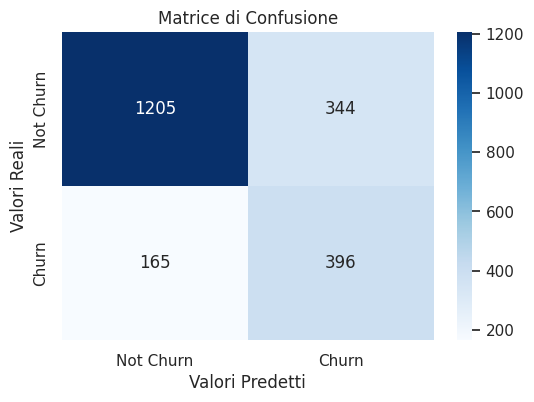


Calcolo del valore del kappa statistic
Kappa statistic value: 0.43911992187296006

Calcolo dell'intervallo di accuratezza per un valore di Z uguale a 1.96
Valore di N: 2110
P minimo: 0.7400528187473073
P massimo: 0.7765421806130988


In [ ]:
evaluation_confusion_matrix(svm_gs.best_estimator_, X_test_ch, y_test_ch,'Churn')
kappa_statistic(svm_gs.best_estimator_, X_test_ch, y_test_ch)
intervallo_di_accuratezza(svm_gs.best_estimator_, X_test_ch, y_test_ch)

### Dataset - Diabete

In [ ]:
dia_gs_svm = build_svm_gs()
dia_gs_svm.fit(X_dia_train_resampled, y_dia_train_resampled)
analyze_grid_search_results(dia_gs_svm)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


⚠ Purtroppo, per le risorse a dispozione e per la dimensione del dataset, non è stato possibile calcolare i risultati del modello SVM sul dataset di Diabetes Prediction in quanto i tempi di calcolo erano molto elevati.

### Dataset Alzheimer


In [ ]:
# Creo la grid search per il modello da allenare su tutte le features e faccio il fit
alz_svm_gs = build_svm_gs()
alz_svm_gs.fit(X_alz_train_resampled, y_alz_train_resampled)

# Creo la grid search per il modello da allenare solo sulle fetures rilevanti e faccio il fit
alz_svm_gs_subset = build_svm_gs()
alz_svm_gs_subset.fit(X_alz_subset_train_resampled, y_alz_subset_train_resampled)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.1, 1, 10],
                         'model__gamma': ['scale', 'auto', 0.1, 1],
                         'model__kernel': ['linear', 'rbf', 'sigmoid'],
                         'model__probability': [True, False]},
             scoring='accuracy', verbose=2)

In [ ]:
# Mostro i migliori parametri e lo score del miglior modello allenato su tutte le features
print("\nModello con tutte le features")
display(pd.Series(alz_svm_gs.best_params_))
best_alz_svm_gs = alz_svm_gs.best_estimator_
print(best_alz_svm_gs.score(X_alz_test, y_alz_test))

print("\nModello allenato sul subset")
# Mostro i migliori parametri e lo score del miglior modello allenato sul sottoinsieme di features
display(pd.Series(alz_svm_gs_subset.best_params_))
best_alz_svm_gs_subset = alz_svm_gs_subset.best_estimator_
print(best_alz_svm_gs_subset.score(X_alz_subset_test, y_alz_subset_test))


Modello con tutte le features


model__C                10
model__gamma           0.1
model__kernel          rbf
model__probability    True
dtype: object

0.8418604651162791

Modello allenato sul subset


model__C                 1
model__gamma             1
model__kernel          rbf
model__probability    True
dtype: object

0.9372093023255814



Modello con tutte le features
True Positives (TP): 103
False Positives (FP): 25
False Negatives (FN): 43
True Negatives (TN): 259

Accuratezza: 0.84
Precisione (Diagnosis=1): 0.80
Precisione (Diagnosis=0): 0.86
Precisione media: 0.83
Richiamo (Diagnosis=1): 0.71
Richiamo (Diagnosis=0): 0.91
Richiamo medio: 0.81
F1-Score (Diagnosis=1): 0.75
F1-Score (Diagnosis=0): 0.88
F1-Score medio: 0.82


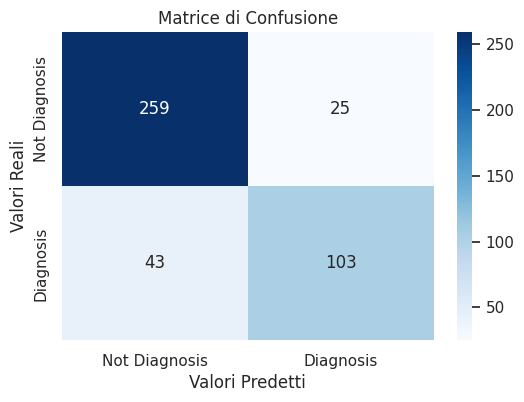


Calcolo del valore del kappa statistic
Kappa statistic value: 0.6365173288250211

Calcolo dell'intervallo di accuratezza per un valore di Z uguale a 1.96
Valore di N: 430
P minimo: 0.804365655495484
P massimo: 0.8733010320697472

Modello allenato sul subset
True Positives (TP): 136
False Positives (FP): 17
False Negatives (FN): 10
True Negatives (TN): 267

Accuratezza: 0.94
Precisione (Diagnosis=1): 0.89
Precisione (Diagnosis=0): 0.96
Precisione media: 0.93
Richiamo (Diagnosis=1): 0.93
Richiamo (Diagnosis=0): 0.94
Richiamo medio: 0.94
F1-Score (Diagnosis=1): 0.91
F1-Score (Diagnosis=0): 0.95
F1-Score medio: 0.93


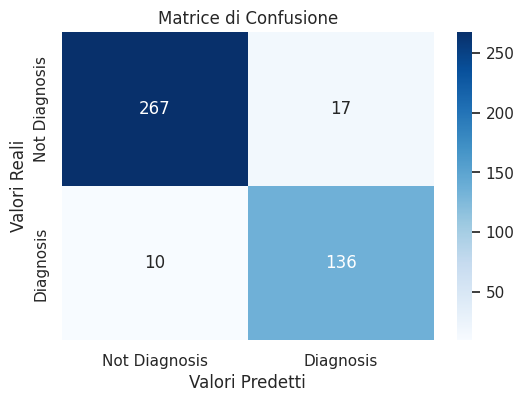


Calcolo del valore del kappa statistic
Kappa statistic value: 0.861611080649391

Calcolo dell'intervallo di accuratezza per un valore di Z uguale a 1.96
Valore di N: 430
P minimo: 0.9101845229444815
P massimo: 0.9564912407443856


In [ ]:
# Analisi dei risulati ottenuti con il modello allenato su tutte le features
print("\nModello con tutte le features")
evaluation_confusion_matrix(best_alz_svm_gs, X_alz_test, y_alz_test, param_name="Diagnosis")
kappa_statistic(best_alz_svm_gs, X_alz_test, y_alz_test)
intervallo_di_accuratezza(best_alz_svm_gs, X_alz_test, y_alz_test)

# Analisi dei risulati ottenuti con il modello allenato sul subset delle features
print("\nModello allenato sul subset")
evaluation_confusion_matrix(best_alz_svm_gs_subset, X_alz_subset_test, y_alz_subset_test, param_name="Diagnosis")
kappa_statistic(best_alz_svm_gs_subset, X_alz_subset_test, y_alz_subset_test)
intervallo_di_accuratezza(best_alz_svm_gs_subset, X_alz_subset_test, y_alz_subset_test)

In [ ]:
# Confronto tra i due modelli ottenuti
confronta_modelli(best_alz_svm_gs, best_alz_svm_gs_subset, X_alz_test, X_alz_subset_test, y_alz_test, y_alz_subset_test)

D minimo: 0.05393464323807623
D massimo: 0.1367630311805284
Lo zero non è contenuto nell'intervallo. Quindi la differenza di score è significativa.


## MLP
Il modello **MLP (Multilayer Perceptron)** rappresenta una struttura simile a quella del cervello umano con i neuroni. In poche parole, l'input che viene dato alla rete viene processato da quelli che vengono definiti *hidden layers*, ognuno dei quali produce poi un valore. L'output della rete viene poi dato dalla combinazione lineare degli output dei neuroni interni.

Vediamo piu nello specifico quelli che sono i parametri del classificatore:
* `activation`: indica quella che è la funzione di attivazione utilizzata, nel nostro caso usiamo ReLu;
* `hidden_layer_size`: indica la dimensione degli strati nascosti. In questo caso possiamo avere un unico layer con *n*  neuroni, oppure utilizzare più layer nascosti, ognuno costituito da un certo numero di neuroni. In questo caso, occorre trovare il compromesso migliore, al fine di evitare overfitting con una rete troppo complessa;
* `alpha`: indica il peso della regolarizzazione L2 sulla rete;
* `learning_rate_init`: indica il valore di learning rate iniziale;
* `max_iter`: indica il numero massimo di iterazioni.

In [30]:
def build_mlp_gs():
  mlp = Pipeline([
      ("scaler", StandardScaler()),
      ("mlp", MLPClassifier( activation="relu"))
  ])

  grid = {
      "mlp__hidden_layer_sizes": [16,32, (16,8)],
      "mlp__batch_size": [100,200],
      "mlp__alpha": [ 0.1, 0.01],
      "mlp__learning_rate_init": [0.001],
      "mlp__max_iter": [500]
  }

  skf = StratifiedKFold(5, shuffle=True)
  gs = GridSearchCV(mlp, grid, cv=skf, n_jobs=-1)
  return gs

### Dataset - Churn

In [ ]:
mlp_gs = build_mlp_gs()
mlp_gs.fit(X_train_res_ch, y_train_res_ch)

print("Migliori parametri MLP:")
print(mlp_gs.best_params_)

Migliori parametri MLP:
{'mlp__alpha': 0.1, 'mlp__batch_size': 200, 'mlp__hidden_layer_sizes': 16, 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 500}


True Positives (TP): 402
False Positives (FP): 352
False Negatives (FN): 159
True Negatives (TN): 1197

Accuratezza: 0.76
Precisione (Churn=1): 0.53
Precisione (Churn=0): 0.88
Precisione media: 0.71
Richiamo (Churn=1): 0.72
Richiamo (Churn=0): 0.77
Richiamo medio: 0.74
F1-Score (Churn=1): 0.61
F1-Score (Churn=0): 0.82
F1-Score medio: 0.72


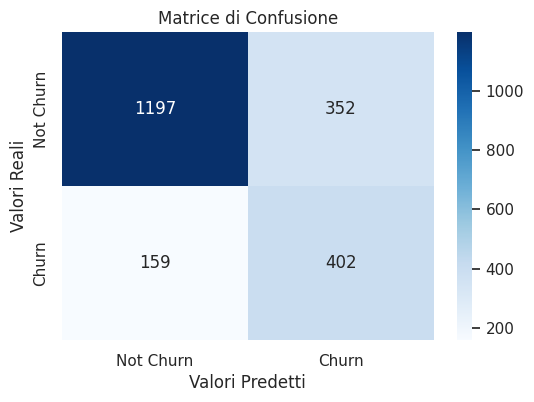


Calcolo del valore del kappa statistic
Kappa statistic value: 0.440954402585834

Calcolo dell'intervallo di accuratezza per un valore di Z uguale a 1.96
Valore di N: 2110
P minimo: 0.7390823472258458
P massimo: 0.7756203627596139


In [ ]:
best_mlp = mlp_gs.best_estimator_

evaluation_confusion_matrix(best_mlp, X_test_ch, y_test_ch, param_name="Churn")
kappa_statistic(best_mlp, X_test_ch, y_test_ch)
intervallo_di_accuratezza(best_mlp, X_test_ch, y_test_ch)

### Dataset - Diabete

In [31]:
dia_mlp_gs = build_mlp_gs()
dia_mlp_gs.fit(X_dia_train_resampled, y_dia_train_resampled)
analyze_grid_search_results(dia_mlp_gs)

Migliori parametri trovati: {'mlp__alpha': 0.01, 'mlp__batch_size': 100, 'mlp__hidden_layer_sizes': 32, 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 500}
Miglior punteggio medio CV: 0.8985659689825575

Dettagli dei risultati della Grid Search (prime 10 combinazioni):
    param_mlp__alpha  param_mlp__batch_size param_mlp__hidden_layer_sizes  param_mlp__learning_rate_init  param_mlp__max_iter  mean_test_score  std_test_score  rank_test_score
7               0.01                    100                            32                          0.001                  500         0.898566        0.001298                1
10              0.01                    200                            32                          0.001                  500         0.898215        0.001273                2
8               0.01                    100                       (16, 8)                          0.001                  500         0.897980        0.002070                3
11              0.01  

True Positives (TP): 7116
False Positives (FP): 13794
False Negatives (FN): 3413
True Negatives (TN): 44520

Accuratezza: 0.75
Precisione (Diabete=1): 0.34
Precisione (Diabete=0): 0.93
Precisione media: 0.63
Richiamo (Diabete=1): 0.68
Richiamo (Diabete=0): 0.76
Richiamo medio: 0.72
F1-Score (Diabete=1): 0.45
F1-Score (Diabete=0): 0.84
F1-Score medio: 0.65


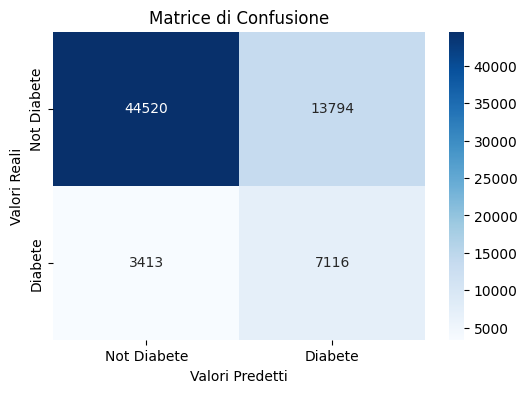


Calcolo del valore del kappa statistic
Kappa statistic value: 0.3129006323945914

Calcolo dell'intervallo di accuratezza per un valore di Z uguale a 1.96
Valore di N: 68843
P minimo: 0.7468061676205131
P massimo: 0.7532748702291593


In [32]:
best_mpl_dia = dia_mlp_gs.best_estimator_

evaluation_confusion_matrix(best_mpl_dia, X_dia_val, y_dia_val, param_name="Diabete")
kappa_statistic(best_mpl_dia, X_dia_val, y_dia_val)
intervallo_di_accuratezza(best_mpl_dia, X_dia_val, y_dia_val)

### Dataset Alzheimer


In [ ]:
# Creo la grid search per il modello da allenare su tutte le features e faccio il fit
alz_mlp_gs = build_mlp_gs()
alz_mlp_gs.fit(X_alz_train_resampled, y_alz_train_resampled)

# Creo la grid search per il modello da allenare solo sulle fetures rilevanti e faccio il fit
alz_mlp_gs_subset = build_mlp_gs()
alz_mlp_gs_subset.fit(X_alz_subset_train_resampled, y_alz_subset_train_resampled)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('mlp', MLPClassifier())]),
             n_jobs=-1,
             param_grid={'mlp__alpha': [0.1, 0.01],
                         'mlp__batch_size': [100, 200],
                         'mlp__hidden_layer_sizes': [16, 32, (16, 8)],
                         'mlp__learning_rate_init': [0.001],
                         'mlp__max_iter': [500]})

In [ ]:
# Mostro i migliori parametri e lo score del miglior modello allenato su tutte le features
print("\nModello con tutte le features")
display(pd.Series(alz_mlp_gs.best_params_))
best_alz_mlp_gs = alz_mlp_gs.best_estimator_
print(best_alz_mlp_gs.score(X_alz_test, y_alz_test))

print("\nModello allenato sul subset")
# Mostro i migliori parametri e lo score del miglior modello allenato sul sottoinsieme di features
display(pd.Series(alz_mlp_gs_subset.best_params_))
best_alz_mlp_gs_subset = alz_mlp_gs_subset.best_estimator_
print(best_alz_mlp_gs_subset.score(X_alz_subset_test, y_alz_subset_test))


Modello con tutte le features


mlp__alpha                   0.100
mlp__batch_size            200.000
mlp__hidden_layer_sizes     16.000
mlp__learning_rate_init      0.001
mlp__max_iter              500.000
dtype: float64

0.8302325581395349

Modello allenato sul subset


mlp__alpha                     0.1
mlp__batch_size                100
mlp__hidden_layer_sizes    (16, 8)
mlp__learning_rate_init      0.001
mlp__max_iter                  500
dtype: object

0.9395348837209302



Modello con tutte le features
True Positives (TP): 111
False Positives (FP): 38
False Negatives (FN): 35
True Negatives (TN): 246

Accuratezza: 0.83
Precisione (Diagnosis=1): 0.74
Precisione (Diagnosis=0): 0.88
Precisione media: 0.81
Richiamo (Diagnosis=1): 0.76
Richiamo (Diagnosis=0): 0.87
Richiamo medio: 0.81
F1-Score (Diagnosis=1): 0.75
F1-Score (Diagnosis=0): 0.87
F1-Score medio: 0.81


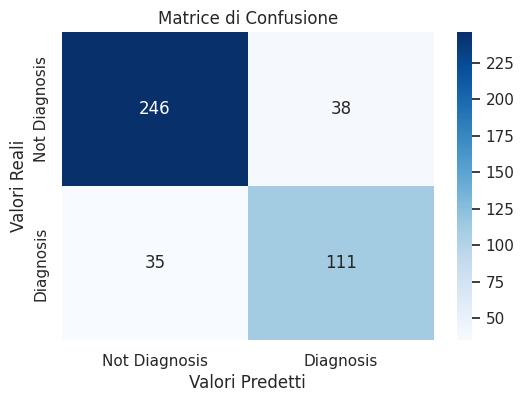


Calcolo del valore del kappa statistic
Kappa statistic value: 0.6233591706462528

Calcolo dell'intervallo di accuratezza per un valore di Z uguale a 1.96
Valore di N: 430
P minimo: 0.7918597090943681
P massimo: 0.8627570911387124

Modello allenato sul subset
True Positives (TP): 134
False Positives (FP): 14
False Negatives (FN): 12
True Negatives (TN): 270

Accuratezza: 0.94
Precisione (Diagnosis=1): 0.91
Precisione (Diagnosis=0): 0.96
Precisione media: 0.93
Richiamo (Diagnosis=1): 0.92
Richiamo (Diagnosis=0): 0.95
Richiamo medio: 0.93
F1-Score (Diagnosis=1): 0.91
F1-Score (Diagnosis=0): 0.95
F1-Score medio: 0.93


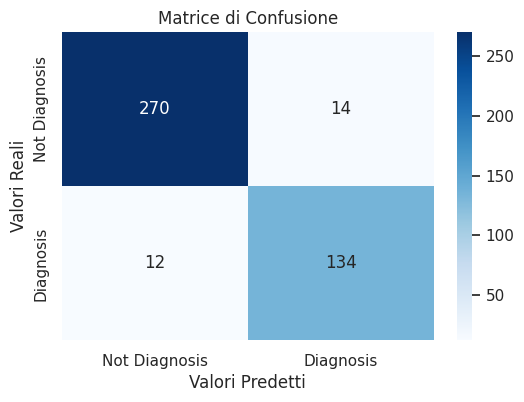


Calcolo del valore del kappa statistic
Kappa statistic value: 0.8656314600259603

Calcolo dell'intervallo di accuratezza per un valore di Z uguale a 1.96
Valore di N: 430
P minimo: 0.9128792284851667
P massimo: 0.9584065126701306


In [ ]:
# Analisi dei risulati ottenuti con il modello allenato su tutte le features
print("\nModello con tutte le features")
evaluation_confusion_matrix(best_alz_mlp_gs, X_alz_test, y_alz_test, param_name="Diagnosis")
kappa_statistic(best_alz_mlp_gs, X_alz_test, y_alz_test)
intervallo_di_accuratezza(best_alz_mlp_gs, X_alz_test, y_alz_test)

# Analisi dei risulati ottenuti con il modello allenato sul subset delle features
print("\nModello allenato sul subset")
evaluation_confusion_matrix(best_alz_mlp_gs_subset, X_alz_subset_test, y_alz_subset_test, param_name="Diagnosis")
kappa_statistic(best_alz_mlp_gs_subset, X_alz_subset_test, y_alz_subset_test)
intervallo_di_accuratezza(best_alz_mlp_gs_subset, X_alz_subset_test, y_alz_subset_test)

In [ ]:
# Confronto tra i due modelli ottenuti
confronta_modelli(best_alz_mlp_gs, best_alz_mlp_gs_subset, X_alz_test, X_alz_subset_test, y_alz_test, y_alz_subset_test)

D minimo: 0.06726973313187203
D massimo: 0.15133491803091859
Lo zero non è contenuto nell'intervallo. Quindi la differenza di score è significativa.


#Risultati ottenuti e commenti

## Risultati dei modelli sul dataset Telco Customer Churn

| Modello              | Accuracy | Precision (Churn=1) | Recall (Churn=1) | F1-Score (Churn=1) | Kappa  |
|----------------------|----------|----------------------|------------------|---------------------|--------|
| Logistic Regression  | 0.76     | 0.54                 | 0.73             | 0.62                | 0.4503 |
| Random Forest        | 0.75     | 0.52                 | 0.73             | 0.61                | 0.4274 |
| XGBoost              | 0.75     | 0.53                 | 0.71             | 0.60                | 0.4302 |
| SVM                  | 0.76     | 0.54                 | 0.71             | 0.61                | 0.4479 |
| MLP                  | 0.76     | 0.54                 | 0.72             | 0.62                | 0.4483 |


### Scelta del modello migliore per Telco Customer Churn

Nell’analisi del dataset **Telco Customer Churn**, sono stati testati diversi modelli di classificazione. I risultati mostrano performance simili tra i modelli, ma con leggere differenze su **precision**, **recall**, e **F1-score**, che vanno interpretate in funzione degli obiettivi aziendali.

#### Obiettivi possibili dell'azienda

- **Ridurre il tasso di abbandono (churn)**: massimizzare il **recall**, ovvero identificare più clienti a rischio possibile.
- **Ottimizzare le risorse e le campagne di retention**: aumentare la **precision**, cioè evitare falsi allarmi (clienti erroneamente classificati come a rischio).
- **Trovare un compromesso efficace**: bilanciare precision e recall attraverso il **F1-score**.

#### Interpretazione dei risultati

- **Logistic Regression** e **MLP** offrono il miglior equilibrio tra precisione e richiamo, con un **F1-score (Churn=1)** di **0.62** e un **Kappa** attorno a **0.45** → buoni candidati se si cerca un compromesso affidabile e interpretabilità.
- **Random Forest** e **XGBoost** ottengono performance simili, ma leggermente inferiori su precision e F1-score → validi se si vogliono modelli più robusti e flessibili.
- **SVM** ha performance comparabili ma richiede maggiore potenza computazionale, e può essere meno interpretabile → da valutare solo se si dispone di risorse sufficienti.

#### Metriche chiave

- **Recall (Churn=1)**: indica quanti clienti churn effettivi sono stati correttamente identificati. Fondamentale se l’obiettivo è non perdere clienti a rischio.
- **Precision (Churn=1)**: indica quanto possiamo fidarci di una previsione positiva. Essenziale se i costi di campagne di fidelizzazione sono elevati.
- **Kappa**: misura l’accordo del modello rispetto al caso casuale. Più è alto, più il modello è affidabile.

#### Raccomandazione

Per un'azienda che vuole **agire proattivamente** sul churn e ha bisogno di un modello **facile da interpretare**, **Logistic Regression** rappresenta la scelta migliore.

Se invece si dispone di maggiori **risorse computazionali** e si vogliono sfruttare modelli più complessi, **MLP** o **SVM** possono offrire benefici marginali in termini di performance, mantenendo una buona stabilità.

---


## Risultati dei modelli sul dataset **Diabetes prediction**

| Modello              | Accuracy | Precision (Diabete=1) | Recall (Diabete=1) | F1-Score (Diabete=1) | Kappa  |
|----------------------|----------|----------------------|------------------|---------------------|--------|
| Logistic Regression  | 0.72    | 0.32                | 0.73             | 0.44                | 0.2933 |
| Random Forest        | 0.72    | 0.31                 | 0.73             | 0.43                | 0.2738 |
| XGBoost              | 0.75    | 0.34                 | 0.68             | 0.45               | 0.3108 |
| SVM                  | /    | /                 | /             | /                | / |
| MLP                  | 0.75     | 0.34                 | 0.68             | 0.45                | 0.3100 |


### Scelta del modello migliore per Diabetes Indicators Set

L'analisi dei diversi modelli sul dataset relativo ai fattori di rischio per il diabete, ha mostrato come questi performino in maniera abbastanza simile con i dati a disposizione, con qualche differenza.

#### Obiettivi possibili

Per riuscire a trovare l'alternativa migliore, bisogna sapere analizzare i risultati ottenuti e per farlo, occorre individuare anche quali possono essere le priorità del modello che dobbiamo costruire. Spesso in ambito medico, viene data precedenza a quello che è il valore di *recall*, questo perché è più importante riuscire ad individuare quante più persone diabetiche, piuttosto che preoccuparsi di predire qualche falso positivo in più (quindi andando a discapito della *precision*).

#### Interpretazione dei risultati

Partiamo da una considerazione: il dataset di partenza era fortemente sbilanciato e questo poneva un problema da risolvere nel pre-processing dei dati, prima di effettuare il training. Nonostante sia stata applicata la tecnica di SMOTEENN, i risultati del modello non sono ancora soddisfacenti, con uno sbilnaciamento tra valori di precision e recall, caso tipico di lavoro con dataset sbilanciato. Questo aspetto può essere dato dal fatto che, come abbiamo visto in fase di analisi dei dati, le feature sono tante e hanno tutte una scarsa correlazione con la variabile da predire, e quindi anche la creazione di dati sintetici da parte di SMOTEENN non riesce a creare un buon set di training a causa del forte rumore tra le diverse istanze.

Analizzando i risultati dei modelli, vediamo comunque un valore di *Recall* accettabile (intorno allo 0.7 per i diversi modelli) e, come spiegato nel punto precedente, questo aspetto è più importante in ambito medico. Questo valore maggiore di *Recall* va però a discapito del valore di *Precision*, che si assesta intorno allo 0.30-0.35, che risulta essere un valore mediocre.

Con modelli come Logistic Regression e Random Forest otteniamo dei risultati maggiormente sbilanciati sulla Recall, mentre con gli altri modelli i risultati sono maggiormente bilanciati (nonostante rimangano accentuati sulla Recall).

Il valore migliore di *kappa-statistic* lo ottiene XGBoost, portantodolo a quasi 0.3, il quale rappresenta una misura discreta, appena sopra un classificatore casuale.

### Raccomandazione

I modelli forniti hanno una buona Recall, ma prestazioni generali ancora non ottimali (si vedano i valori di F1-score e di kappa-statistics). I risultati potrebbero essere figli della natura sparsa del dataset, nel quale il confine tra diabetici e non è difficile da tracciare.

---


## Risultati e commenti sul dataset **Alzheimer**
### Risultati dei modelli sul dataset Alzheimer (tutte le features)

| Modello              | Accuracy | Precision		   | Recall  	    | F1-Score		  | Kappa  |
|----------------------|----------|----------------------|------------------|---------------------|--------|
| Logistic Regression  | 0.85     | 0.83                 | 0.83             | 0.83                | 0.6646 |
| Random Forest        | 0.95     | 0.94                 | 0.94             | 0.94                | 0.8859 |
| XGBoost              | 0.95     | 0.94                 | 0.94             | 0.94                | 0.8859 |
| SVM                  | 0.84     | 0.84                 | 0.81             | 0.82                | 0.6365 |
| MLP                  | 0.83     | 0.81                 | 0.81             | 0.81                | 0.6234 |


### Risultati dei modelli sul dataset Alzheimer (subset di features)

| Modello              | Accuracy | Precision		   | Recall  	    | F1-Score		  | Kappa  |
|----------------------|----------|----------------------|------------------|---------------------|--------|
| Logistic Regression  | 0.85     | 0.83                 | 0.86             | 0.84                | 0.6854 |
| Random Forest        | 0.95     | 0.95                 | 0.94             | 0.95                | 0.8909 |
| XGBoost              | 0.97     | 0.96                 | 0.96             | 0.96                | 0.9224 |
| SVM                  | 0.94     | 0.94                 | 0.94             | 0.94                | 0.8616 |
| MLP                  | 0.94     | 0.93                 | 0.93             | 0.93                | 0.8656 |

### Secondo il confronto tra i modelli ottenuti risulta che
- Logistic Regression: differenza non significativa tra i due modelli
- Random Forest: differenza non significativa tra i due modelli
- XGBoost: differenza non significativa tra i due modelli
- SVM: differenza significativa tra i due modelli, il modello allenato sul subset performa meglio
- MLP: differenza significativa tra i due modelli, il modello allenato sul subset performa meglio

### Scelta del modello migliore per la classificazione dell'Alzheimer

Nel contesto della diagnosi predittiva della malattia di Alzheimer, sono stati testati diversi modelli di classificazione, sia sull'intero set di feature che su un subset selezionato. Le metriche ottenute mostrano performance elevate, con XGBoost, Random Forest e SVM che si distinguono per accuratezza e F1-score.

#### Obiettivi dell'applicazione clinica
- Massimizzare l'identificazione dei casi reali di Alzheimer: richiede un recall elevato, fondamentale per non trascurare pazienti affetti.

- Ridurre i falsi positivi (diagnosi errate): implica una precision elevata, importante per evitare allarmi infondati.

- Trovare un equilibrio tra sensibilità e precisione: viene valutato tramite l'F1-score.

- Valutare l'accordo complessivo del modello rispetto al caso casuale: misurato dal coefficiente Kappa.

#### Interpretazione dei risultati
- XGBoost sul subset di feature raggiunge la miglior performance globale: accuracy, precision, recall e F1-score tutte pari a 0.96, con un Kappa di 0.9224 → modello altamente efficace, particolarmente indicato se si desidera massima accuratezza predittiva.

- Random Forest mantiene performance eccellenti in entrambi i casi, con una differenza non significativa tra le due versioni → valido se si cerca robustezza e buona interpretabilità tramite feature importance.

- SVM e MLP mostrano miglioramenti significativi sul subset di feature: l'accuratezza e le metriche aumentano visibilmente, suggerendo che una selezione mirata delle variabili favorisce questi modelli.

- Logistic Regression si conferma solida e stabile, con performance costanti e differenze non significative tra i due insiemi di feature → adatta in contesti dove è cruciale la trasparenza e interpretabilità delle decisioni.

#### Metriche chiave
- Recall (Classe Alzheimer): riflette la capacità del modello di intercettare correttamente i malati, fondamentale per applicazioni mediche in cui è più pericoloso non rilevare un caso che segnalarne uno erroneamente.

- Precision (Classe Alzheimer): misura l'attendibilità delle diagnosi positive. Un valore elevato riduce interventi clinici inutili.

- F1-Score: bilancia precision e recall, utile quando è necessario ottimizzare entrambi.

- Kappa: quantifica quanto il modello supera le performance casuali. Un Kappa > 0.8 indica accordo eccellente.

#### Raccomandazione
Se l'obiettivo è massimizzare la precisione diagnostica senza sacrificare recall o stabilità, il modello XGBoost sul subset di feature rappresenta la scelta ottimale.

In scenari con vincoli di interpretabilità o necessità di modelli lineari, la Logistic Regression può comunque offrire buone prestazioni, con un F1-score superiore a 0.83 e una stabilità tra i dataset.

Modelli come SVM e MLP beneficiano visibilmente della riduzione delle feature, risultando competitivi in contesti in cui si possono ottimizzare i dati in ingresso.